In [4]:
pacman::p_load(dplyr,ggplot2,tidyverse,patchwork,data.table,lme4,quantreg,bbmle,ggridges)

In [5]:
sessionInfo()

R version 4.1.0 (2021-05-18)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /vortexfs1/home/akrinos/.conda/envs/EUKulele/envs/rversion4/lib/libopenblasp-r0.3.15.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] ggridges_0.5.4    bbmle_1.0.25      quantreg_5.88     SparseM_1.81     
 [5] lme4_1.1-29       Matrix_1.6-1.1    data.table_1.14.8 patchwork_1.1.2  
 [9] forcats_1.0.0     stringr_1.5.0     purrr_1.0.1       readr_2.1.2      
[13] tidyr_1.3.0       tibble_3.

### Read in data from analysis notebook
`../process-all-fcs-data.ipynb`

In [2]:
final_data = data.frame(fread("../../data/new_consol_2.csv"))

### Workflow for parameter estimation

1. Fit curve with maximum likelihood
2. Perform optimization on resulting curve to find x-value of maximum to identify thermal optimum
3. Calculate x-intercepts of curves to identify thermal interval

Warning message:
“There was 1 warning in
`dplyr::mutate()`.
ℹ In argument: `Position =
  as.numeric(Position)`.
Caused by warning:
! NAs introduced by coercion”
Warning message:
“There was 1 warning in
`dplyr::mutate()`.
ℹ In argument: `Position =
  as.numeric(Position)`.
Caused by warning:
! NAs introduced by coercion”
Warning message in dplyr::left_join(., final_conc, by = c(Date = "FirstLogDate", :
“Detected an unexpected
many-to-many relationship between
`x` and `y`.
ℹ Row 1 of `x` matches multiple
  rows in `y`.
ℹ Row 2 of `y` matches multiple
  rows in `x`.
ℹ If a many-to-many relationship
  is expected, set `relationship
  = "many-to-many"` to silence
  this warning.”
Joining with `by =
join_by(Position)`
Warning message in dplyr::left_join(., final_conc_post, by = c(Date = "FirstLogDate", :
“Detected an unexpected
many-to-many relationship between
`x` and `y`.
ℹ Row 1 of `x` matches multiple
  rows in `y`.
ℹ Row 49 of `y` matches multiple
  rows in `x`.
ℹ If a many-to-many rela

[1] "10000Best guess"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.136061
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 3963


Warning message in rnorm(10000, mean = gr, sd = sd_gr * sqrt((nrow(growth_rates) - :
“NAs produced”


[1] "10000Best guess"
[1] 0.01386898
[1] "^b"
[1] 3492
[1] "10000Best guess"
[1] 0.04622866
[1] "^b"
[1] 1516
# A tibble: 29 × 2
   Temperature GrowthRate
         <dbl>      <dbl>
 1         9        0.01 
 2         9        0.01 
 3         9        0.01 
 4        12        0.504
 5        12        0.562
 6        12        0.514
 7        17        0.739
 8        17        0.541
 9        17        0.672
10        18.6      0.836
# ℹ 19 more rows
[1] "10000Best guess"
[1] 0.07546327
[1] "^b"
[1] 874
[1] "10000Best guess"
[1] 0.01791198
[1] "^b"
[1] 375
[1] "10000Best guess"

Call:
bbmle::mle2(minuslogl = LL1, start = list(a = a, b = b, o = o_guess, 
    w = w_guess), data = list(y = as.numeric(bootstrapped_points$GrowthRate), 
    x = as.numeric(bootstrapped_points$Temperature)), control = list(maxit = 1e+06, 
    abstol = 1e-20))

Coefficients:
          a           b           w           o 
 0.02839779  0.15822338 22.84897392 17.99647823 

Log-likelihood: -22.24 


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.1582234
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 2090
[1] "10000Best guess"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.01654659
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 379
[1] "10000Best guess"
[1] 0.03164356
[1] "^b"
[1] 1212
[1] "10000Best guess"
[1] 0.0644859
[1] "^b"
[1] 371


Warning message:
“Values from `concpivot` are not
uniquely identified; output will
contain list-cols.
• Use `values_fn = list` to
  suppress this warning.
• Use `values_fn = {summary_fun}`
  to summarise duplicates.
• Use the following dplyr code to
  identify duplicates.
  {data} %>%
  dplyr::group_by(Strain,
  Position, Temperature, Rep,
  Transfer, GR_Calc_placeholder)
  %>%
  dplyr::summarise(n =
  dplyr::n(), .groups = "drop")
  %>%
  dplyr::filter(n > 1L)”
Warning message:
“Expected 2 pieces. Additional
pieces discarded in 1 rows [14].”
Warning message:
“Expected 2 pieces. Missing pieces
filled with `NA` in 6 rows [1, 2,
3, 4, 5, 6].”
Warning message:
“Expected 2 pieces. Additional
pieces discarded in 1 rows [8].”
Warning message:
“There were 2 warnings in
`dplyr::mutate()`.
The first warning was:
ℹ In argument: `TF =
  as.numeric(TF)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run
  `dplyr::last_dplyr_warnings()`
  to see the 1 remaining warning.”


[1] "10000Best guess"
[1] 0.05379428
[1] "^b"
[1] 6071
[1] "10000Best guess"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.1096167
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 914
[1] "10000Best guess"
[1] 0.06555418
[1] "^b"


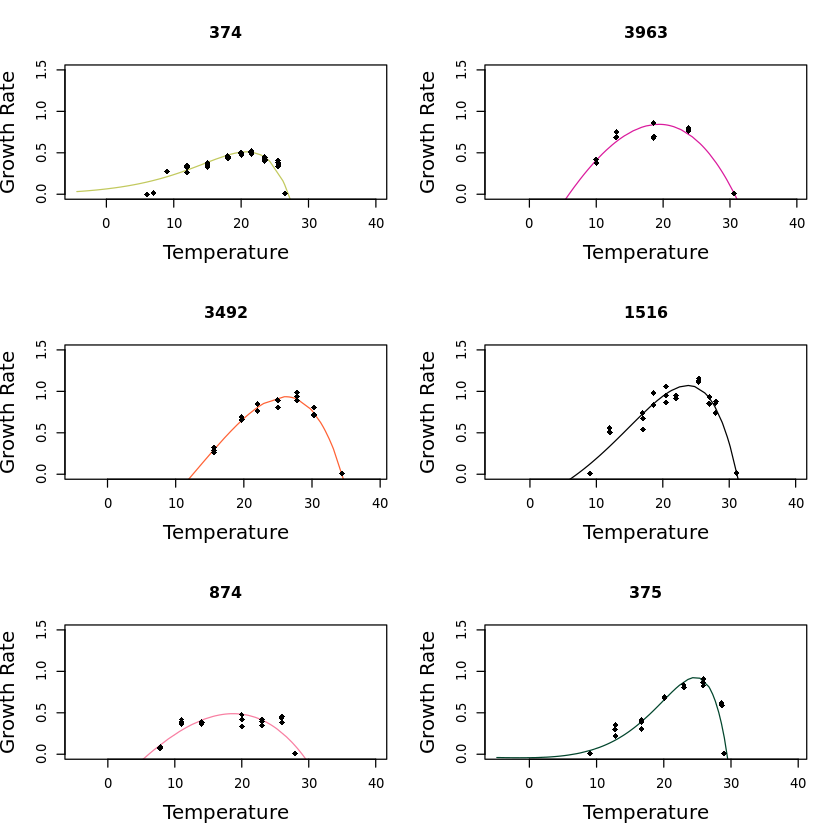

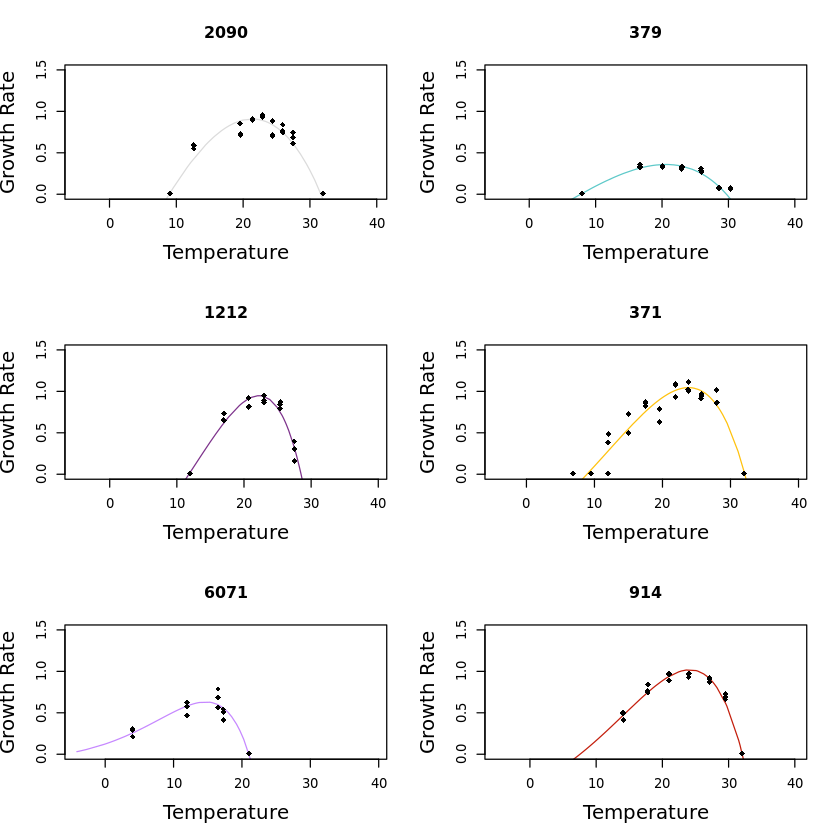

In [3]:
#### FUNCTIONS ####

nbcurve <- function(x,opt,w,a,b){
  res<-a*exp(b*x)*(1-((x-opt)/(w/2))^2)
  res
}

LL1 <- function (y, x, a, b, w, o){
    N = nbcurve(x=x,a=a,b=b,w=w,opt=o)
    N[N<=0]=0.01
    N=N#log(N) # eliminate missing data from loglikelihood
    y=y#log(y)
    return(-sum(dnorm(y,N,log = TRUE))) # the negative log likelihoods: the order of N and y don't matter)
}

strain_color_frame_harriet = data.frame("Strains_full"=c("RCC6856","RCC6071","RCC1212","RCC3963",
                                                   "RCC874","CCMP1280","RCC4567","RCC914","RCC3492",
                                                   "CCMP371","RCC1215","CCMP377","RCC1239",
                                                   "RCC1222","RCC1256","CCMP374","CCMP379","CCMP1516",
                                                   "CCMP2090","CCMP375"),
                                        "Strains"=c("6856","6071","1212","3963",
                                                   "874","1280","4567","914","3492",
                                                   "371","1215","377","1239",
                                                   "1222","1256","374","379","1516",
                                                   "2090","375"),
                                        "Colors"=c("#4443c6","#c688ff","#7d328b","#da1b9d",
                                                  "#f87fa2","#b90033","#ff5755","#c31d0b",
                                                  "#ff6235","#ffc10c","#e4e366","#5a9f00",
                                                  "#60b574","#00b9bf","#0194e3","#C2C95E",
                                                  "#5EC9C9","#000000","#DBDBDB","#01452c"))

return_params <- function(fcm_frame,strain,return_gr_frame=FALSE) {
    if (strain=="6071_old") {
        growth_rates=fcm_frame %>% 
             dplyr::filter(Strain==strain) %>%
             dplyr::mutate(Date=case_when(grepl("/",Date) ~ as.Date(Date,format="%m/%d/%y"),
                                          TRUE ~ as.Date(Date,format="%Y-%m-%d"))) %>%
             dplyr::select(Date,Strain,Position,Temperature,Rep,Transfer,ConcCellmL,GR_Calc_placeholder) %>%
             separate_rows(Position,Rep,Temperature,sep=",") %>%
             dplyr::mutate(Position=case_when((as.numeric(Position)==4)&(Strain==6071)~0,
                                              (as.numeric(Position)==10)&(as.numeric(Strain)==3963)~0,
                                                 TRUE ~ Position),
                          Temperature=case_when((as.numeric(Position)==10)&(as.numeric(Strain)==3963)~10,
                                                 TRUE ~ Temperature)) %>%
             dplyr::filter(GR_Calc_placeholder %in% c("TF","T0")) %>% dplyr::filter((Transfer=="C")|(Position==0)) %>%
             dplyr::mutate(concpivot = paste(ConcCellmL,Date,sep="_")) %>%
             tidyr::pivot_wider(id_cols=c("Strain","Position","Temperature","Rep","Transfer"),
                                names_from = GR_Calc_placeholder, values_from = concpivot) %>%
             tidyr::separate(TF,sep="_",into=c("TF","Date_F"))%>%
             tidyr::separate(T0,sep="_",into=c("T0","Date_0")) %>%
             dplyr::mutate(Date_F = as.Date(Date_F,format="%Y-%m-%d"),
                           Date_0 = as.Date(Date_0,format="%Y-%m-%d"),
                           TF = as.numeric(TF),T0=as.numeric(T0)) %>%
             dplyr::mutate(Duration = lubridate::as.duration(lubridate::interval(as.Date(Date_0,format="%Y-%m-%d"),
                            as.Date(Date_F,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
             dplyr::mutate(GrowthRate = (log(TF,base=2)-log(T0,base=2))/Duration) %>%
             dplyr::mutate(GrowthRate=case_when(GrowthRate>0 ~ GrowthRate,
                                                TRUE ~ 0.01)) %>%
             dplyr::mutate(ln.r=log(GrowthRate)) %>% dplyr::filter(!((Position==11)&(GrowthRate==0.01)))
    } else if (strain == 374) {
        temperature_correspond_jan20 = data.frame(Position = c(1:20),
                                    Temperature = c(7,8.5,9,11,12,14,15,17,18,19,20,21,21.5,23,23.5,25,
                                                   25.5,26,26.5,28))

        jan2020_data=read.csv("../../data/CombinedTimeSeries_Jan2020_Transfers.csv") %>%
            dplyr::mutate(Date=as.Date(Date,format="%m/%d/%Y"))
        conc_accl=read.csv("../../data/Conc_Oct2020_374_379.csv") %>%
            dplyr::mutate(Date=as.Date(Date,format="%m/%d/%Y"))
        growthrate_379_374=read.csv("../../data/GrowthRateStartEnd_374_379.csv") %>%
            dplyr::mutate(FirstLogDate=as.Date(FirstLogDate,format="%Y-%m-%d"),
                          FinalLogDate=as.Date(FinalLogDate,format="%Y-%m-%d"))
        first_conc=jan2020_data %>% dplyr::mutate(Transfer=as.character(Transfer)) %>%
            dplyr::right_join(growthrate_379_374,by=c("Date"="FirstLogDate",
                                                                              "Strain","Position","Transfer")) %>%
            dplyr::rename(c("FirstConc"="Conc"))
        final_conc=jan2020_data %>% dplyr::mutate(Transfer=as.character(Transfer)) %>%
            dplyr::right_join(growthrate_379_374,by=c("Date"="FinalLogDate",
                                                                                    "Strain","Position","Transfer")) %>%
            dplyr::rename(c("FinalConc"="Conc"))

        first_conc_post=conc_accl %>% dplyr::mutate(Position=as.numeric(Position),Transfer="F") %>% 
            dplyr::right_join(growthrate_379_374,by=c("Date"="FirstLogDate","Strain","Transfer","Position")) %>%
            dplyr::rename(c("FirstConc"="Conc"))
        final_conc_post=conc_accl %>% dplyr::mutate(Position=as.numeric(Position),Transfer="F") %>%
            dplyr::right_join(growthrate_379_374,by=c("Date"="FinalLogDate","Transfer","Strain","Position")) %>%
            dplyr::rename(c("FinalConc"="Conc"))


        t1_grs = first_conc %>%
               dplyr::left_join(final_conc,by=c("Date"="FirstLogDate",
                                                "FinalLogDate"="Date",
                                                "Transfer","Strain",
                                                "Position")) %>%
               dplyr::filter(Transfer==1)%>%
            dplyr::mutate(Duration=lubridate::as.duration(lubridate::interval(as.Date(Date,format="%Y-%m-%d"),
                            as.Date(FinalLogDate,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
            dplyr::mutate(GrowthRate=(log(FinalConc,base=2)-log(FirstConc,base=2))/Duration) %>%
            dplyr::left_join(temperature_correspond_jan20) %>%
            dplyr::rename(GR_Transfer1=GrowthRate)%>%dplyr::select(Position,Temperature,GR_Transfer1)
        tf_grs = first_conc_post %>%
               dplyr::left_join(final_conc_post, by=c("Date"="FirstLogDate",
                                                "FinalLogDate"="Date",
                                                "Transfer","Strain","Rep",
                                                "Position")) %>%
            dplyr::mutate(Duration=lubridate::as.duration(lubridate::interval(as.Date(Date,format="%Y-%m-%d"),
                            as.Date(FinalLogDate,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
            dplyr::mutate(GrowthRate=(log(FinalConc,base=2)-log(FirstConc,base=2))/Duration) %>%
            dplyr::left_join(temperature_correspond_jan20) %>%
            dplyr::rename(GR_TransferF=GrowthRate) %>% dplyr::select(Position,Temperature,GR_TransferF)

        growth_rates=t1_grs %>% dplyr::left_join(tf_grs) %>% 
               dplyr::mutate(GrowthRate = dplyr::case_when((Temperature<10)|(Temperature>25) ~ GR_Transfer1,
                                                           TRUE ~ GR_TransferF)) %>%
            dplyr::filter(!is.na(GrowthRate)) %>% dplyr::mutate(Transfer="F") %>%
            dplyr::mutate(GrowthRate=case_when(Temperature==26.5 ~ 0.01,
                                               TRUE ~ GrowthRate))
    } else {
        print(strain)
        growth_rates=fcm_frame %>% 
             dplyr::filter(Strain==strain) %>%
             dplyr::mutate(Date=case_when(grepl("/",Date) ~ as.Date(Date,format="%m/%d/%y"),
                                          TRUE ~ as.Date(Date,format="%Y-%m-%d"))) %>%
             dplyr::select(Date,Strain,Position,Temperature,Rep,Transfer,ConcCellmL,GR_Calc_placeholder) %>%
             separate_rows(Position,Rep,Temperature,sep=",") %>%
             dplyr::mutate(Position=case_when((as.numeric(Position)==4)&(Strain==6071)~0,
                                              (as.numeric(Position)==10)&(as.numeric(Strain)==3963)~0,
                                                 TRUE ~ Position),
                          Temperature=case_when((as.numeric(Position)==10)&(as.numeric(Strain)==3963)~10,
                                                 TRUE ~ Temperature)) %>%
             dplyr::filter(GR_Calc_placeholder %in% c("TF","T0")) %>% dplyr::filter(Transfer=="F") %>%
             dplyr::mutate(concpivot = paste(ConcCellmL,Date,sep="_")) %>%
             tidyr::pivot_wider(id_cols=c("Strain","Position","Temperature","Rep","Transfer"),
                                names_from = GR_Calc_placeholder, values_from = concpivot) %>%
             tidyr::separate(TF,sep="_",into=c("TF","Date_F"))%>%
             tidyr::separate(T0,sep="_",into=c("T0","Date_0")) %>%
             dplyr::mutate(Date_F = as.Date(Date_F,format="%Y-%m-%d"),
                           Date_0 = as.Date(Date_0,format="%Y-%m-%d"),
                           TF = as.numeric(TF),T0=as.numeric(T0)) %>%
             dplyr::mutate(Duration = lubridate::as.duration(lubridate::interval(as.Date(Date_0,format="%Y-%m-%d"),
                            as.Date(Date_F,format="%Y-%m-%d"))) / lubridate::as.duration(86400) + 1) %>%
             dplyr::mutate(GrowthRate = (log(TF,base=2)-log(T0,base=2))/Duration) %>%
             dplyr::mutate(GrowthRate=case_when(GrowthRate>0 ~ GrowthRate,
                                                TRUE ~ 0.01)) %>%
             dplyr::mutate(ln.r=log(GrowthRate)) %>% dplyr::filter(!((Position==11)&(GrowthRate==0.01)))
    }

    color_frame=strain_color_frame_harriet %>% dplyr::filter(Strains==as.character(strain))
    
    ## add extra known data points to drive parameterization
    ## for example, zero growth rates were not calculated, but we add them here since we assume all 
    ## negative growth rates to be zero.
    if (strain==1516) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(c(rep(0.01,3),rep(0.01,3))),
                                        "Temperature"=as.numeric(c(rep(31.1,3),rep(9,3))),"Transfer"=c("F")))
        print(growth_rates %>% arrange(Temperature) %>% dplyr::select(Temperature,GrowthRate))
    }
    if (strain==2090) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(c(rep(0.01,9),rep(0.01,9))),
                                        "Temperature"=as.numeric(c(rep(32,9),rep(9,9))),"Transfer"=c("F")))
    }
    
    if (strain==3492) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(34.4,3)),"Transfer"=c("F")))
    }
    
    if (strain==3963) {
        growth_rates = growth_rates %>% dplyr::filter(Temperature < 27) %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(0.01),
                                        "Temperature"=as.numeric(30.6),"Transfer"=c("F")))
    }
    
    
    if (strain==375) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=as.numeric(c(rep(0.01,3),rep(0.01,3))),
                                        "Temperature"=as.numeric(c(rep(29,3),rep(9,3))),
                                        "Transfer"=c("F")))
    }
    if (strain==1212) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(12,3)),"Transfer"=c("F")))
    }
    
    
    if (strain==6071) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3),rep(0.01,9)),
                                        "Temperature"=as.numeric(rep(21,3),
                                                                 rep(2,9)),"Transfer"=c("F")))
    }
    
    
    if (strain==374) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,9),rep(0.00001,9)),
                                        "Temperature"=as.numeric(c(rep(7,9),rep(6,9))),"Transfer"=c("F")))
    }
    
    
    if (strain==371) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(32,3)),"Transfer"=c("F")))
    }
    
    if (strain==914) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3),rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(32,3),rep(9,3)),"Transfer"=c("F")))
    }

    
    if (strain==379) {
        growth_rates = growth_rates %>%
            dplyr::bind_rows(data.frame("GrowthRate"=c(rep(0.01,3)),
                                        "Temperature"=as.numeric(rep(8,9)),"Transfer"=c("F")))
    }
    growth_rates = growth_rates %>% dplyr::mutate(Temperature=as.numeric(Temperature))
    
    if (return_gr_frame) {
        return(growth_rates)
    }
    
    ## Create reasonable guesses for thermal optimum & thermal width
    guess_opt = as.numeric(unique((growth_rates %>% 
                            dplyr::filter(GrowthRate==max(GrowthRate,na.rm=T)))$Temperature))
    
    guess_wid = as.numeric(unique((growth_rates %>% dplyr::filter(GrowthRate>0.0) %>%
                            dplyr::filter(Temperature==max(Temperature,na.rm=T)))$Temperature) - 
                           unique((growth_rates %>% dplyr::filter(GrowthRate>0.0) %>%
                            dplyr::filter(Temperature==min(Temperature,na.rm=T)))$Temperature))

    
    x = sort(runif(100,-5,40))
    a = 0.1 # scale param 1
    b = 0.01 # scale param 2
    o_guess = guess_opt # optimum temperature
    w_guess=15
    if ((guess_wid!=0)&(!is.na(guess_wid))) {
        w_guess = guess_wid # thermal niche width
    }
    
    #We want the indepdendet variable to have global scope--
    # i.e. to be available to all functions.
    
    ## Bootstrap additional data points to be used to fit the model
    bootstrapped_points = data.frame()
    for (temp in unique(growth_rates$Temperature)) {
        gr <- mean(as.numeric((growth_rates %>% dplyr::filter(Temperature==temp))$GrowthRate),na.rm=T)
        sd_gr <- sd(as.numeric((growth_rates %>% dplyr::filter(Temperature==temp))$GrowthRate),na.rm=T)
        chisq <- rchisq(1,df=(nrow(growth_rates)-1))
        n <- rnorm(10000, mean = gr, sd = sd_gr*sqrt((nrow(growth_rates)-1)/chisq))
        bootstrapped_points = bootstrapped_points %>%
            dplyr::bind_rows(data.frame("Temperature"=rep(temp,10000),
                                        "GrowthRate"=n)) %>% dplyr::filter(!is.na(GrowthRate)&
                                                                           (GrowthRate>=0))
    }
    
    bootstrapped_points=growth_rates %>% dplyr::arrange(Temperature)
    
    bestguess=10000
    best_m=NA
    print(paste0(bestguess,"Best guess"))
    m1=best_m
    
    m1 = bbmle::mle2(minuslogl = LL1, start = list(a = a, b = b,
                                            o = o_guess,w = w_guess),
              data = list(y=as.numeric(bootstrapped_points$GrowthRate),
                          x=as.numeric(bootstrapped_points$Temperature)),
              control=list(maxit=1000000,abstol=1e-20))
    if (strain==375){
        print(m1)
    }
    print(summary(m1)@coef["b","Estimate"])
    print("^b")

    y = nbcurve(x=x,
            a=summary(m1)@coef["a","Estimate"],
            b=summary(m1)@coef["b","Estimate"],
            w=summary(m1)@coef["w","Estimate"],
            opt=summary(m1)@coef["o","Estimate"])
    plot_frame=data.frame(x=x,
                          y=y,
                          type="Modeled") %>% 
            dplyr::bind_rows(data.frame(x=bootstrapped_points$Temperature,
                             y=bootstrapped_points$GrowthRate,
                             type="Measured")) %>%
            dplyr::mutate(x=as.numeric(x)) %>%
            dplyr::arrange(x)
    plot(x,y, typ='l', col=color_frame$Colors[1], cex.lab = 1.5, cex = 1.5,
    xlab="Temperature", ylab="Growth Rate",
    ylim=c(0,1.5))
    points(growth_rates$Temperature,growth_rates$GrowthRate,col=color_frame$Colors[1],pch=18)
    points(bootstrapped_points$Temperature,bootstrapped_points$GrowthRate,col="black",pch=18)
    title(as.character(strain))
    coef_list = data.frame("a"=summary(m1)@coef["a","Estimate"],
            "b"=summary(m1)@coef["b","Estimate"],
            "w"=summary(m1)@coef["w","Estimate"],
            "opt"=summary(m1)@coef["o","Estimate"],"a_err"=summary(m1)@coef["a","Std. Error"],
            "b_err"=b,
            "w_err"=summary(m1)@coef["w","Std. Error"],
            "opt_err"=summary(m1)@coef["o","Std. Error"],"Strain"=strain)
    return(list(data.frame("Temperature"=x,
                      "ModeledPoints"=y,"Type"="Model",
                      "Strain"=strain) %>% 
           dplyr::bind_rows(data.frame("MeasuredPoints"=growth_rates$GrowthRate,
                                       "Temperature"=as.numeric(growth_rates$Temperature),"Type"="Measure",
                                       "Strain"=strain)),coef_list))
}

par(mfrow = c(3, 2))
all_params=data.frame()
all_params_coef=data.frame()
for (strain in c(374,3963,3492,1516,874,375,2090,379,1212,371,6071,914)) {
    paramslist=return_params(final_data,strain=strain)
    all_params=all_params%>%dplyr::bind_rows(paramslist[[1]])
    all_params_coef=all_params_coef%>%dplyr::bind_rows(paramslist[[2]])
}

In [4]:
all_params_coef

a,b,w,opt,a_err,b_err,w_err,opt_err,Strain
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.06562784,0.13606098,46.96904,3.547755,0.03519599,0.01,NaN,NaN,374
0.64977969,0.01386898,24.75824,18.307480,2.61140110,0.01,14.882124,8.998253,3963
0.29684290,0.04622866,21.91422,23.481648,1.20793999,0.01,10.800079,6.112007,3492
0.20924106,0.07546327,24.09606,19.125906,0.38672823,0.01,4.360507,2.510743,1516
0.35372160,0.01791198,22.90887,17.565502,2.10984881,0.01,12.842676,9.458257,874
0.02839779,0.15822338,22.84897,17.996478,0.09599847,0.01,NaN,NaN,375
0.64336070,0.01654659,22.72790,20.304963,NaN,0.01,NaN,NaN,2090
0.19273662,0.03164356,21.96335,18.724645,1.66197034,0.01,12.178114,6.769767,379
0.24089778,0.06448590,16.70321,20.149342,1.11642098,0.01,5.278316,3.182994,1212


In [5]:
revised_df_width =data.frame()
recalculate=TRUE # if this is true, we use optimized Topt rather than the one the eqn spits out.

for (strain_curr in all_params_coef$Strain) {
    opt_val = optimize(nbcurve,interval=c(0,40),maximum=TRUE,
         a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a,
         b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b,
         w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)$maximum
    wid_eq_1 = ((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        (all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt
    wid_eq_2 = -((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        (all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt
    if (recalculate) {
        wid_eq_1 = ((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
            opt_val
        wid_eq_2 = -((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
            opt_val
    }
    revised_df_width = revised_df_width %>%
        dplyr::bind_rows(data.frame(Strain=strain_curr,Revised_wid=abs(wid_eq_2-wid_eq_1)))
}

## Read in data and recalculate parameters from Anderson et al. (2021)

[1] "0.636416136756131; window-100 to -100; strain:Chaetoceros_deflandrei_"
[1] "0.25450457591979; window-100 to -100; strain:Corethron_pennatum_"
[1] "0.642577937932253; window-100 to -100; strain:Fragilariopsis_cylindrus_"
[1] "0.547599781068888; window-100 to -100; strain:Fragilariopsis_kerguelensis_"
[1] "0.579785683925847; window-100 to -100; strain:Pseudo-nitzschia_turgiduloides_"
[1] "0.683137381671057; window-100 to -100; strain:Stellarima_microtrias_"
[1] "0.483403356184525; window-100 to -100; strain:Synedra__"
[1] "0.842184958411662; window-100 to -100; strain:Emiliania_huxleyi_"
[1] "1.13554835305757; window-100 to -100; strain:Emiliania_huxleyi_R strain TQ26"
[1] "0.84120027317404; window-100 to -100; strain:Gephyrocapsa_oceanica_AB1, CAWPOT"
[1] "0.246735775507771; window-100 to -100; strain:Alexandrium_minutum_"
[1] "broken"
[1] "0.325834373241038; window-100 to -100; strain:Calcidiscus_leptoporus_NS10-2"
[1] "0.689382396858779; window-100 to -100; strain:Emiliania_huxle

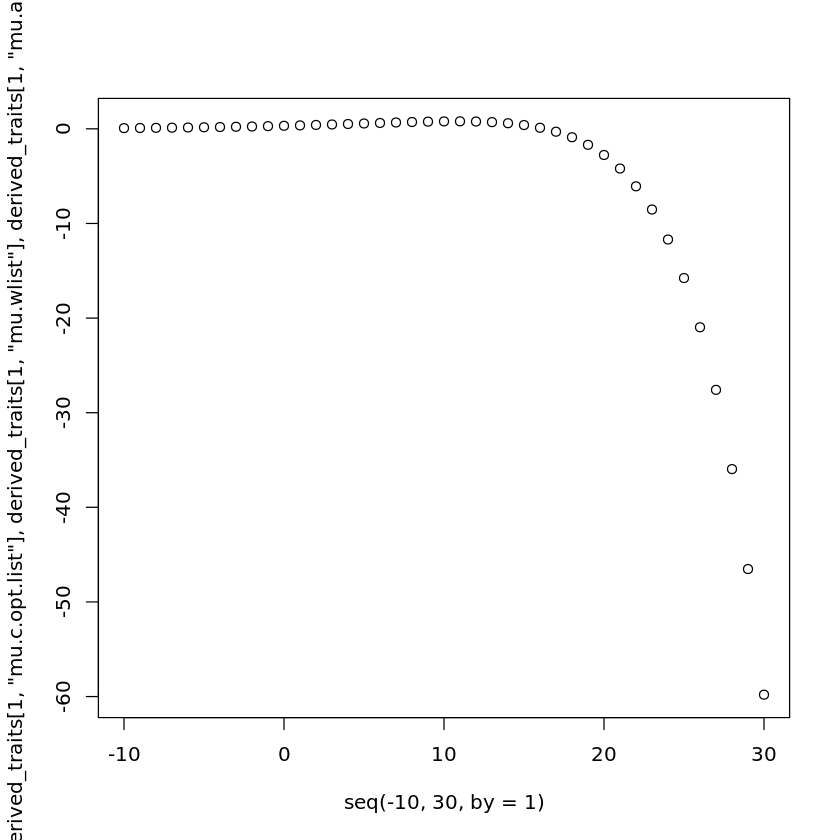

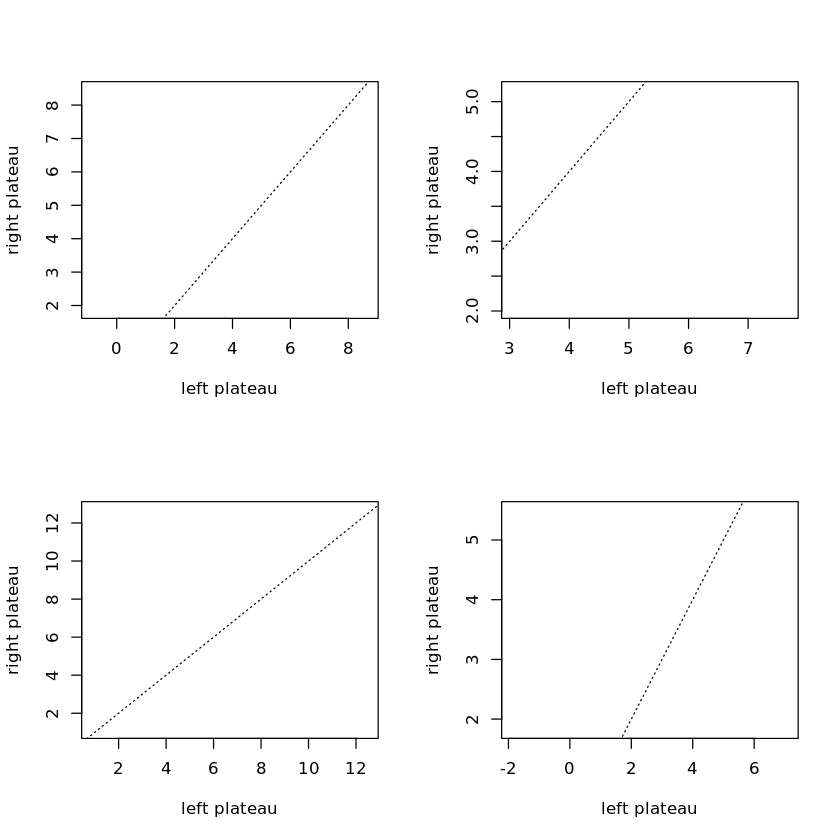

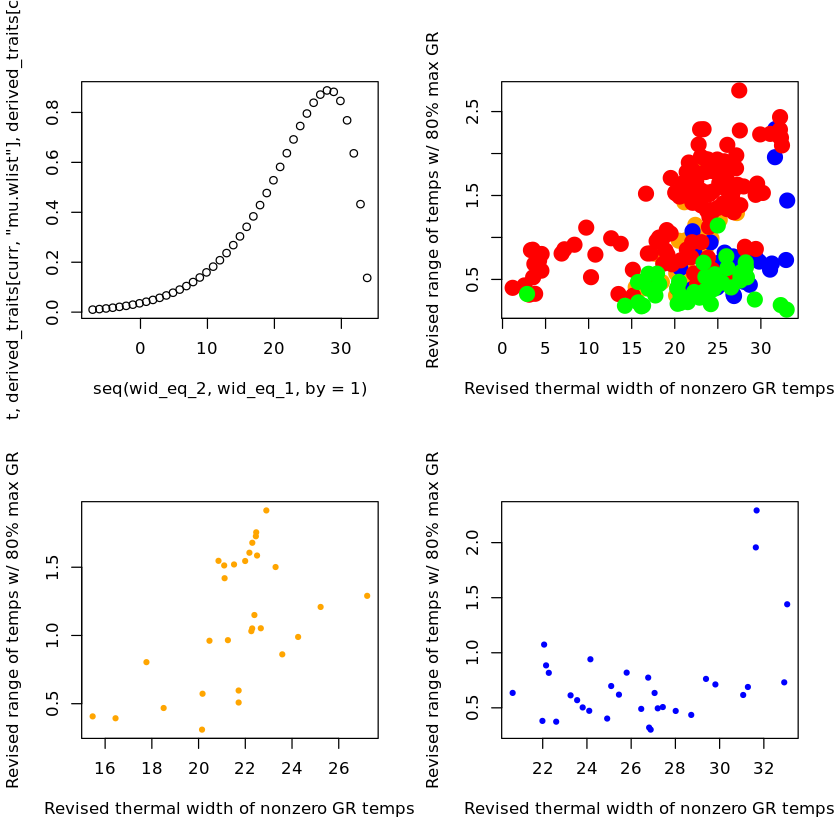

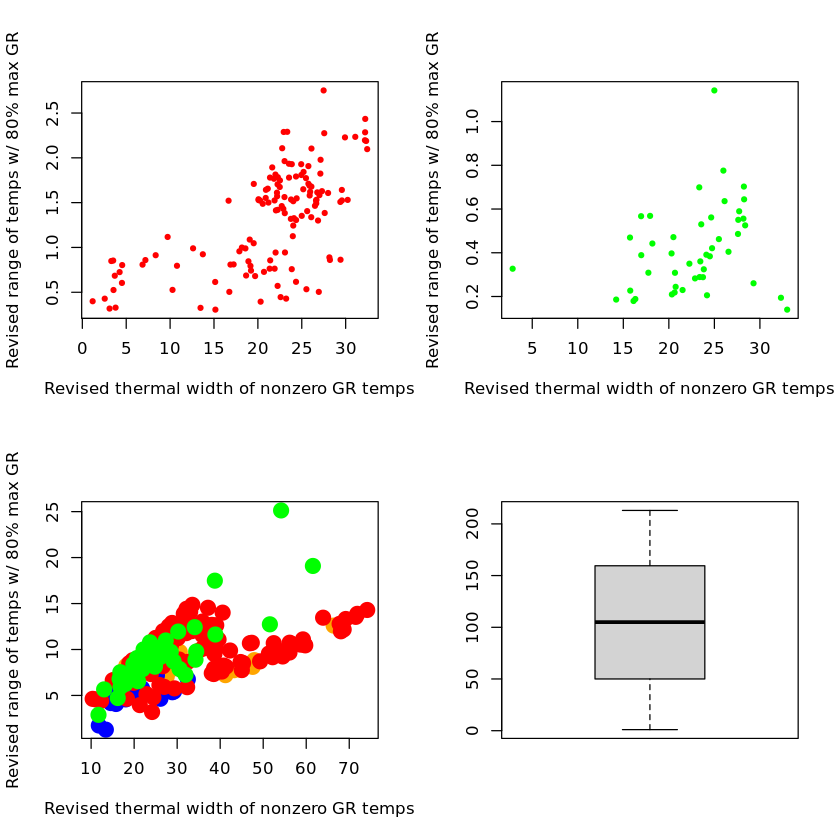


Call:
lm(formula = Revised_plateau ~ Revised_wid, data = revised_df[revised_df$Group == 
    "coccolithophores", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.1732 -1.2798  0.0885  1.0149  2.7150 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.13647    0.83147   8.583 2.51e-09 ***
Revised_wid  0.05111    0.02652   1.928   0.0641 .  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.593 on 28 degrees of freedom
Multiple R-squared:  0.1172,	Adjusted R-squared:  0.08562 
F-statistic: 3.715 on 1 and 28 DF,  p-value: 0.06411



Call:
lm(formula = Revised_plateau ~ Revised_wid, data = revised_df[revised_df$Group == 
    "diatoms", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-6.0550 -1.7141 -0.0884  1.7113  4.8932 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.41803    0.55855  13.281  < 2e-16 ***
Revised_wid  0.07600    0.01468   5.177 8.13e-07 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.371 on 133 degrees of freedom
Multiple R-squared:  0.1677,	Adjusted R-squared:  0.1615 
F-statistic:  26.8 on 1 and 133 DF,  p-value: 8.13e-07



Call:
lm(formula = Revised_plateau ~ Revised_wid, data = revised_df[revised_df$Group == 
    "dinoflagellates", ])

Residuals:
    Min      1Q  Median      3Q     Max 
-4.5064 -0.8348  0.1806  0.9675  7.0813 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.38957    0.80292   1.731   0.0905 .  
Revised_wid  0.30759    0.02884  10.665 8.83e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.956 on 44 degrees of freedom
Multiple R-squared:  0.7211,	Adjusted R-squared:  0.7147 
F-statistic: 113.7 on 1 and 44 DF,  p-value: 8.834e-14


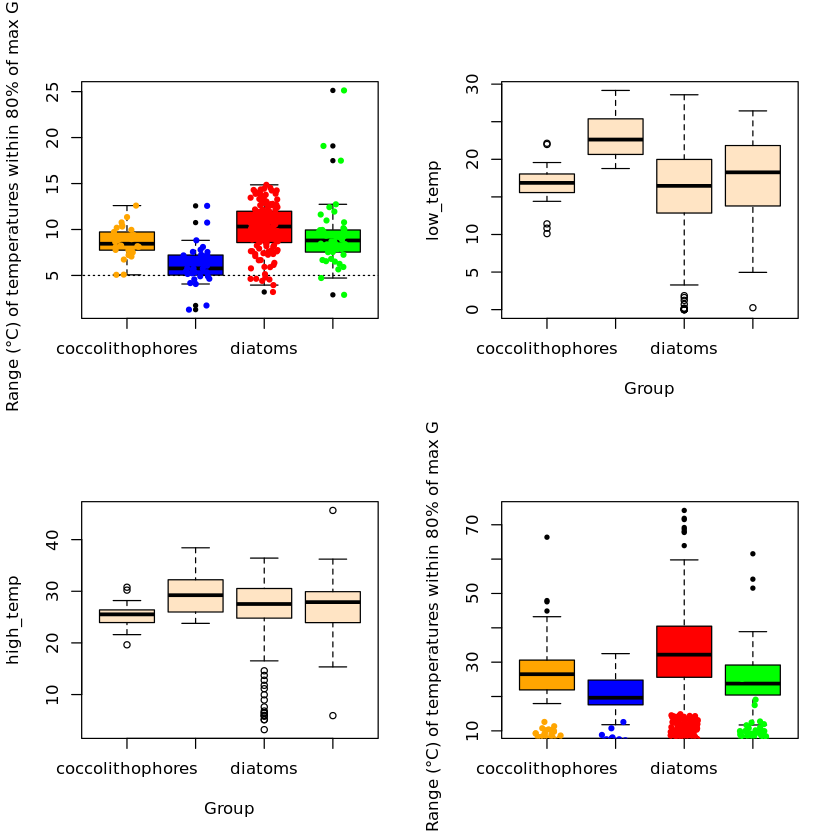

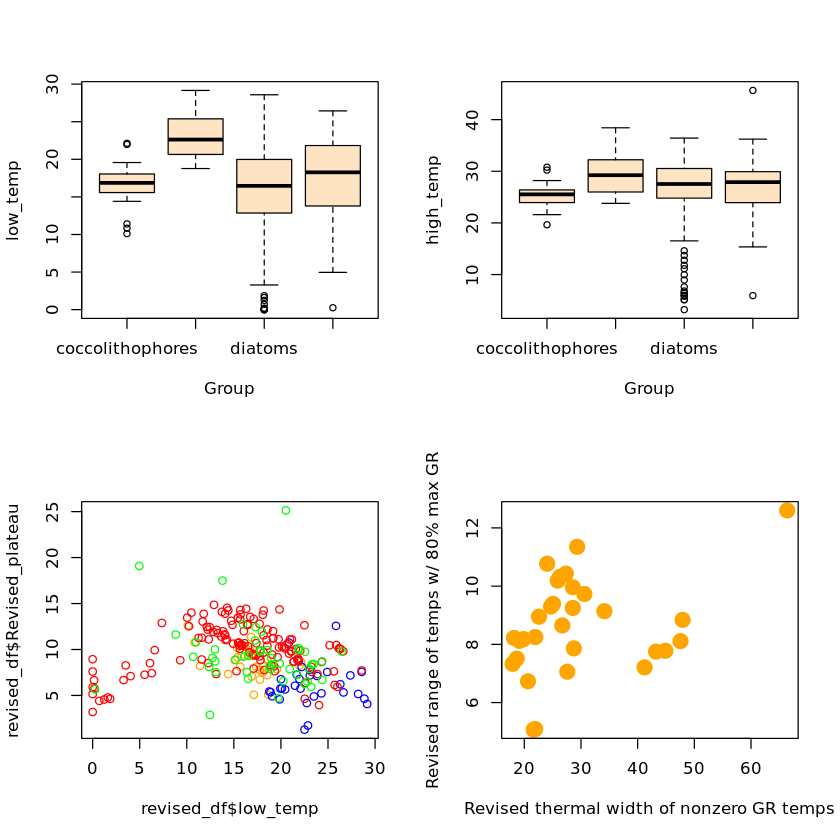

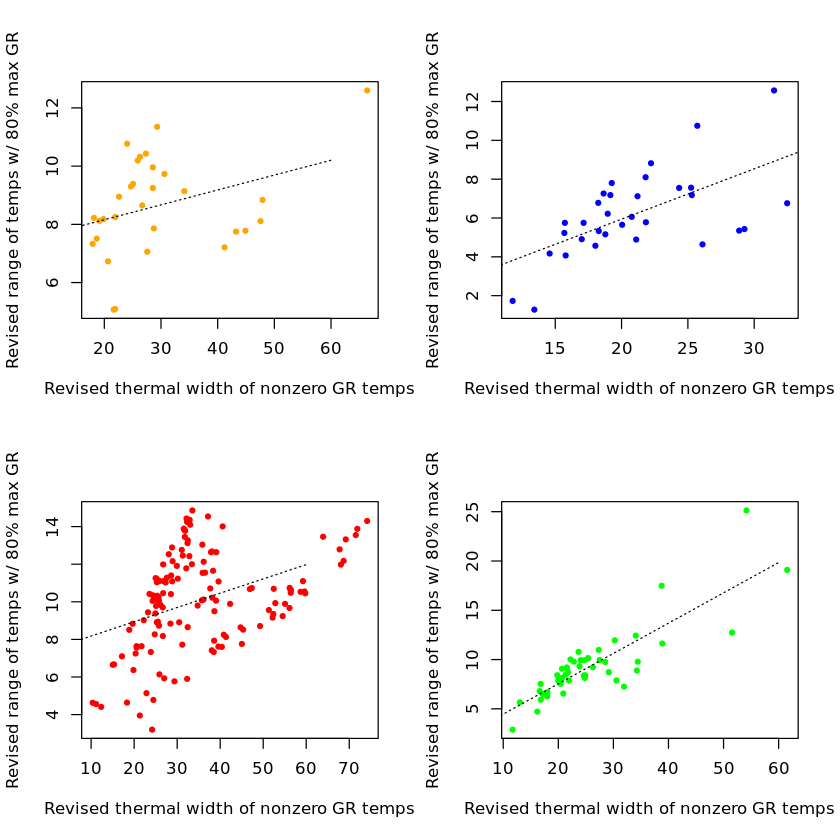

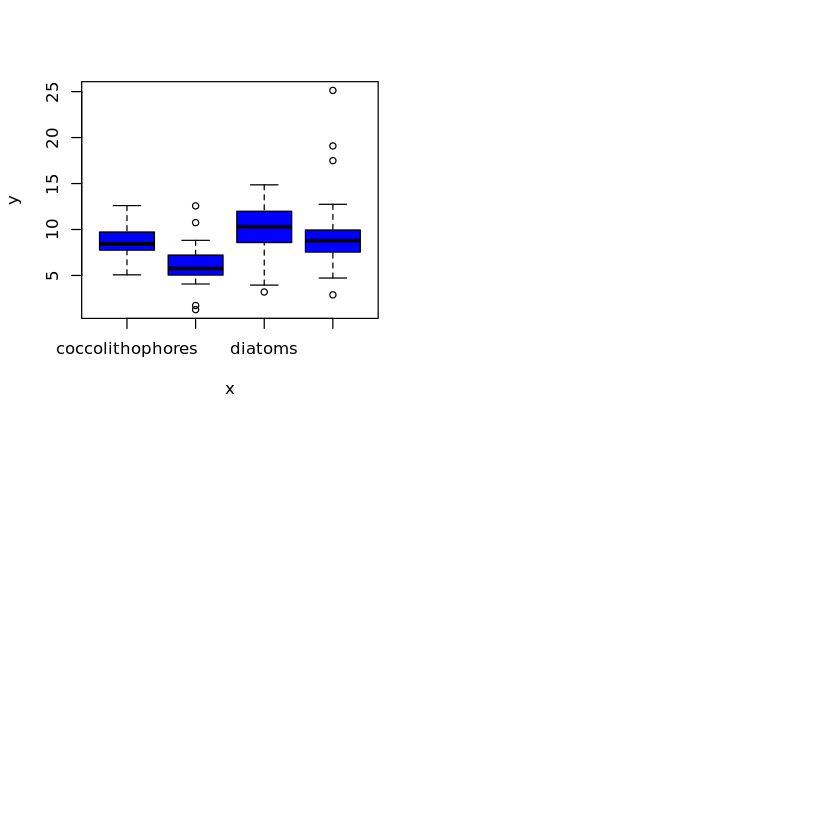

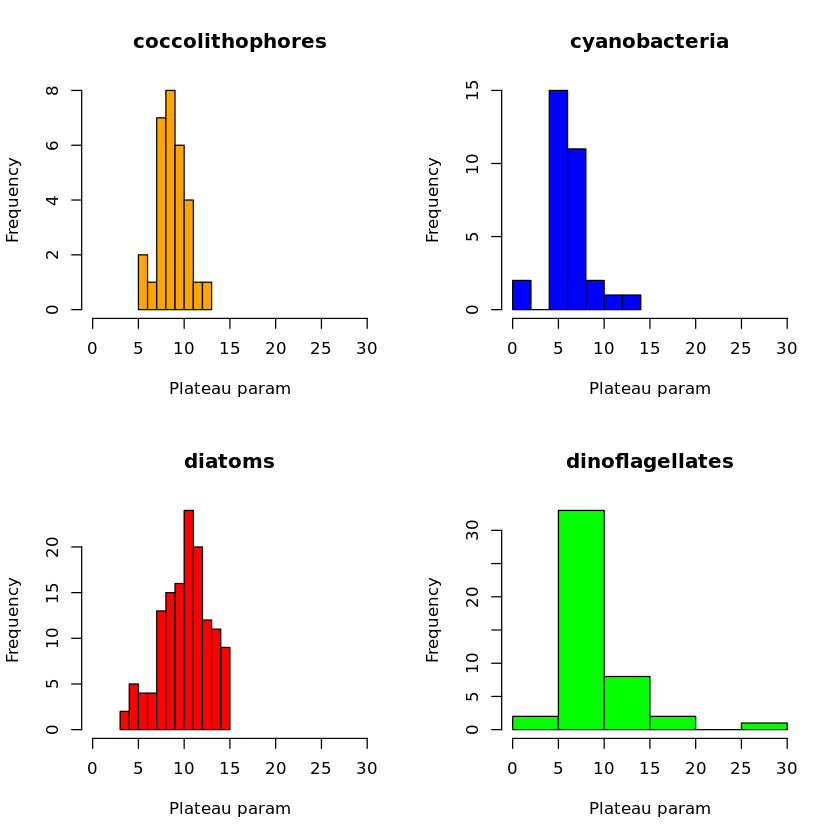

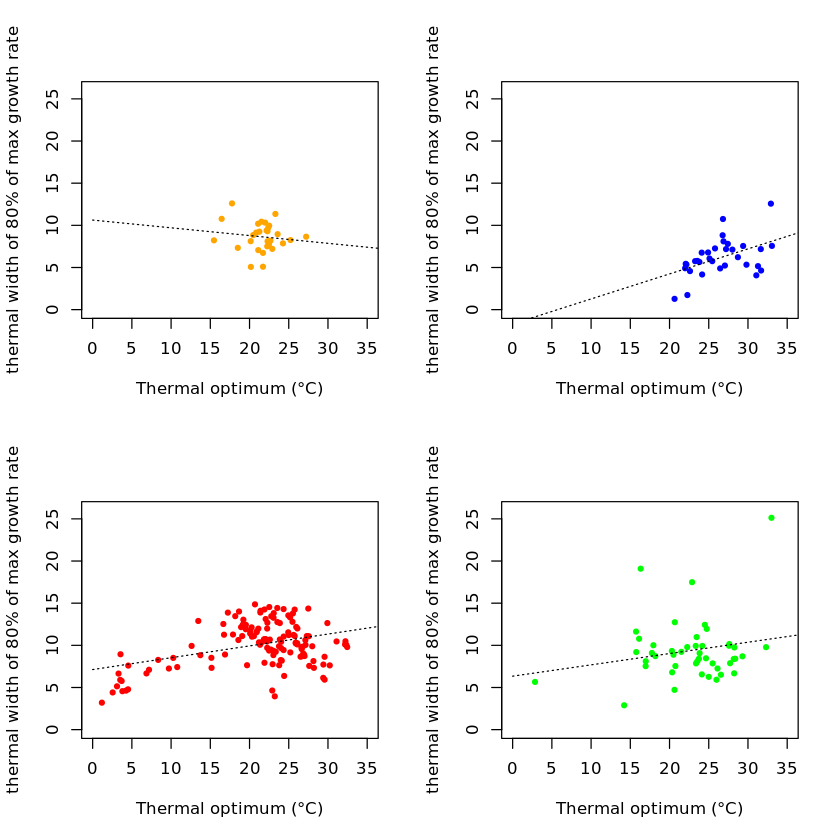

[1] "diatoms"

Call:
lm(formula = Revised_plateau ~ t_opt, data = revised_df[revised_df$Group == 
    group, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-6.4344 -1.5458 -0.0578  1.7630  4.8299 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  7.12529    0.63979  11.137  < 2e-16 ***
t_opt        0.14037    0.02849   4.926 2.44e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.39 on 133 degrees of freedom
Multiple R-squared:  0.1543,	Adjusted R-squared:  0.148 
F-statistic: 24.27 on 1 and 133 DF,  p-value: 2.444e-06

[1] "cyanobacteria"

Call:
lm(formula = Revised_plateau ~ t_opt, data = revised_df[revised_df$Group == 
    group, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-3.4540 -1.1446  0.2947  0.8730  4.4948 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -1.7000     2.6901  -0.632  0.53222   
t_opt         0.2969     0.1007   2.950  0.00612 **

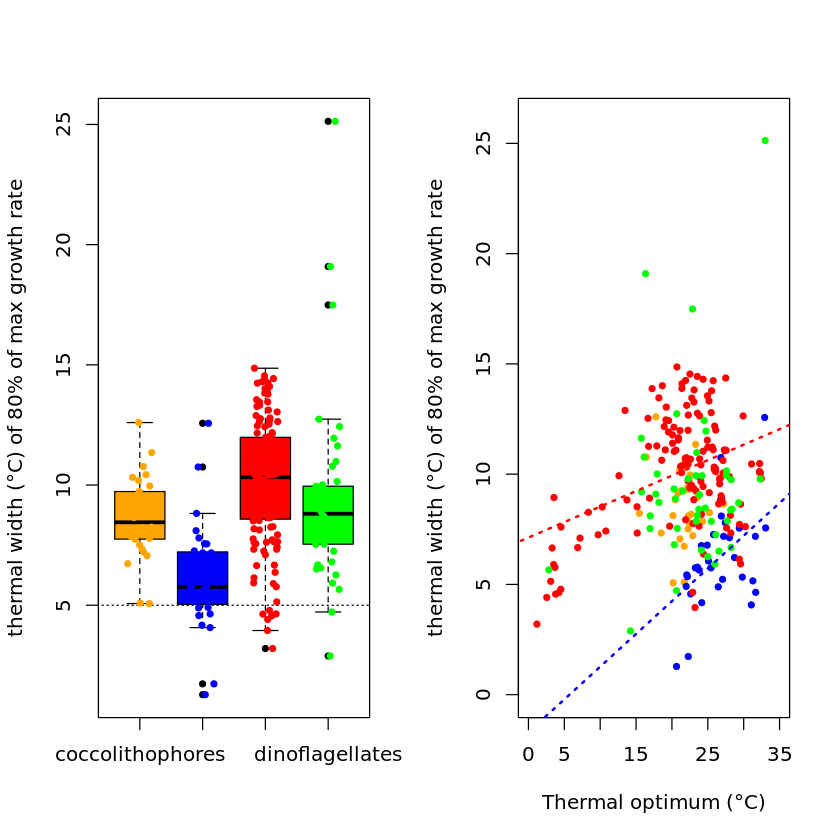

In [6]:
## Norberg curve parameterization
nbcurve <- function(x,opt,w,a,b){
  res<-a*exp(b*x)*(1-((x-opt)/(w/2))^2)
  res
}

# Read in data
derived_traits<-read.csv("../../data/PFT_thermal_response/data/derived_traits.csv")
gr_fr<-read.csv("../../data/PFT_thermal_response/data/growth_rates.csv")
derived_traits_merge<-merge(derived_traits,gr_fr,by="isolate.code")

plot(seq(-10,30,by=1),nbcurve(seq(-10,30,by=1),
                              derived_traits[1,"mu.c.opt.list"],
                              derived_traits[1,"mu.wlist"],
                              derived_traits[1,"mu.alist"],
                              derived_traits[1,"mu.blist"]))
recalculate=FALSE
revised_df=data.frame()
for (curr in c(1:nrow(derived_traits))) {
  strain_curr=paste(derived_traits[curr,"genus"],
                    derived_traits[curr,"species"],
               derived_traits[curr,"strain"],sep="_")
  group_curr=derived_traits[curr,"group"]
  if (length(group_curr)==0) {
    group_curr="unknown"
  }
  a=derived_traits[curr,"mu.alist"]
  b=derived_traits[curr,"mu.blist"]
  w=derived_traits[curr,"mu.wlist"]
  opt=derived_traits[curr,"mu.c.opt.list"]
  opt_val = optimize(nbcurve,interval=c(-20,40),maximum=TRUE,
                     a=derived_traits[curr,"mu.alist"],
                     b=derived_traits[curr,"mu.blist"],
                     w=derived_traits[curr,"mu.wlist"],
                     opt=opt)$maximum
  if (abs(opt_val) > 100) {
    next # these original parameterizations were bad.
  }
  wid_eq_1 = derived_traits[curr,"mu.wlist"]/2+
    opt
  wid_eq_2 = -derived_traits[curr,"mu.wlist"]/2+
    opt
  tol_gr=0.01 ## we don't want to say the width is valid when GR<this
  test_temp=wid_eq_1
  while ((nbcurve(test_temp,opt,w,a,b) < tol_gr)) {
    test_temp=test_temp+sign(test_temp)*-0.001
  }
  wid_eq_1=test_temp
  test_temp=wid_eq_2
  while ((nbcurve(test_temp,opt,w,a,b) < tol_gr)) {
    test_temp=test_temp+sign(test_temp-wid_eq_1)*-0.001
  }
  wid_eq_2=test_temp
  
  if (recalculate) {
    wid_eq_1 = (derived_traits[curr,"mu.wlist"])/2+
      opt_val
    wid_eq_2 = -(derived_traits[curr,"mu.wlist"])/2+
      opt_val
  }
  tolerance_val=nbcurve(opt_val,opt,w,a,b)*0.8
  temps_test=seq(from = wid_eq_2+sign(wid_eq_2)*wid_eq_2*0.5, 
                 to = wid_eq_1+sign(wid_eq_2)*wid_eq_2*0.5, by = 0.01)
  window_1 = -100
  window_2 = -100
  print(paste0(tolerance_val,"; window",window_1," to ",window_2,"; strain:",strain_curr))
  for (temp in temps_test) {
    if ((window_1<0)&(window_2<0)&(nbcurve(temp,opt,w,a,b) >= tolerance_val)) {
      window_1 = temp
    }else if ((window_2<0)&(window_1>0)&(nbcurve(temp,opt,w,a,b) <= tolerance_val)){
      window_2=temp
    }
  }
  if ((window_1==-100)|(window_2==-100)){
    print("broken")
    break
  }
  if (abs(wid_eq_2-wid_eq_1) > 50) {
    print("broken")
    #break
  }
  revised_df = rbind(revised_df,
                     data.frame(Strain=strain_curr,Revised_opt=opt_val,
                                Group=group_curr,
                                Revised_wid=abs(wid_eq_2-wid_eq_1),
                                Revised_plateau=abs(window_1-window_2),
                                low_temp=window_1,high_temp=window_2,
                                max_GR=nbcurve(opt_val,opt,w,a,b),
                                t_opt=opt_val,a=a,b=b,w=w))
}
# calculate plateau parameter for input data
revised_df$left_plateau=revised_df$t_opt-revised_df$low_temp
revised_df$right_plateau=revised_df$high_temp-revised_df$t_opt

par(mfrow=c(2,2))
for (group in unique(revised_df$Group)) {
  
  plot(x=revised_df[!is.na(revised_df$right_plateau)&
                      !is.na(revised_df$Strain)&(revised_df$Group==group),"left_plateau"],
       y=revised_df[!is.na(revised_df$right_plateau)&
                      !is.na(revised_df$Strain)&(revised_df$Group==group),"right_plateau"],
       pch=20,cex=3,
       col=revised_df[!is.na(revised_df$right_plateau)&
                        !is.na(revised_df$Strain)&(revised_df$Group==group),"Color"],
       ylab="right plateau",
       xlab="left plateau")
  lines(seq(0,15,by=1),seq(0,15,by=1),lty="dotted")
}

plot(seq(wid_eq_2,wid_eq_1,by=1),nbcurve(seq(wid_eq_2,wid_eq_1,by=1),
                              opt,
                              derived_traits[curr,"mu.wlist"],
                              derived_traits[curr,"mu.alist"],
                              derived_traits[curr,"mu.blist"]))


color_frame=data.frame("Group"=c("diatoms","coccolithophores",
                                 "dinoflagellates","cyanobacteria"),
                       "Color"=c("red","orange","green","blue"))
revised_df=merge(revised_df,color_frame)
plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"t_opt"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"max_GR"],
     pch=20,cex=3,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain),"Color"],
     ylab="Revised range of temps w/ 80% max GR",
     xlab="Revised thermal width of nonzero GR temps")
for (group in unique(revised_df$Group)) {
  plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"t_opt"],
       y=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"max_GR"],
       pch=20,
       col=revised_df[!is.na(revised_df$Revised_plateau)&
                        !is.na(revised_df$Strain)&
                        revised_df$Group==group,"Color"],
       ylab="Revised range of temps w/ 80% max GR",
       xlab="Revised thermal width of nonzero GR temps")
  cocco_model=summary(lm(formula = max_GR~t_opt+t_opt*t_opt,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["Revised_wid","Estimate"]
  lines(seq(0,60,by=1),seq(0,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted")
}

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Revised_wid"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Revised_plateau"],
     pch=20,cex=3,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"Color"],
     ylab="Revised range of temps w/ 80% max GR",
     xlab="Revised thermal width of nonzero GR temps")
boxplot(x=factor(revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Strain"]),
        y=revised_df[!is.na(revised_df$Revised_plateau)&
                       !is.na(revised_df$Strain),"Revised_plateau"])
boxplot(Revised_plateau ~ Group, data = revised_df, 
        col = unique(revised_df$Color),pch=20,
        xlab="",ylab="Range (°C) of temperatures within 80% of max GR")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,col=revised_df$Color,pch=20)
boxplot(low_temp ~ Group, data = revised_df, col = "bisque")
boxplot(high_temp ~ Group, data = revised_df, col = "bisque")

boxplot(Revised_wid ~ Group, data = revised_df, 
        col = unique(revised_df$Color),pch=20,
        xlab="",ylab="Range (°C) of temperatures within 80% of max GR")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,col=revised_df$Color,pch=20)
boxplot(low_temp ~ Group, data = revised_df, col = "bisque")
boxplot(high_temp ~ Group, data = revised_df, col = "bisque")

summary(lm(formula = Revised_plateau~Revised_wid,
   data = revised_df[revised_df$Group=="coccolithophores",]))
summary(lm(formula = Revised_plateau~Revised_wid,
           data = revised_df[revised_df$Group=="diatoms",]))
summary(lm(formula = Revised_plateau~Revised_wid,
           data = revised_df[revised_df$Group=="dinoflagellates",]))
plot(x=revised_df$low_temp,y=revised_df$Revised_plateau,
     col=revised_df$Color)

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain)&
                    (revised_df$Group=="coccolithophores"),"Revised_wid"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain)&
                    (revised_df$Group=="coccolithophores"),"Revised_plateau"],
     pch=20,cex=3,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain)&
                    (revised_df$Group=="coccolithophores"),"Color"],
     ylab="Revised range of temps w/ 80% max GR",
     xlab="Revised thermal width of nonzero GR temps")


for (group in unique(revised_df$Group)) {
  plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"Revised_wid"],
       y=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"Revised_plateau"],
       pch=20,
       col=revised_df[!is.na(revised_df$Revised_plateau)&
                        !is.na(revised_df$Strain)&
                        revised_df$Group==group,"Color"],
       ylab="Revised range of temps w/ 80% max GR",
       xlab="Revised thermal width of nonzero GR temps")
  cocco_model=summary(lm(formula = Revised_plateau~Revised_wid,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["Revised_wid","Estimate"]
  lines(seq(0,60,by=1),seq(0,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted")
}

plot(y=as.numeric(revised_df$Revised_plateau),x=factor(revised_df$Group),
        col="blue")
par(mfrow=c(2,2))
for (group in unique(revised_df$Group)) {
  hist(x=revised_df[revised_df$Group==group,"Revised_plateau"],
       col =revised_df[revised_df$Group==group,"Color"],xlab="Plateau param",
       main=group,xlim=c(0,30))

}

par(mfrow=c(2,2))
for (group in unique(revised_df$Group)) {
  plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"t_opt"],
       y=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain)&
                      revised_df$Group==group,"Revised_plateau"],
       pch=20,
       col=revised_df[!is.na(revised_df$Revised_plateau)&
                        !is.na(revised_df$Strain)&
                        revised_df$Group==group,"Color"],
       ylab="thermal width of 80% of max growth rate",
       xlab="Thermal optimum (°C)",ylim=c(0,26),xlim=c(0,35))
  dev.hold()
  cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                         data = revised_df[revised_df$Group==group,]))
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["t_opt","Estimate"]
  lines(seq(0,60,by=1),seq(0,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted")
}
par(mfrow=c(1,2))

boxplot(Revised_plateau ~ Group, data = revised_df, 
        col = unique(revised_df$Color),pch=20,
        xlab="",ylab="thermal width (°C) of 80% of max growth rate")
lines(y=rep(5,9),x=c(0:8),lty="dotted")
points(x=jitter(as.numeric(factor(revised_df$Group))),
       y=revised_df$Revised_plateau,col=revised_df$Color,pch=20)

plot(x=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"t_opt"],
     y=revised_df[!is.na(revised_df$Revised_plateau)&
                    !is.na(revised_df$Strain),"Revised_plateau"],
     pch=20,
     col=revised_df[!is.na(revised_df$Revised_plateau)&
                      !is.na(revised_df$Strain),"Color"],
     ylab="thermal width (°C) of 80% of max growth rate",
     xlab="Thermal optimum (°C)",ylim=c(0,26),xlim=c(0,35))
for (group in c("diatoms","cyanobacteria")) {#unique(revised_df$Group)) {
  dev.hold()
  cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                         data = revised_df[revised_df$Group==group,]))
  print(group)
  print(cocco_model)
  cocco_intercept=data.frame(cocco_model$coefficients)["(Intercept)","Estimate"]
  cocco_slope=data.frame(cocco_model$coefficients)["t_opt","Estimate"]
  lines(seq(-10,60,by=1),seq(-10,60,by=1)*cocco_slope+cocco_intercept,
        lty="dotted",col=unique(revised_df[revised_df$Group==group,"Color"]),
        lwd=2)
}
cocco_model=summary(lm(formula = Revised_plateau~t_opt,
                       data = revised_df))


## Recalculate parameters from van Dassow et al.

In [7]:
vandassow=read.csv("../../data/Table4_vanDassow.csv")
vandassow=vandassow%>%dplyr::select(Experiment,Strain,Species,
                                    Haplogroup,Growth_Rate_8_deg,Growth_Rate_12_deg,
                                    Growth_Rate_15_deg,Growth_Rate_18_deg,Growth_Rate_21_deg,
                                    Growth_Rate_24_deg,Growth_Rate_27_deg) %>%
    dplyr::mutate_at(colnames(.)[grepl("Growth_Rate",colnames(.))],as.character) %>%
    tidyr::pivot_longer(cols=starts_with("Growth_Rate"),names_to="Temp",values_to="GrowthRate") %>%
    tidyr::separate(Temp,sep="_",into=c("Sep1","Sep2","Temperature","deg")) %>%
    dplyr::mutate(Temperature=as.numeric(Temperature),
                  GrowthRate=as.numeric(trimws(as.character(GrowthRate))))

Warning message:
“There was 1 warning in
`dplyr::mutate()`.
ℹ In argument: `GrowthRate
  =
  as.numeric(trimws(as.character(GrowthRate)))`.
Caused by warning:
! NAs introduced by coercion”


# A tibble: 7 × 9
  Experiment Strain Species  Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>  <chr>    <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA92 E. huxl… I          Grow… Rate            8 deg        0.159
2          1 SEPA92 E. huxl… I          Grow… Rate           12 deg        0.454
3          1 SEPA92 E. huxl… I          Grow… Rate           15 deg        0.5  
4          1 SEPA92 E. huxl… I          Grow… Rate           18 deg        0.835
5          1 SEPA92 E. huxl… I          Grow… Rate           21 deg        1.01 
6          1 SEPA92 E. huxl… I          Grow… Rate           24 deg        0.946
7          1 SEPA92 E. huxl… I          Grow… Rate           27 deg        0.491
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.08092914
[1] "^b"
 [1]  -0.55944061  -0.54374348  -0.52441107  -0.50119376  -0.47384691
 [6]  -0.44213522  -0.40583806  -0.36475560  -0.31871630  -0.26758546
[11]  -0.21127539  -0.14975717  -0.083074

Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.1485812
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


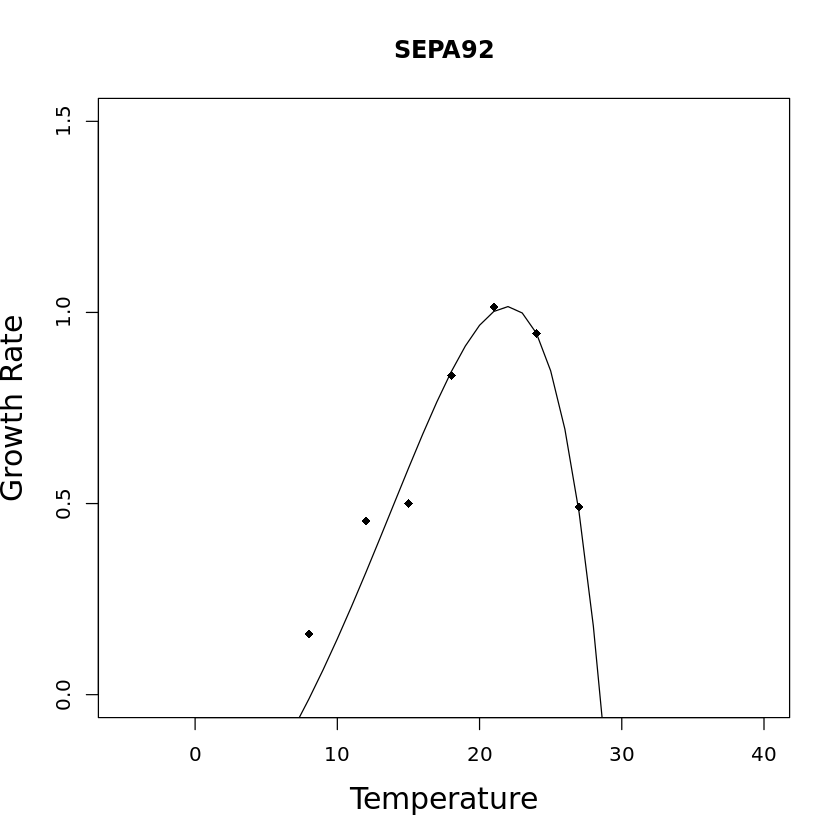

 [1] -1.082262e-01 -1.123444e-01 -1.156932e-01 -1.180308e-01 -1.190751e-01
 [6] -1.185003e-01 -1.159332e-01 -1.109498e-01 -1.030737e-01 -9.177506e-02
[11] -7.647138e-02 -5.653147e-02 -3.128262e-02 -2.286030e-05  3.796041e-02
[16]  8.336330e-02  1.368273e-01  1.988874e-01  2.699013e-01  3.499570e-01
[21]  4.387506e-01  5.354278e-01  6.383804e-01  7.449854e-01  8.512735e-01
[26]  9.515099e-01  1.037667e+00  1.098760e+00  1.120026e+00  1.081885e+00
[31]  9.586693e-01  7.170342e-01  3.140045e-01 -3.054386e-01 -1.211322e+00
[36] -2.492324e+00 -4.260230e+00 -6.655399e+00 -9.853417e+00 -1.407324e+01
[41] -1.958707e+01 -2.673242e+01 -3.592675e+01 -4.768515e+01 -6.264194e+01
[46] -8.157666e+01
[1] "^y"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


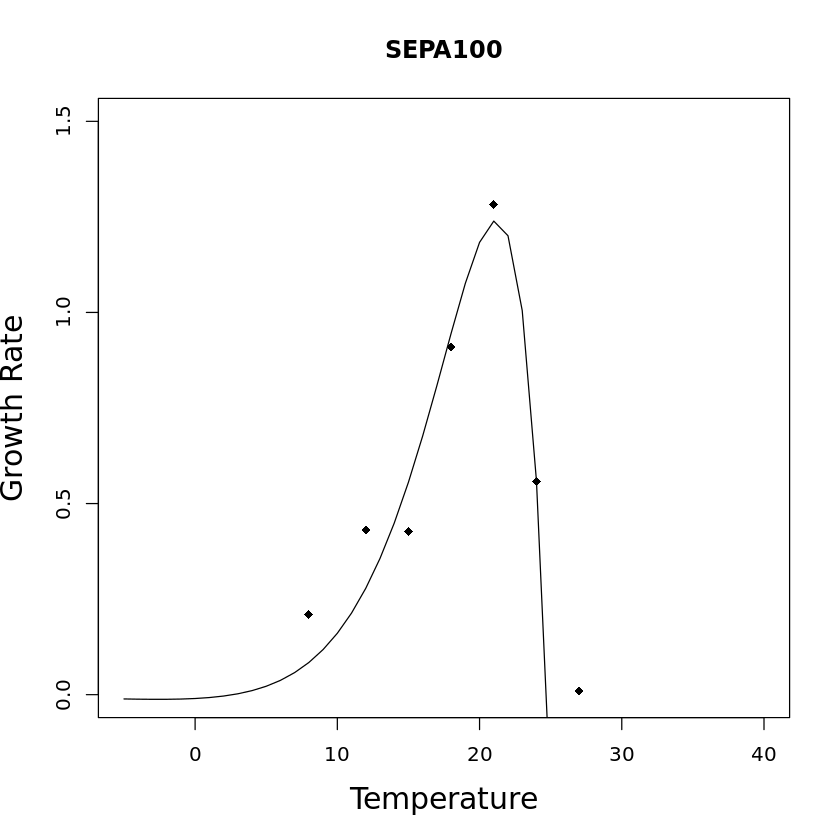

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA340 E. hux… I          Grow… Rate            8 deg        0.093
2          1 SEPA340 E. hux… I          Grow… Rate           12 deg        0.239
3          1 SEPA340 E. hux… I          Grow… Rate           15 deg        0.627
4          1 SEPA340 E. hux… I          Grow… Rate           18 deg        0.781
5          1 SEPA340 E. hux… I          Grow… Rate           21 deg        0.874
6          1 SEPA340 E. hux… I          Grow… Rate           24 deg        0.961
7          1 SEPA340 E. hux… I          Grow… Rate           27 deg        0.333
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.07433877
[1] "^b"
 [1]  -0.79780537  -0.77543416  -0.74874770  -0.71751331  -0.68151124
 [6]  -0.64053988  -0.59442175  -0.54301053  -0.48619913  -0.42392906
[11]  -0.35620114  -0.28308778  -0.204747

Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.07317806
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


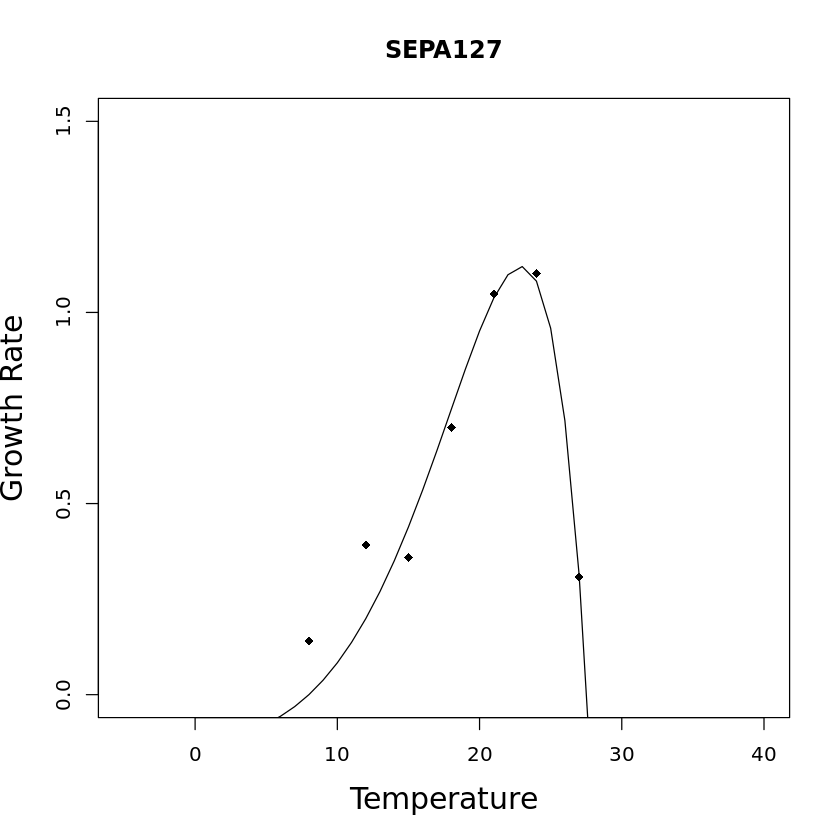

 [1] -4.874795e-01 -4.697024e-01 -4.490060e-01 -4.252463e-01 -3.982888e-01
 [6] -3.680127e-01 -3.343142e-01 -2.971119e-01 -2.563513e-01 -2.120116e-01
[11] -1.641126e-01 -1.127225e-01 -5.796715e-02 -4.060563e-05  6.078326e-02
[16]  1.241373e-01  1.895459e-01  2.564083e-01  3.239786e-01  3.913449e-01
[21]  4.574046e-01  5.208367e-01  5.800718e-01  6.332573e-01  6.782188e-01
[26]  7.124173e-01  7.329010e-01  7.362515e-01  7.185242e-01  6.751809e-01
[31]  6.010160e-01  4.900732e-01  3.355538e-01  1.297141e-01 -1.362486e-01
[36] -4.723219e-01 -8.898187e-01 -1.401533e+00 -2.021910e+00 -2.767242e+00
[41] -3.655874e+00 -4.708441e+00 -5.948127e+00 -7.400949e+00 -9.096076e+00
[46] -1.106618e+01
[1] "^y"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


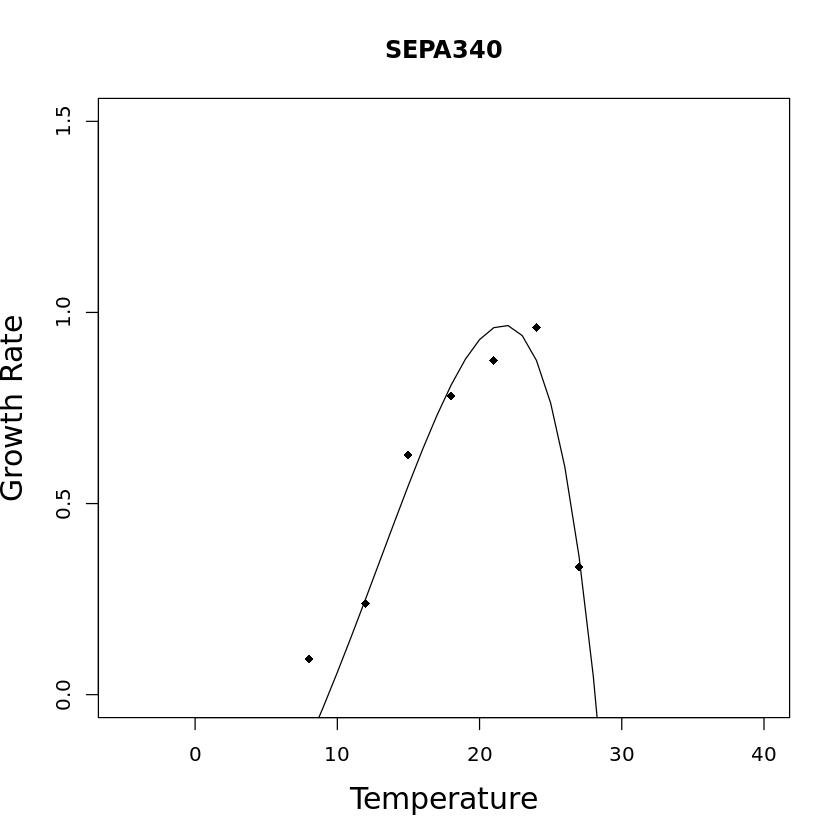

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA350 E. hux… I          Grow… Rate            8 deg        0.075
2          1 SEPA350 E. hux… I          Grow… Rate           12 deg        0.269
3          1 SEPA350 E. hux… I          Grow… Rate           15 deg        0.316
4          1 SEPA350 E. hux… I          Grow… Rate           18 deg        0.747
5          1 SEPA350 E. hux… I          Grow… Rate           21 deg        0.969
6          1 SEPA350 E. hux… I          Grow… Rate           24 deg        0.691
7          1 SEPA350 E. hux… I          Grow… Rate           27 deg        0.527
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.06057673
[1] "^b"
 [1] -1.012622873 -0.974809828 -0.932787640 -0.886456755 -0.835739007
 [6] -0.780581762 -0.720962563 -0.656894338 -0.588431206 -0.515674955
[11] -0.438782262 -0.357972709 -0.2735376

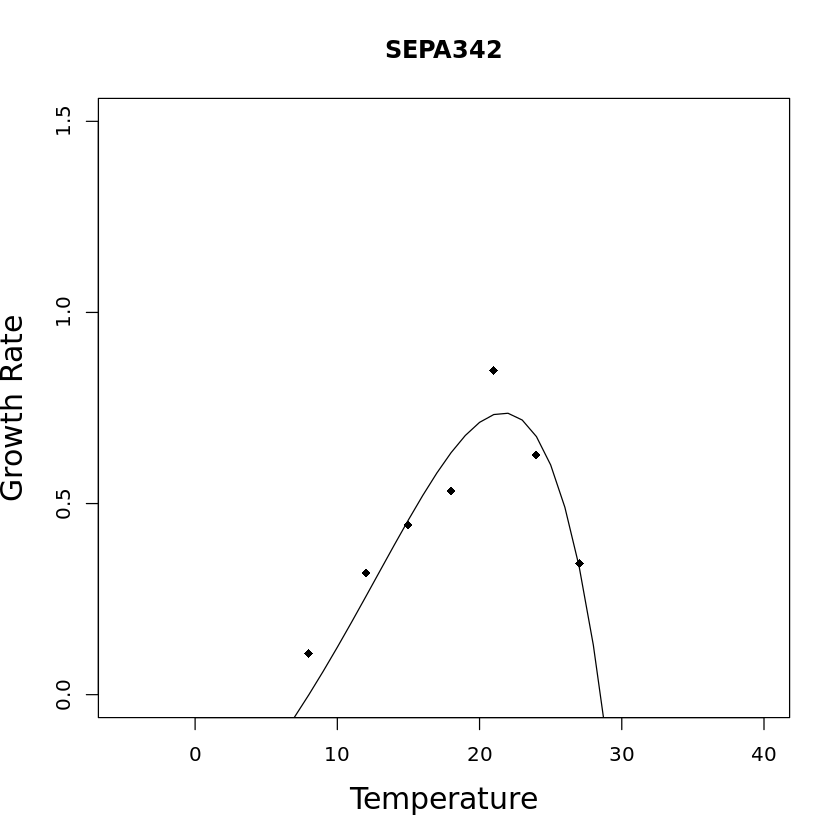

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA118 E. hux… Ib         Grow… Rate            8 deg        0.216
2          1 SEPA118 E. hux… Ib         Grow… Rate           12 deg        0.359
3          1 SEPA118 E. hux… Ib         Grow… Rate           15 deg        0.549
4          1 SEPA118 E. hux… Ib         Grow… Rate           18 deg        0.95 
5          1 SEPA118 E. hux… Ib         Grow… Rate           21 deg        1.23 
6          1 SEPA118 E. hux… Ib         Grow… Rate           24 deg        0.01 
7          1 SEPA118 E. hux… Ib         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.2464282
[1] "^b"
 [1] -3.033446e-03 -2.700358e-03 -2.039852e-03 -9.216716e-04  8.242069e-04
 [6]  3.417535e-03  7.139642e-03  1.234727e-02  1.948839e-02  2.911972e-02
[11]  4.192539e-02  5.873551e-02

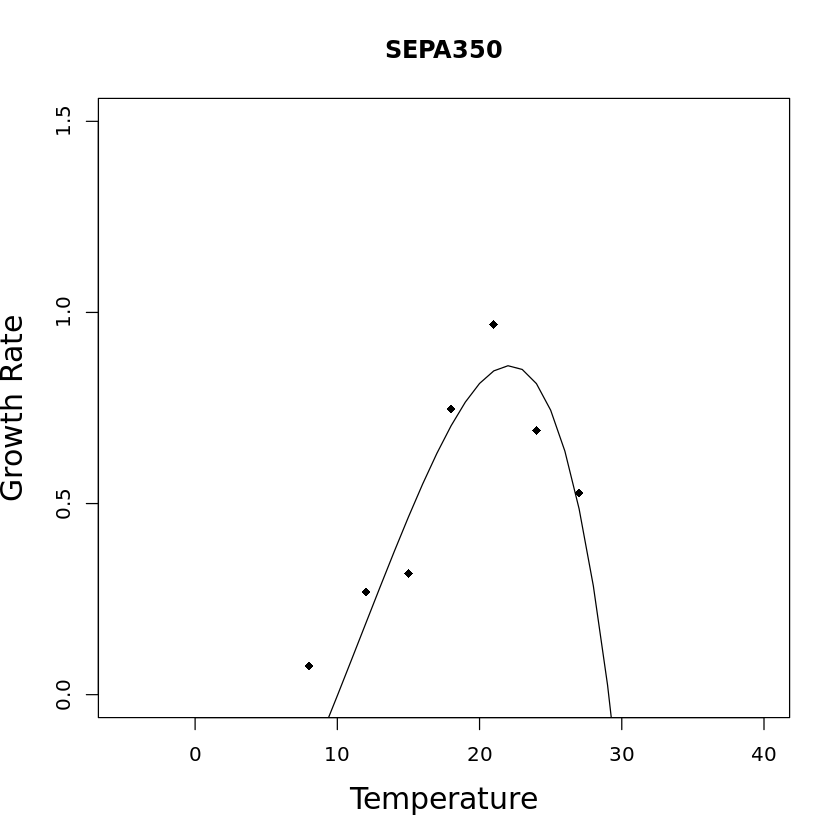

# A tibble: 7 × 9
  Experiment Strain Species  Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>  <chr>    <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA81 E. huxl… II         Grow… Rate            8 deg        0.149
2          1 SEPA81 E. huxl… II         Grow… Rate           12 deg        0.41 
3          1 SEPA81 E. huxl… II         Grow… Rate           15 deg        0.568
4          1 SEPA81 E. huxl… II         Grow… Rate           18 deg        0.619
5          1 SEPA81 E. huxl… II         Grow… Rate           21 deg        0.844
6          1 SEPA81 E. huxl… II         Grow… Rate           24 deg        1.05 
7          1 SEPA81 E. huxl… II         Grow… Rate           27 deg        0.579
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.09146385
[1] "^b"
 [1]  -0.27913623  -0.27134119  -0.26117704  -0.24842282  -0.23285243
 [6]  -0.21423716  -0.19234888  -0.16696401  -0.13786846  -0.10486363
[11]  -0.06777364  -0.02645412   0.019197

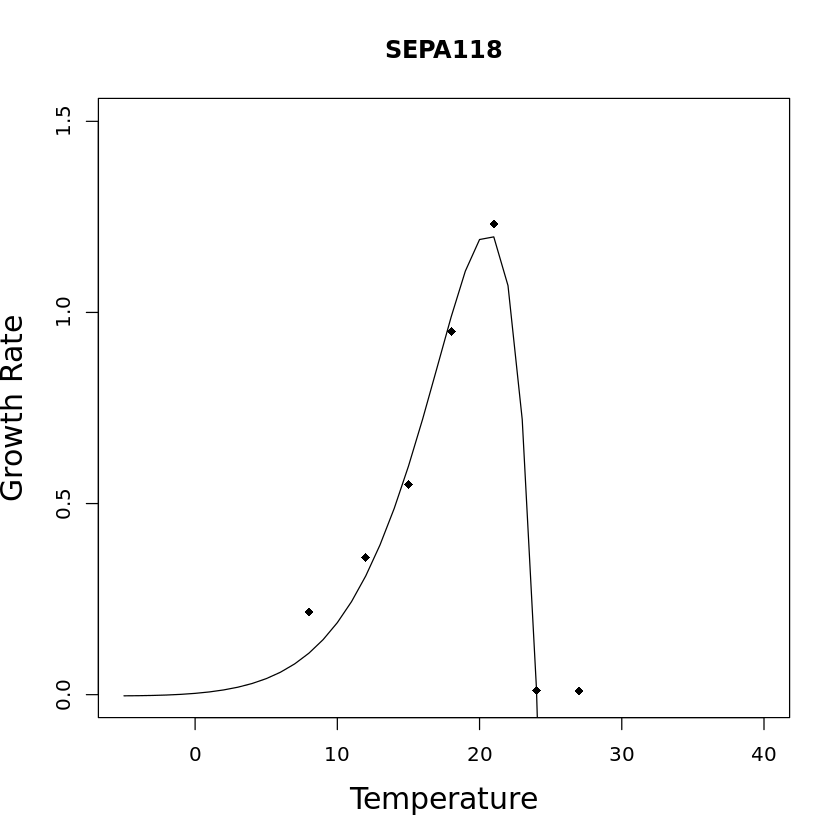

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA341 E. hux… II         Grow… Rate            8 deg        0.22 
2          1 SEPA341 E. hux… II         Grow… Rate           12 deg        0.326
3          1 SEPA341 E. hux… II         Grow… Rate           15 deg        0.282
4          1 SEPA341 E. hux… II         Grow… Rate           18 deg        0.787
5          1 SEPA341 E. hux… II         Grow… Rate           21 deg        0.871
6          1 SEPA341 E. hux… II         Grow… Rate           24 deg        0.925
7          1 SEPA341 E. hux… II         Grow… Rate           27 deg        0.246
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.1309811
[1] "^b"
 [1] -1.509606e-01 -1.539706e-01 -1.557935e-01 -1.561678e-01 -1.548003e-01
 [6] -1.513646e-01 -1.455008e-01 -1.368158e-01 -1.248843e-01 -1.092525e-01
[11] -8.944298e-02 -6.496234e-02

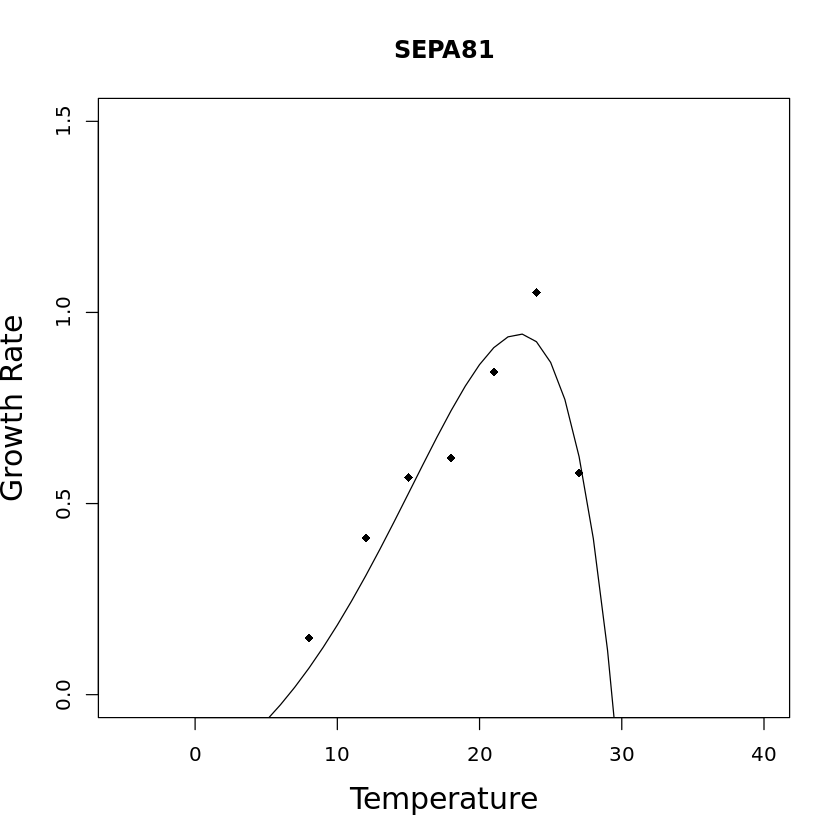

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA365 E. hux… II         Grow… Rate            8 deg        0.03 
2          1 SEPA365 E. hux… II         Grow… Rate           12 deg        0.249
3          1 SEPA365 E. hux… II         Grow… Rate           15 deg        0.547
4          1 SEPA365 E. hux… II         Grow… Rate           18 deg        0.877
5          1 SEPA365 E. hux… II         Grow… Rate           21 deg        0.979
6          1 SEPA365 E. hux… II         Grow… Rate           24 deg        0.935
7          1 SEPA365 E. hux… II         Grow… Rate           27 deg        0.428
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.06738567
[1] "^b"
 [1]  -1.02365389  -0.98997551  -0.95139961  -0.90773967  -0.85883018
 [6]  -0.80453204  -0.74473883  -0.67938383  -0.60844810  -0.53196955
[11]  -0.45005324  -0.36288299  -0.270734

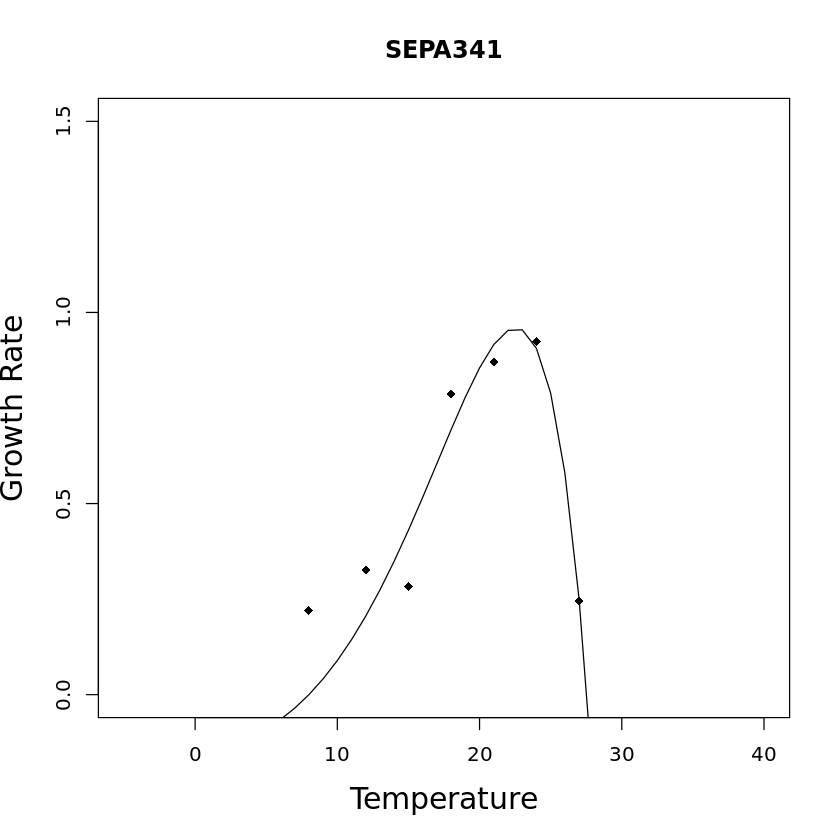

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA373 E. hux… II         Grow… Rate            8 deg        0.074
2          1 SEPA373 E. hux… II         Grow… Rate           12 deg        0.303
3          1 SEPA373 E. hux… II         Grow… Rate           15 deg        0.415
4          1 SEPA373 E. hux… II         Grow… Rate           18 deg        0.505
5          1 SEPA373 E. hux… II         Grow… Rate           21 deg        0.88 
6          1 SEPA373 E. hux… II         Grow… Rate           24 deg        0.82 
7          1 SEPA373 E. hux… II         Grow… Rate           27 deg        0.312
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.1198808
[1] "^b"
 [1] -1.725733e-01 -1.741294e-01 -1.743079e-01 -1.728634e-01 -1.695268e-01
 [6] -1.640056e-01 -1.559844e-01 -1.451272e-01 -1.310793e-01 -1.134724e-01
[11] -9.192992e-02 -6.607585e-02

Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.1387222
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


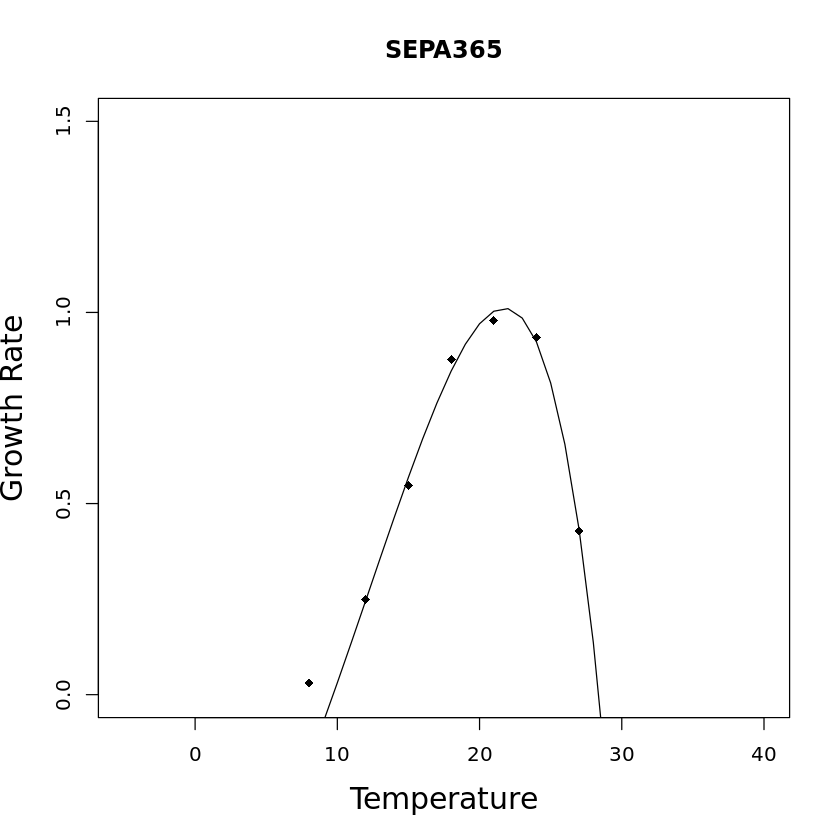

 [1]  -0.118782707  -0.122206128  -0.124758241  -0.126214050  -0.126317284
 [6]  -0.124778500  -0.121273690  -0.115443623  -0.106894233  -0.095198450
[11]  -0.079899986  -0.060519702  -0.036565346  -0.007545659   0.027009929
[16]   0.067524503   0.114337896   0.167659663   0.227507973   0.293631017
[21]   0.365406717   0.441715667   0.520781114   0.599968501   0.675535490
[26]   0.742321526   0.793363723   0.819423162   0.808402435   0.744631426
[31]   0.607993700   0.372860373   0.006791764  -0.531040640  -1.291768698
[36]  -2.339146427  -3.752354046  -5.629383803  -8.091122605 -11.286268430
[41] -15.397243523 -20.647298189 -27.309035523 -35.714630628 -46.268068999
[46] -59.459789239
[1] "^y"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


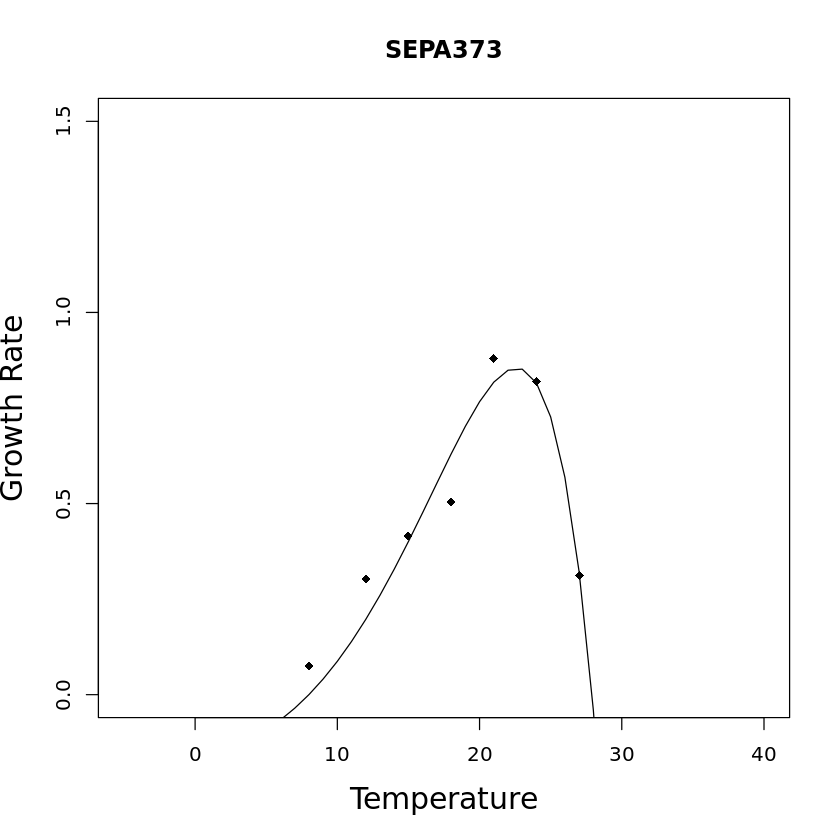

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA528 G. par… I          Grow… Rate            8 deg        0.01 
2          1 SEPA528 G. par… I          Grow… Rate           12 deg        0.099
3          1 SEPA528 G. par… I          Grow… Rate           15 deg        0.182
4          1 SEPA528 G. par… I          Grow… Rate           18 deg        0.515
5          1 SEPA528 G. par… I          Grow… Rate           21 deg        0.891
6          1 SEPA528 G. par… I          Grow… Rate           24 deg        0.934
7          1 SEPA528 G. par… I          Grow… Rate           27 deg        0.468
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.1592309
[1] "^b"
 [1]  -0.09181728  -0.09765981  -0.10327829  -0.10850670  -0.11314308
 [6]  -0.11694466  -0.11962278  -0.12083774  -0.12019391  -0.11723535
[11]  -0.11144240  -0.10222990  -0.0889478

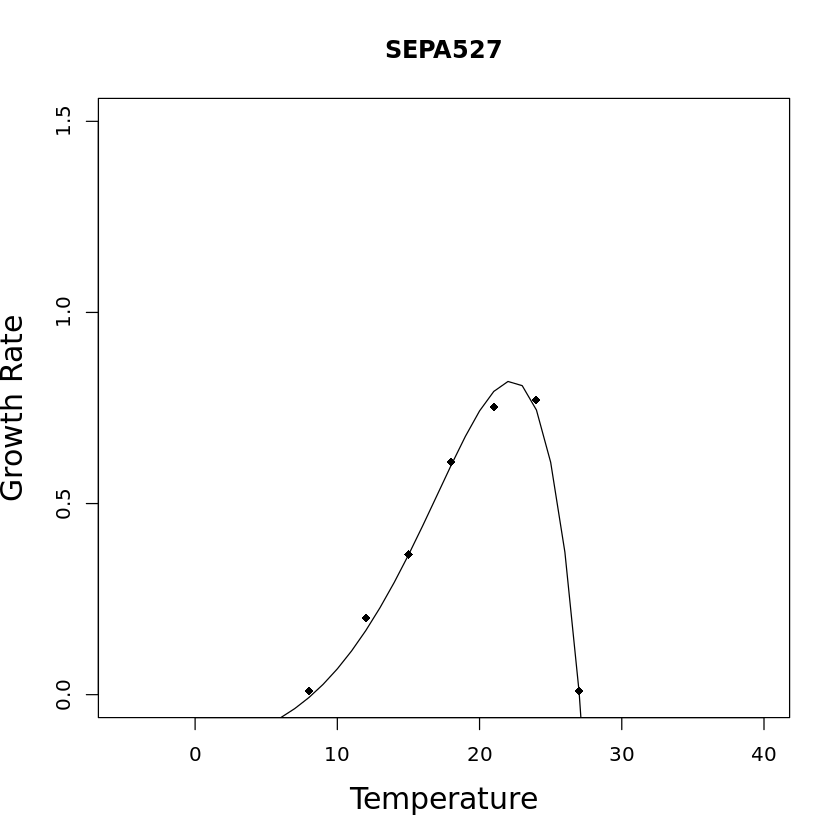

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA529 G. par… I          Grow… Rate            8 deg        0.01 
2          1 SEPA529 G. par… I          Grow… Rate           12 deg        0.197
3          1 SEPA529 G. par… I          Grow… Rate           15 deg        0.5  
4          1 SEPA529 G. par… I          Grow… Rate           18 deg        0.818
5          1 SEPA529 G. par… I          Grow… Rate           21 deg        0.652
6          1 SEPA529 G. par… I          Grow… Rate           24 deg        0.892
7          1 SEPA529 G. par… I          Grow… Rate           27 deg        0.48 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.0333503
[1] "^b"
 [1] -1.91269537 -1.79438273 -1.67356477 -1.55046940 -1.42535175 -1.29849605
 [7] -1.17021764 -1.04086503 -0.91082217 -0.78051078 -0.65039279 -0.52097301
[13] -0.39280186 -0.26647825

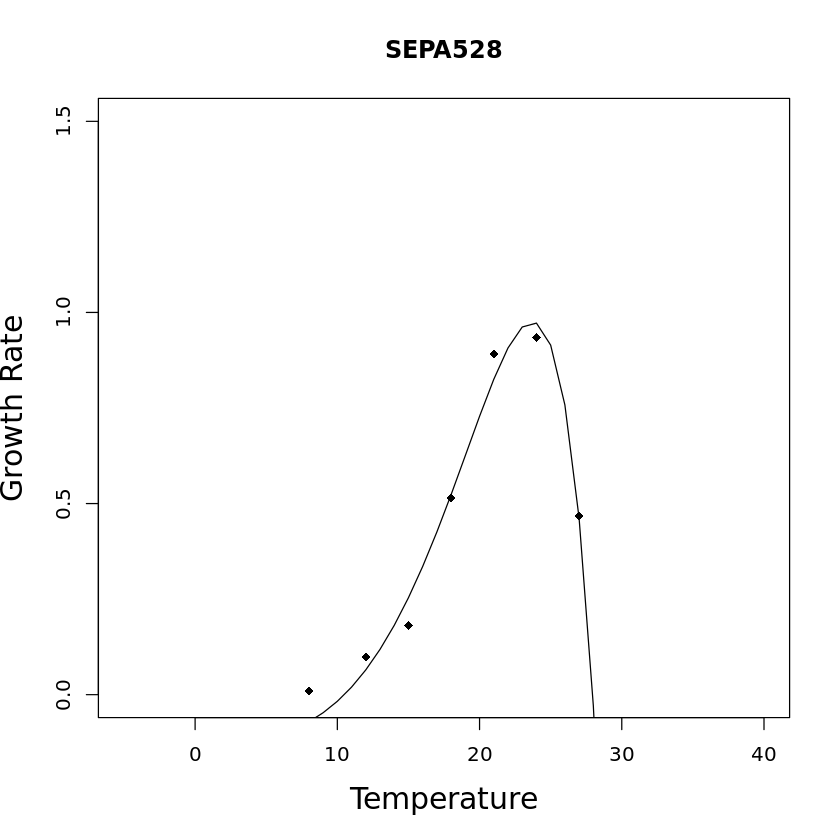

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA530 G. par… I          Grow… Rate            8 deg        0.01 
2          1 SEPA530 G. par… I          Grow… Rate           12 deg        0.193
3          1 SEPA530 G. par… I          Grow… Rate           15 deg        0.276
4          1 SEPA530 G. par… I          Grow… Rate           18 deg        0.756
5          1 SEPA530 G. par… I          Grow… Rate           21 deg        0.886
6          1 SEPA530 G. par… I          Grow… Rate           24 deg        1.02 
7          1 SEPA530 G. par… I          Grow… Rate           27 deg        0.463
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.1286353
[1] "^b"
 [1]  -0.207152710  -0.213079900  -0.217822381  -0.221093055  -0.222568899
 [6]  -0.221889332  -0.218655210  -0.212428678  -0.202734225  -0.189061314
[11]  -0.170869104  -0.147593858

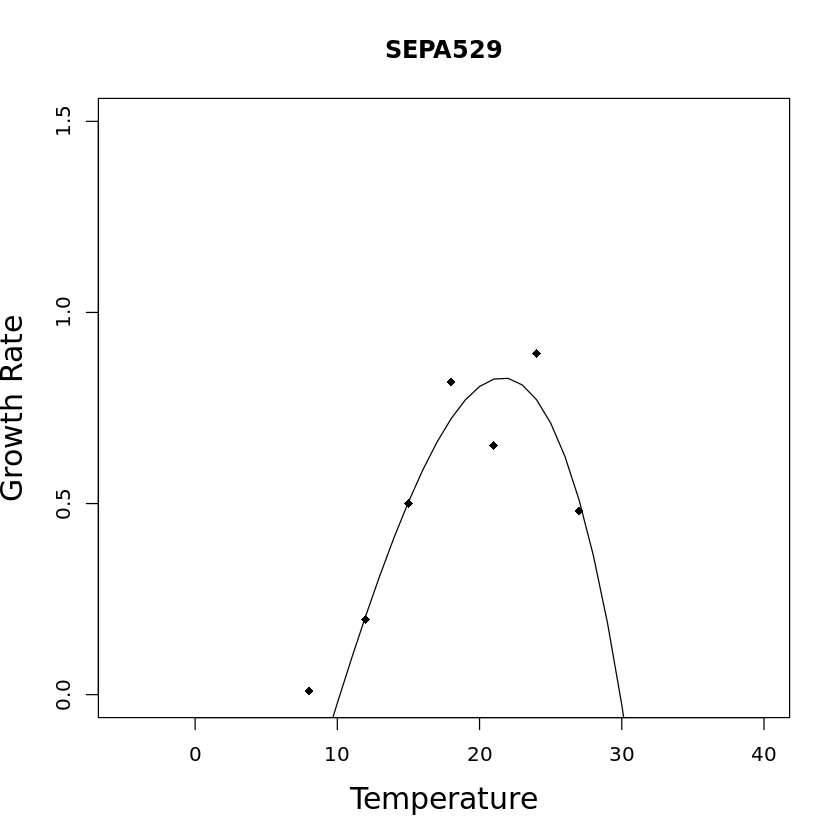

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA516 G. eri… I          Grow… Rate            8 deg        0.01 
2          1 SEPA516 G. eri… I          Grow… Rate           12 deg        0.274
3          1 SEPA516 G. eri… I          Grow… Rate           15 deg        0.387
4          1 SEPA516 G. eri… I          Grow… Rate           18 deg        0.516
5          1 SEPA516 G. eri… I          Grow… Rate           21 deg        0.486
6          1 SEPA516 G. eri… I          Grow… Rate           24 deg        0.632
7          1 SEPA516 G. eri… I          Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.09564023
[1] "^b"
 [1]  -0.270481551  -0.266373414  -0.260269925  -0.251967886  -0.241259057
 [6]  -0.227932770  -0.211779260  -0.192593874  -0.170182304  -0.144367022
[11]  -0.114995146  -0.08194796

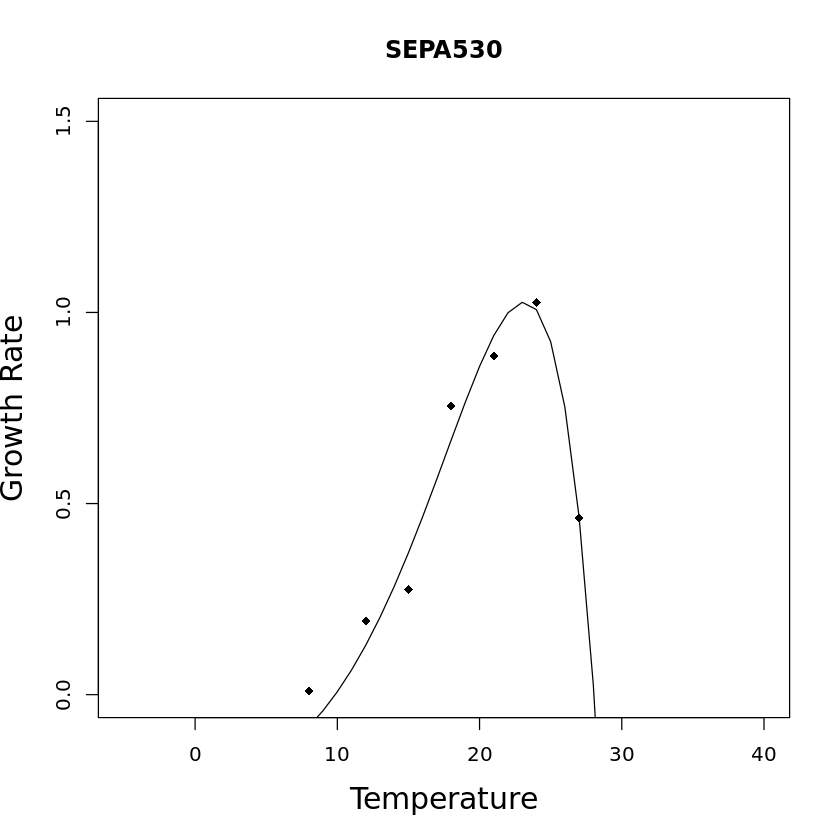

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA184 G. mue… II         Grow… Rate            8 deg        0.306
2          1 SEPA184 G. mue… II         Grow… Rate           12 deg        0.299
3          1 SEPA184 G. mue… II         Grow… Rate           15 deg        0.76 
4          1 SEPA184 G. mue… II         Grow… Rate           18 deg        0.85 
5          1 SEPA184 G. mue… II         Grow… Rate           21 deg        0.682
6          1 SEPA184 G. mue… II         Grow… Rate           24 deg        0.01 
7          1 SEPA184 G. mue… II         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 18

$w
[1] 19

[1] 0.1676789
[1] "^b"
 [1] -4.063040e-02 -3.925384e-02 -3.664031e-02 -3.249720e-02 -2.648692e-02
 [6] -1.822404e-02 -7.273497e-03  6.849378e-03  2.467626e-02  4.677944e-02
[11]  7.376025e-02  1.062303e-01

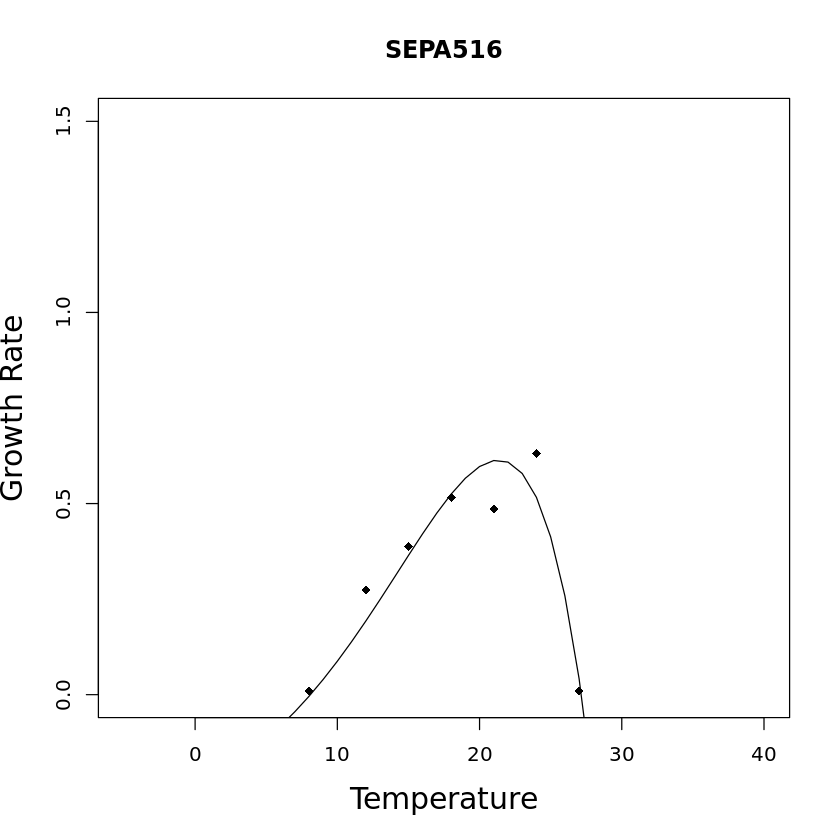

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA194 G. mue… II         Grow… Rate            8 deg        0.224
2          1 SEPA194 G. mue… II         Grow… Rate           12 deg        0.318
3          1 SEPA194 G. mue… II         Grow… Rate           15 deg        0.41 
4          1 SEPA194 G. mue… II         Grow… Rate           18 deg        0.624
5          1 SEPA194 G. mue… II         Grow… Rate           21 deg        0.659
6          1 SEPA194 G. mue… II         Grow… Rate           24 deg        0.01 
7          1 SEPA194 G. mue… II         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.1532945
[1] "^b"
 [1] -5.419968e-02 -5.393809e-02 -5.268923e-02 -5.023040e-02 -4.630833e-02
 [6] -4.063781e-02 -3.290117e-02 -2.274901e-02 -9.802602e-03  6.341312e-03
[11]  2.610249e-02  4.990489e-02

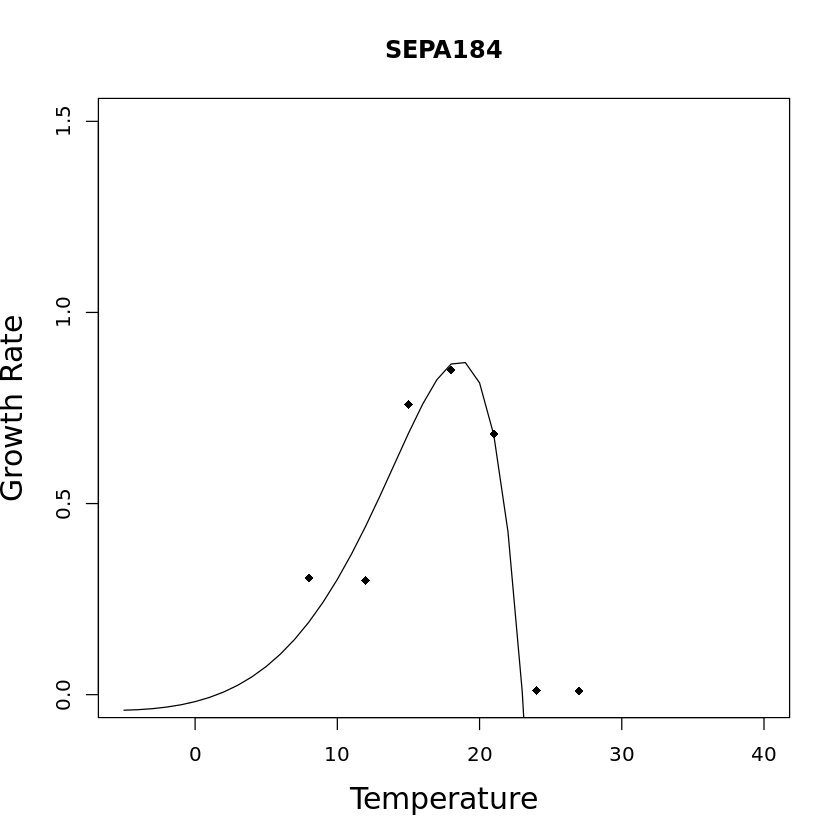

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 SEPA565 G. mue… II         Grow… Rate            8 deg        0.045
2          1 SEPA565 G. mue… II         Grow… Rate           12 deg        0.282
3          1 SEPA565 G. mue… II         Grow… Rate           15 deg        0.309
4          1 SEPA565 G. mue… II         Grow… Rate           18 deg        0.54 
5          1 SEPA565 G. mue… II         Grow… Rate           21 deg        0.281
6          1 SEPA565 G. mue… II         Grow… Rate           24 deg        0.01 
7          1 SEPA565 G. mue… II         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 18

$w
[1] 19

[1] 0.1848093
[1] "^b"
 [1] -4.160064e-02 -4.366343e-02 -4.526806e-02 -4.622846e-02 -4.631917e-02
 [6] -4.527049e-02 -4.276402e-02 -3.842905e-02 -3.184057e-02 -2.251980e-02
[11] -9.938716e-03  6.469607e-03

Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] -0.003349956
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


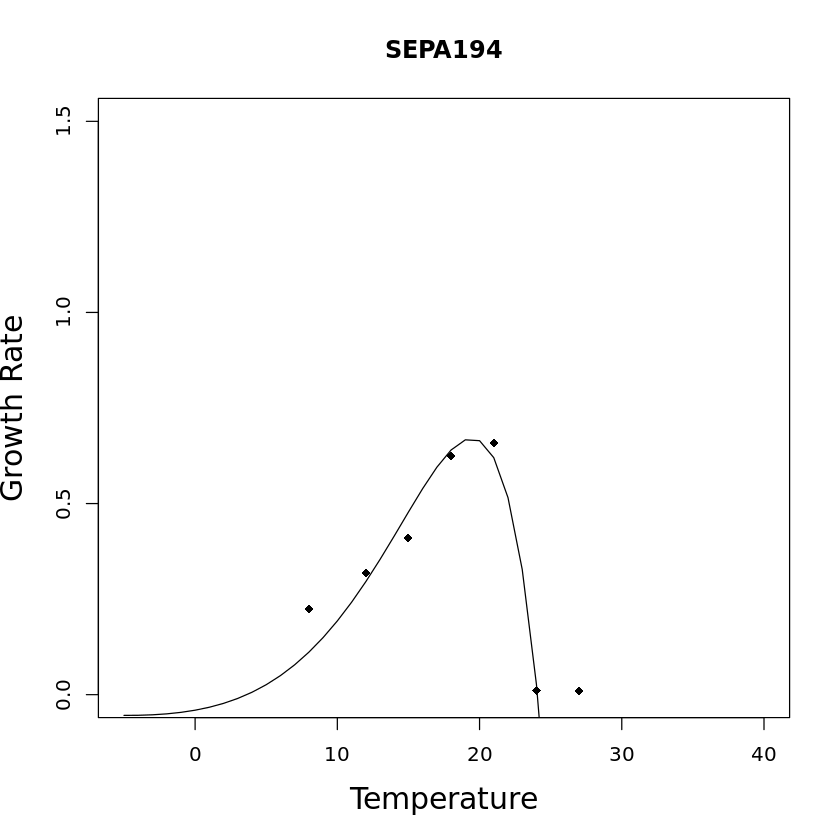

 [1] -4.837026191 -4.412592620 -4.006481153 -3.618522025 -3.248546573
 [6] -2.896387233 -2.561877536 -2.244852095 -1.945146605 -1.662597838
[11] -1.397043630 -1.148322883 -0.916275553 -0.700742648 -0.501566223
[16] -0.318589368 -0.151656209 -0.000611901  0.134697381  0.254424446
[21]  0.358721089  0.447738103  0.521625280  0.580531419  0.624604329
[26]  0.653990836  0.668836790  0.669287067  0.655485577  0.627575269
[31]  0.585698135  0.529995218  0.460606613  0.377671478  0.281328034
[36]  0.171713572  0.048964460 -0.086783854 -0.235396836 -0.396740860
[41] -0.570683206 -0.757092052 -0.955836469 -1.166786418 -1.389812742
[46] -1.624787166
[1] "^y"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


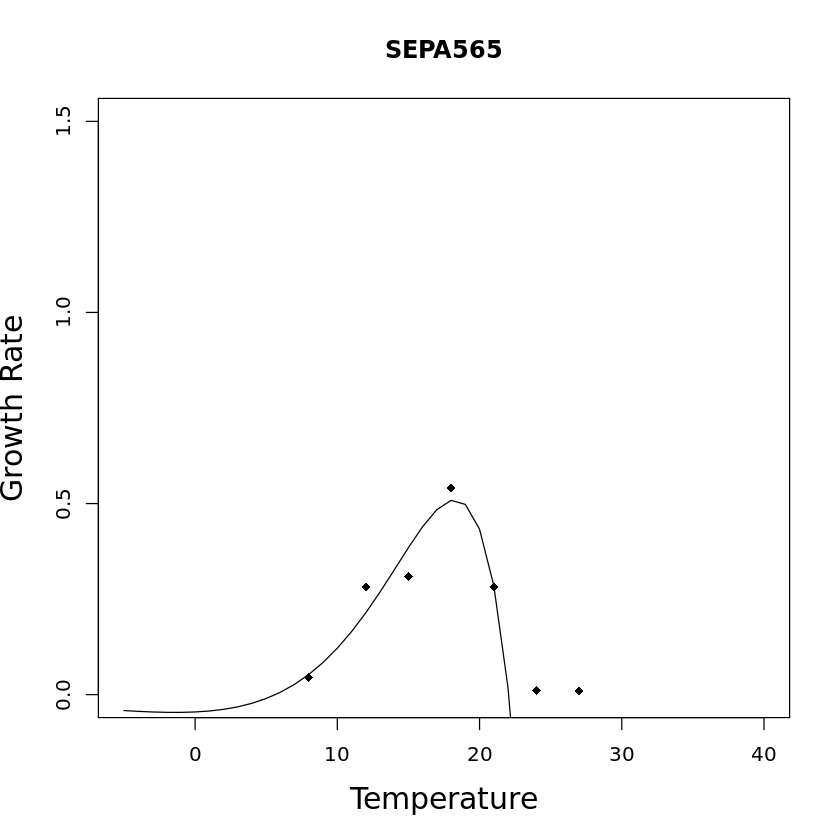

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 RCC1319 G. oce… III        Grow… Rate            8 deg        0.01 
2          1 RCC1319 G. oce… III        Grow… Rate           12 deg        0.381
3          1 RCC1319 G. oce… III        Grow… Rate           15 deg        0.34 
4          1 RCC1319 G. oce… III        Grow… Rate           18 deg        0.556
5          1 RCC1319 G. oce… III        Grow… Rate           21 deg        0.56 
6          1 RCC1319 G. oce… III        Grow… Rate           24 deg        0.721
7          1 RCC1319 G. oce… III        Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.1294672
[1] "^b"
 [1]  -0.08175278  -0.08149710  -0.08024163  -0.07780234  -0.07397552
 [6]  -0.06853750  -0.06124499  -0.05183601  -0.04003192  -0.02554055
[11]  -0.00806104   0.01270939   0.0370660

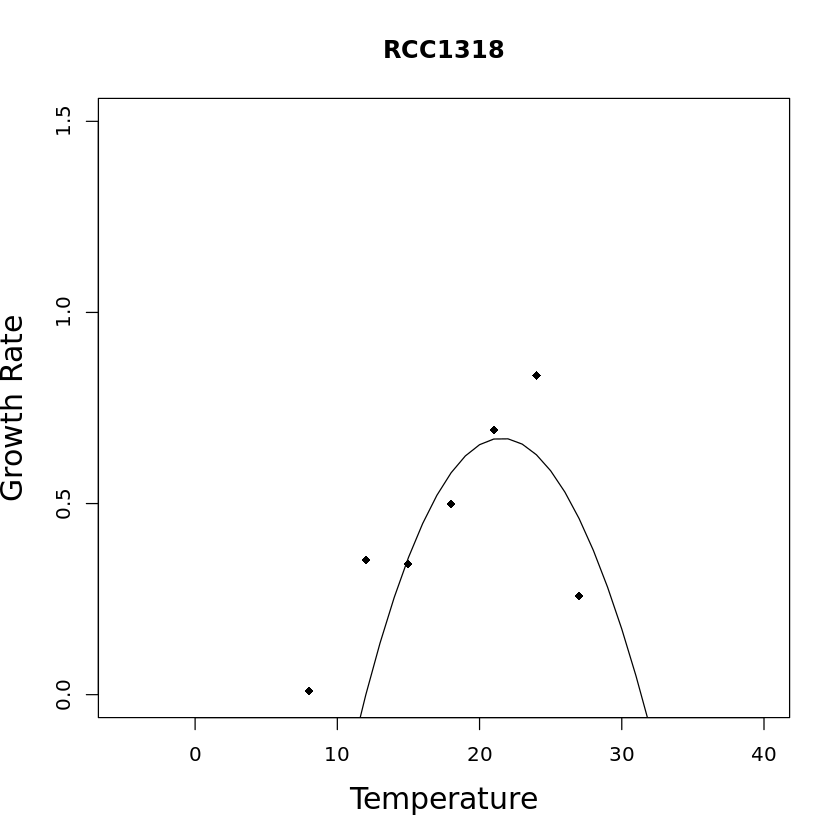

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 RCC1562 G. oce… III        Grow… Rate            8 deg        0.01 
2          1 RCC1562 G. oce… III        Grow… Rate           12 deg        0.01 
3          1 RCC1562 G. oce… III        Grow… Rate           15 deg        0.294
4          1 RCC1562 G. oce… III        Grow… Rate           18 deg        0.573
5          1 RCC1562 G. oce… III        Grow… Rate           21 deg        0.878
6          1 RCC1562 G. oce… III        Grow… Rate           24 deg        0.771
7          1 RCC1562 G. oce… III        Grow… Rate           27 deg        0.789
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.008093281
[1] "^b"
 [1] -4.612269652 -4.276810761 -3.949215455 -3.629744365 -3.318662738
 [6] -3.016240501 -2.722752332 -2.438477717 -2.163701029 -1.898711586
[11] -1.643803729 -1.399276884 -1.165435

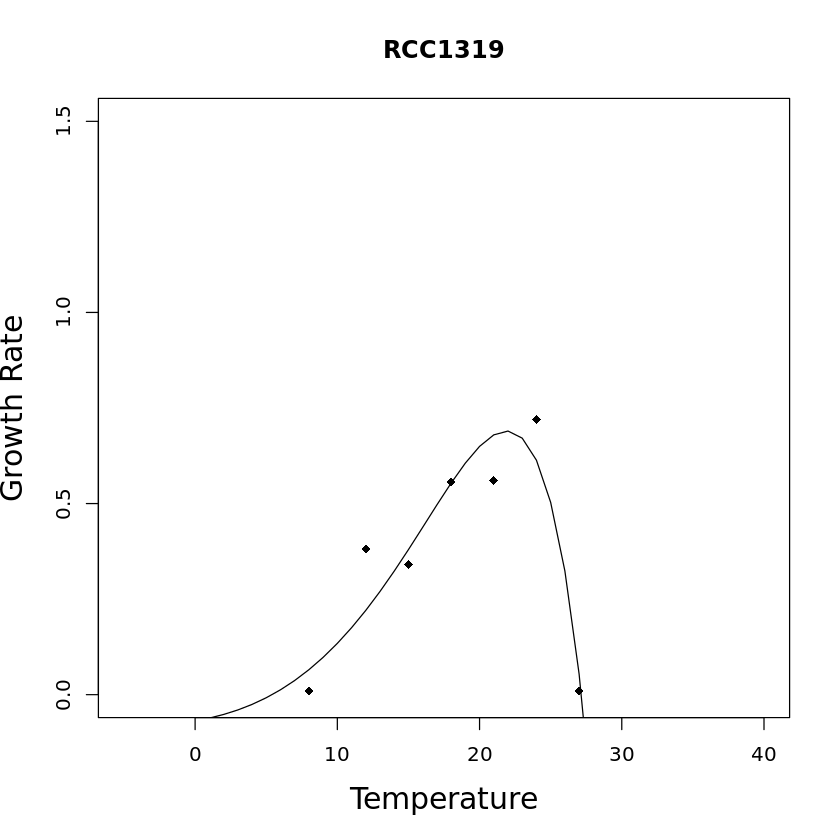

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 RCC1796 G. oce… III        Grow… Rate            8 deg        0.01 
2          1 RCC1796 G. oce… III        Grow… Rate           12 deg        0.075
3          1 RCC1796 G. oce… III        Grow… Rate           15 deg        0.125
4          1 RCC1796 G. oce… III        Grow… Rate           18 deg        0.427
5          1 RCC1796 G. oce… III        Grow… Rate           21 deg        0.924
6          1 RCC1796 G. oce… III        Grow… Rate           24 deg        0.882
7          1 RCC1796 G. oce… III        Grow… Rate           27 deg        0.73 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.04823451
[1] "^b"
 [1] -2.60764419 -2.52136278 -2.42861777 -2.32939772 -2.22372641 -2.11166741
 [7] -1.99332901 -1.86886957 -1.73850344 -1.60250729 -1.46122705 -1.31508548
[13] -1.16459029 -1.0103430

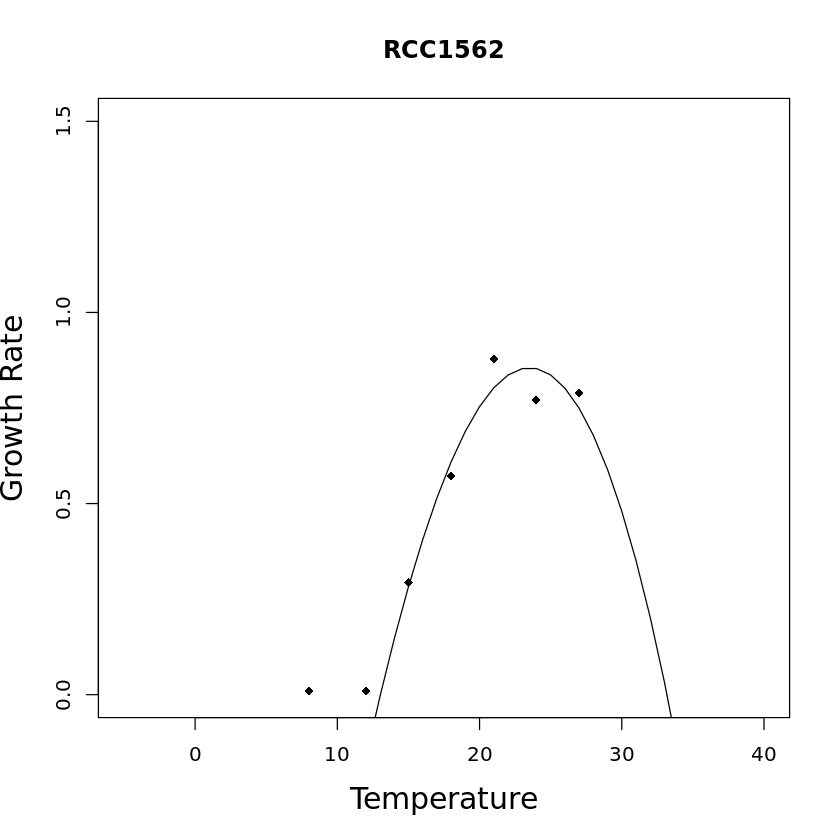

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 RCC1803 G. oce… n/a        Grow… Rate            8 deg        0.01 
2          1 RCC1803 G. oce… n/a        Grow… Rate           12 deg        0.01 
3          1 RCC1803 G. oce… n/a        Grow… Rate           15 deg        0.309
4          1 RCC1803 G. oce… n/a        Grow… Rate           18 deg        0.84 
5          1 RCC1803 G. oce… n/a        Grow… Rate           21 deg        0.757
6          1 RCC1803 G. oce… n/a        Grow… Rate           24 deg        0.815
7          1 RCC1803 G. oce… n/a        Grow… Rate           27 deg        0.294
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 18

$w
[1] 19

[1] -0.005129052
[1] "^b"
 [1] -11.0060942 -10.0479406  -9.1344890  -8.2651270  -7.4392482  -6.6562524
 [7]  -5.9155451  -5.2165378  -4.5586478  -3.9412980  -3.3639173  -2.8259400
[13]  -2.3268062  -1.8659

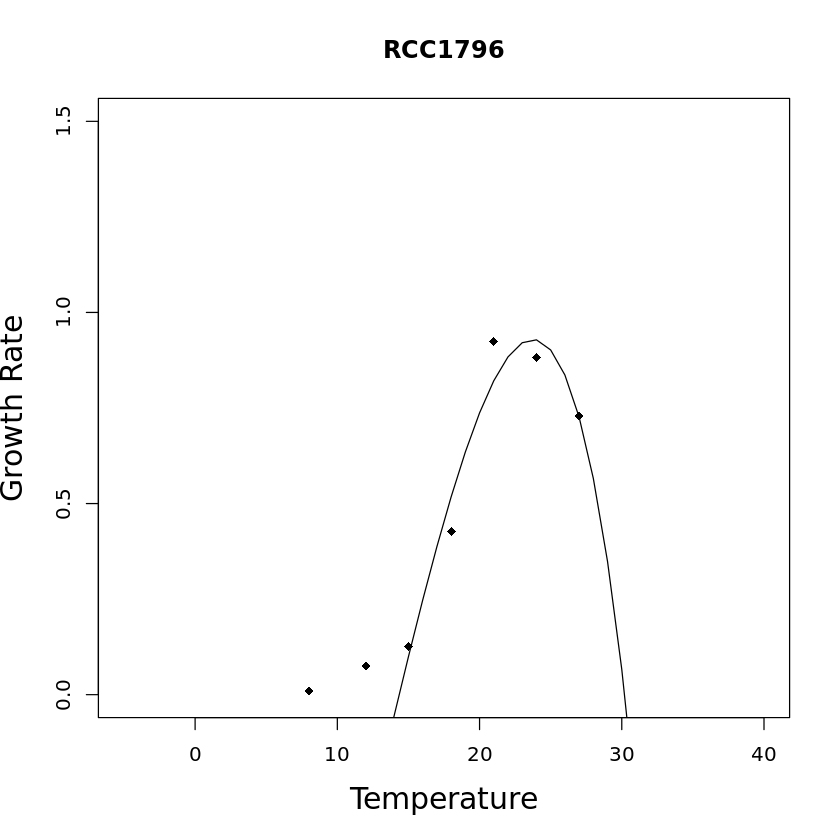

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          1 RCC3729 G. oce… n/a        Grow… Rate            8 deg        0.01 
2          1 RCC3729 G. oce… n/a        Grow… Rate           12 deg        0.01 
3          1 RCC3729 G. oce… n/a        Grow… Rate           15 deg        0.084
4          1 RCC3729 G. oce… n/a        Grow… Rate           18 deg        0.388
5          1 RCC3729 G. oce… n/a        Grow… Rate           21 deg        1.03 
6          1 RCC3729 G. oce… n/a        Grow… Rate           24 deg        0.982
7          1 RCC3729 G. oce… n/a        Grow… Rate           27 deg        0.794
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.06932962
[1] "^b"
 [1]  -1.85995126  -1.83747523  -1.80846839  -1.77255986  -1.72939157
 [6]  -1.67862426  -1.61994461  -1.55307332  -1.47777448  -1.39386633
[11]  -1.30123351  -1.19984108  -1.089750

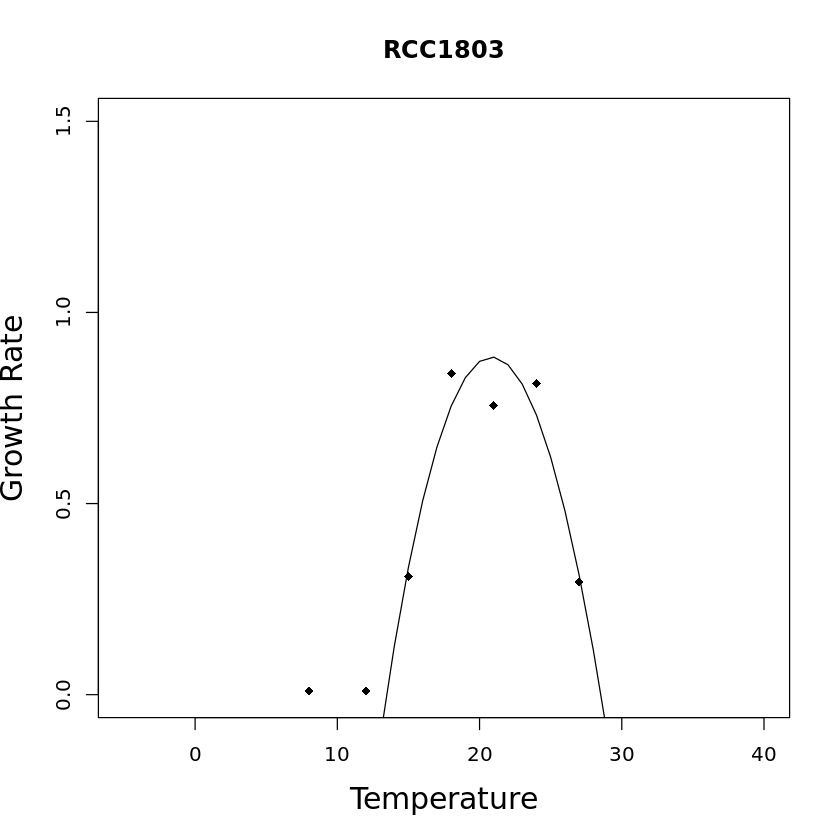

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA551 E. hux… I          Grow… Rate            8 deg        0.155
2          2 SEPA551 E. hux… I          Grow… Rate           12 deg        0.353
3          2 SEPA551 E. hux… I          Grow… Rate           15 deg        0.593
4          2 SEPA551 E. hux… I          Grow… Rate           18 deg        0.647
5          2 SEPA551 E. hux… I          Grow… Rate           21 deg        1.09 
6          2 SEPA551 E. hux… I          Grow… Rate           24 deg        0.966
7          2 SEPA551 E. hux… I          Grow… Rate           27 deg        0.433
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.1030655
[1] "^b"
 [1] -3.209802e-01 -3.185548e-01 -3.136506e-01 -3.059569e-01 -2.951459e-01
 [6] -2.808760e-01 -2.627942e-01 -2.405413e-01 -2.137576e-01 -1.820903e-01
[11] -1.452040e-01 -1.027918e-01

Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.08590358
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


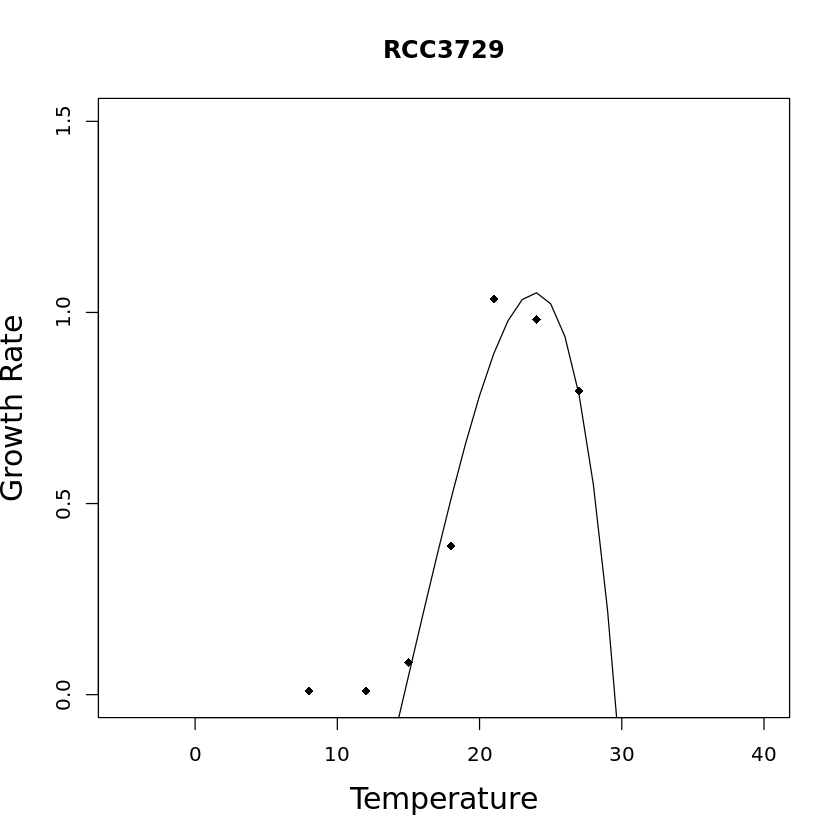

 [1] -4.509942e-01 -4.400928e-01 -4.260684e-01 -4.086693e-01 -3.876436e-01
 [6] -3.627428e-01 -3.337266e-01 -3.003684e-01 -2.624620e-01 -2.198296e-01
[11] -1.723311e-01 -1.198758e-01 -6.243482e-02 -5.716303e-05  6.711257e-02
[16]  1.388131e-01  2.146424e-01  2.940290e-01  3.762000e-01  4.601434e-01
[21]  5.445647e-01  6.278379e-01  7.079482e-01  7.824273e-01  8.482794e-01
[26]  9.018959e-01  9.389594e-01  9.543333e-01  9.419372e-01  8.946048e-01
[31]  8.039225e-01  6.600471e-01  4.514989e-01  1.649273e-01 -2.151535e-01
[36] -7.066636e-01 -1.330296e+00 -2.109894e+00 -3.072888e+00 -4.250769e+00
[41] -5.679642e+00 -7.400837e+00 -9.461592e+00 -1.191584e+01 -1.482506e+01
[46] -1.825929e+01
[1] "^y"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


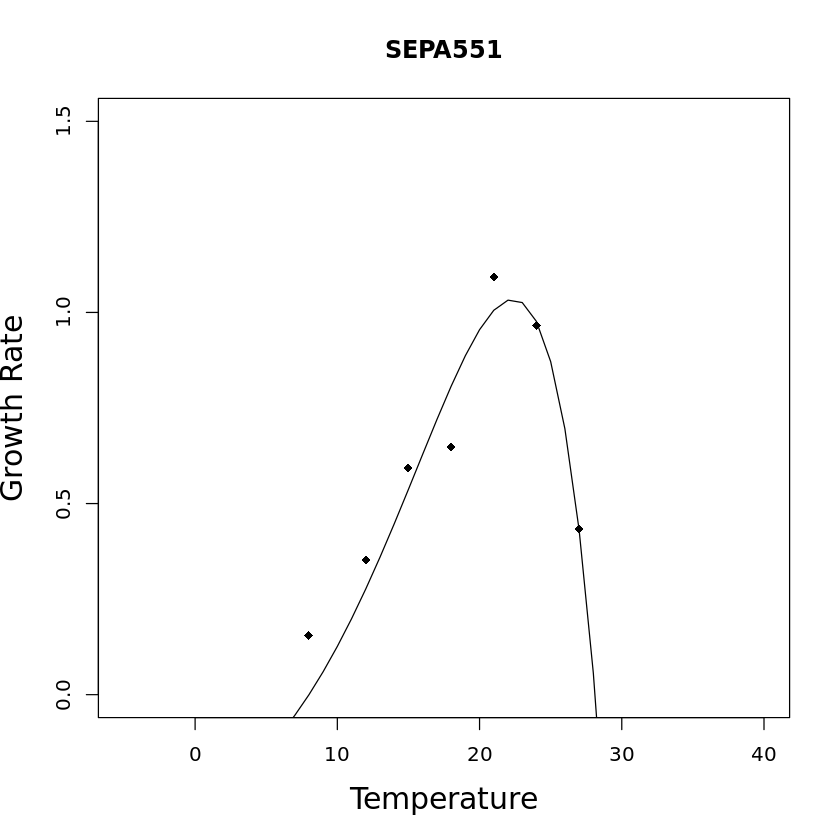

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA559 E. hux… I          Grow… Rate            8 deg        0.144
2          2 SEPA559 E. hux… I          Grow… Rate           12 deg        0.359
3          2 SEPA559 E. hux… I          Grow… Rate           15 deg        0.611
4          2 SEPA559 E. hux… I          Grow… Rate           18 deg        0.647
5          2 SEPA559 E. hux… I          Grow… Rate           21 deg        1.03 
6          2 SEPA559 E. hux… I          Grow… Rate           24 deg        1.12 
7          2 SEPA559 E. hux… I          Grow… Rate           27 deg        0.355
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.155522
[1] "^b"
 [1]  -0.036629062  -0.036030502  -0.034595263  -0.032126342  -0.028395509
 [6]  -0.023140283  -0.016061111  -0.006818935   0.004966569   0.019717710
[11]   0.037897980   0.060009084 

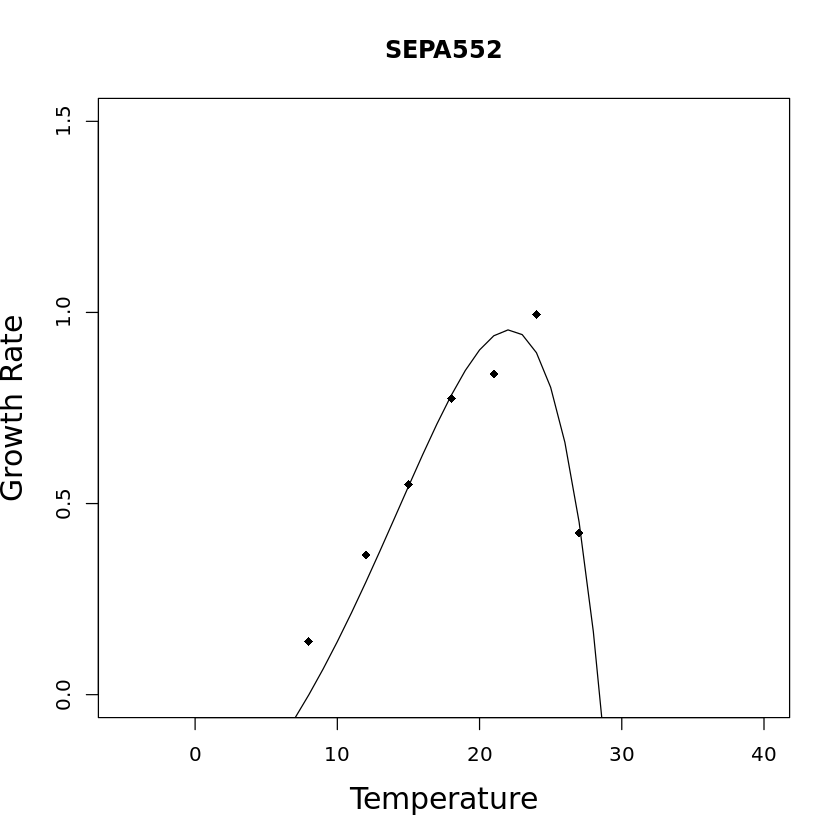

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA561 E. hux… I          Grow… Rate            8 deg        0.167
2          2 SEPA561 E. hux… I          Grow… Rate           12 deg        0.32 
3          2 SEPA561 E. hux… I          Grow… Rate           15 deg        0.349
4          2 SEPA561 E. hux… I          Grow… Rate           18 deg        0.424
5          2 SEPA561 E. hux… I          Grow… Rate           21 deg        0.786
6          2 SEPA561 E. hux… I          Grow… Rate           24 deg        0.988
7          2 SEPA561 E. hux… I          Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.1993893
[1] "^b"
 [1] -2.081295e-02 -2.253634e-02 -2.417023e-02 -2.562727e-02 -2.679385e-02
 [6] -2.752454e-02 -2.763572e-02 -2.689843e-02 -2.503047e-02 -2.168799e-02
[11] -1.645674e-02 -8.843543e-03

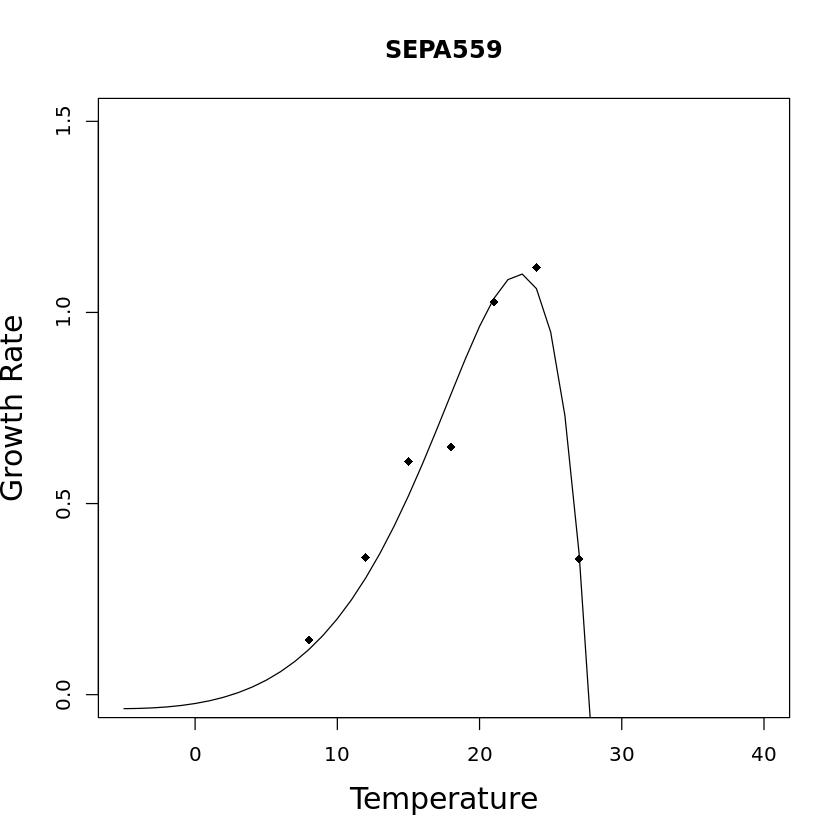

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA562 E. hux… I          Grow… Rate            8 deg        0.187
2          2 SEPA562 E. hux… I          Grow… Rate           12 deg        0.19 
3          2 SEPA562 E. hux… I          Grow… Rate           15 deg        0.379
4          2 SEPA562 E. hux… I          Grow… Rate           18 deg        0.46 
5          2 SEPA562 E. hux… I          Grow… Rate           21 deg        1.35 
6          2 SEPA562 E. hux… I          Grow… Rate           24 deg        1.03 
7          2 SEPA562 E. hux… I          Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.3238413
[1] "^b"
 [1] -2.478219e-03 -3.073938e-03 -3.785542e-03 -4.623218e-03 -5.591316e-03
 [6] -6.683661e-03 -7.876621e-03 -9.119085e-03 -1.031825e-02 -1.131986e-02
[11] -1.188115e-02 -1.163460e-02

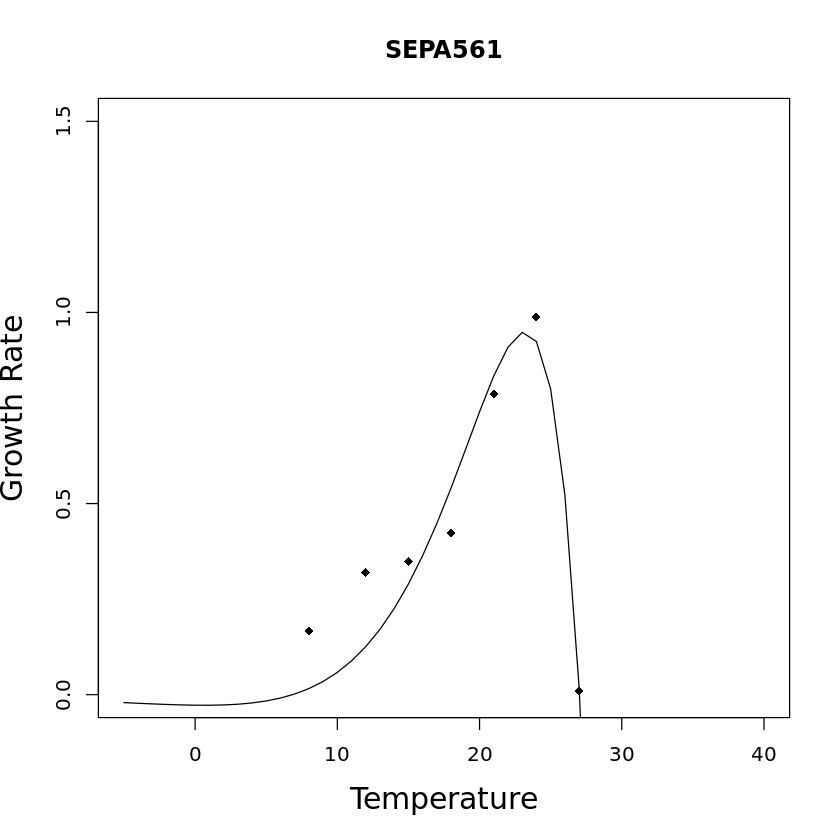

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA564 E. hux… I          Grow… Rate            8 deg        0.039
2          2 SEPA564 E. hux… I          Grow… Rate           12 deg        0.307
3          2 SEPA564 E. hux… I          Grow… Rate           15 deg        0.326
4          2 SEPA564 E. hux… I          Grow… Rate           18 deg        0.727
5          2 SEPA564 E. hux… I          Grow… Rate           21 deg        0.707
6          2 SEPA564 E. hux… I          Grow… Rate           24 deg        0.871
7          2 SEPA564 E. hux… I          Grow… Rate           27 deg        0.445
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.101705
[1] "^b"
 [1] -2.531608e-01 -2.510038e-01 -2.469043e-01 -2.406234e-01 -2.319094e-01
 [6] -2.204996e-01 -2.061232e-01 -1.885043e-01 -1.673664e-01 -1.424378e-01
[11] -1.134593e-01 -8.019264e-02 

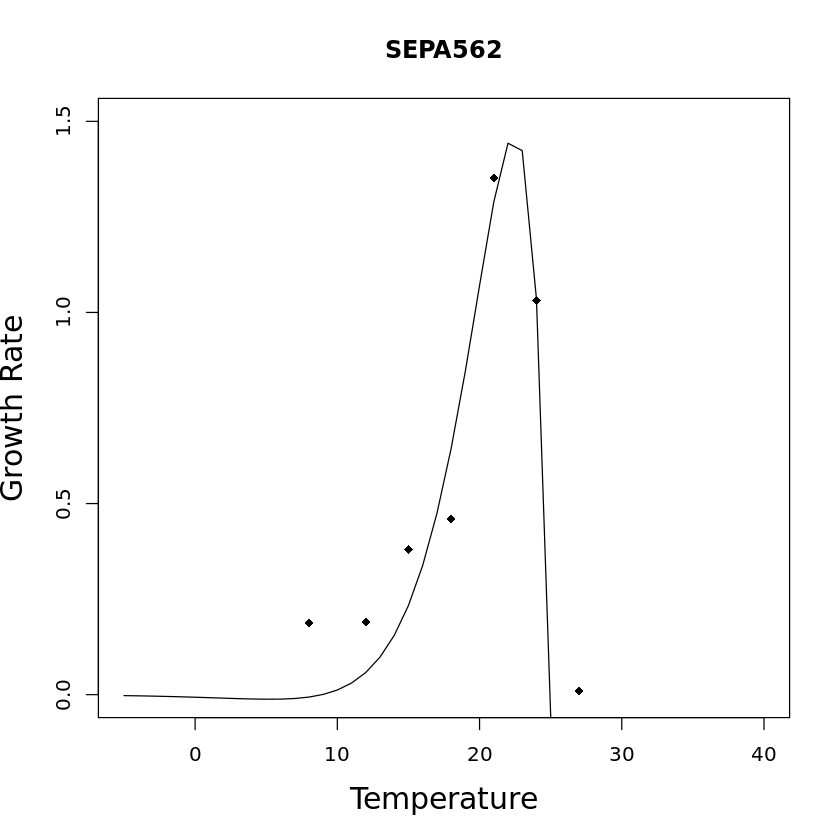

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA571 E. hux… I          Grow… Rate            8 deg        0.135
2          2 SEPA571 E. hux… I          Grow… Rate           12 deg        0.219
3          2 SEPA571 E. hux… I          Grow… Rate           15 deg        0.381
4          2 SEPA571 E. hux… I          Grow… Rate           18 deg        0.523
5          2 SEPA571 E. hux… I          Grow… Rate           21 deg        0.666
6          2 SEPA571 E. hux… I          Grow… Rate           24 deg        0.577
7          2 SEPA571 E. hux… I          Grow… Rate           27 deg        0.357
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.06012667
[1] "^b"
 [1] -0.641134579 -0.613265458 -0.582537668 -0.548893418 -0.512290476
 [6] -0.472705045 -0.430134987 -0.384603414 -0.336162705 -0.284898961
[11] -0.230936973 -0.174445730 -0.1156445

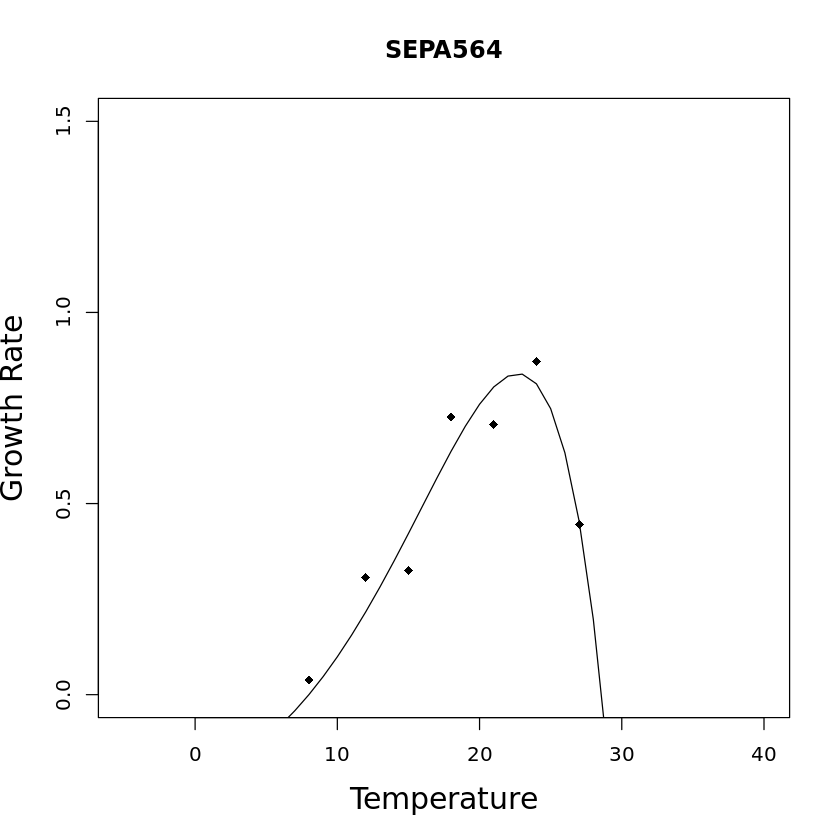

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA590 E. hux… I          Grow… Rate            8 deg        0.145
2          2 SEPA590 E. hux… I          Grow… Rate           12 deg        0.288
3          2 SEPA590 E. hux… I          Grow… Rate           15 deg        0.549
4          2 SEPA590 E. hux… I          Grow… Rate           18 deg        1.05 
5          2 SEPA590 E. hux… I          Grow… Rate           21 deg        1.09 
6          2 SEPA590 E. hux… I          Grow… Rate           24 deg        1.12 
7          2 SEPA590 E. hux… I          Grow… Rate           27 deg        0.419
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.08416059
[1] "^b"
 [1]  -0.795738050  -0.782083546  -0.763791097  -0.740493473  -0.711824740
 [6]  -0.677425953  -0.636952069  -0.590080279  -0.536519964  -0.476024530
[11]  -0.408405393  -0.33354843

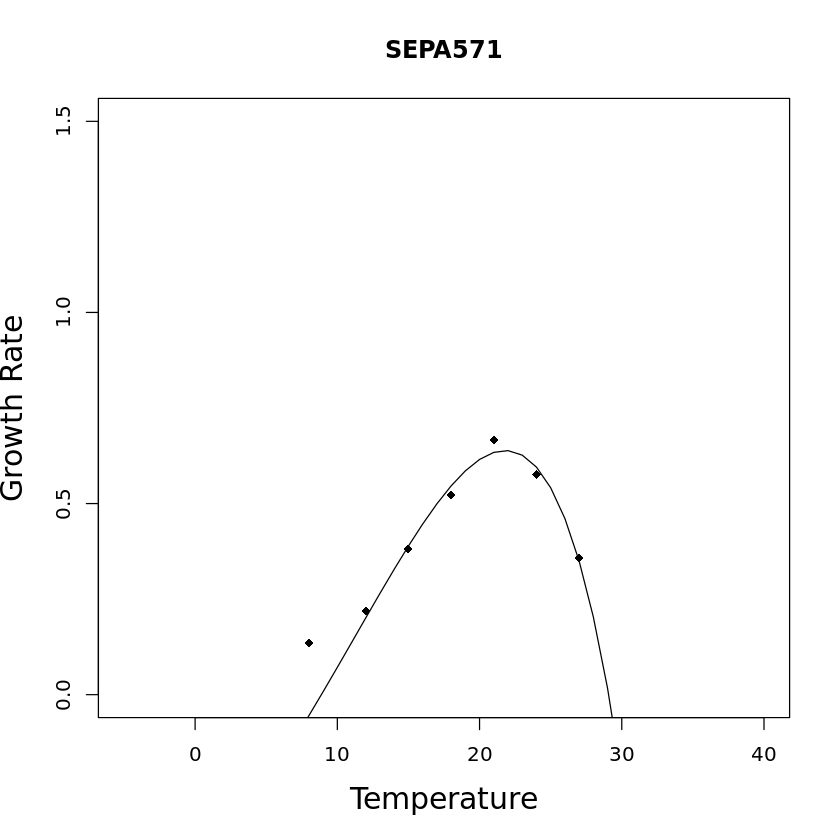

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA547 E. hux… Ib         Grow… Rate            8 deg        0.085
2          2 SEPA547 E. hux… Ib         Grow… Rate           12 deg        0.221
3          2 SEPA547 E. hux… Ib         Grow… Rate           15 deg        0.3  
4          2 SEPA547 E. hux… Ib         Grow… Rate           18 deg        0.312
5          2 SEPA547 E. hux… Ib         Grow… Rate           21 deg        0.838
6          2 SEPA547 E. hux… Ib         Grow… Rate           24 deg        0.721
7          2 SEPA547 E. hux… Ib         Grow… Rate           27 deg        0.131
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.1594946
[1] "^b"
 [1]  -0.07011771  -0.07408704  -0.07775313  -0.08096512  -0.08354167
 [6]  -0.08526702  -0.08588711  -0.08510574  -0.08258116  -0.07792320
[11]  -0.07069167  -0.06039631  -0.0464993

Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.1849615
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


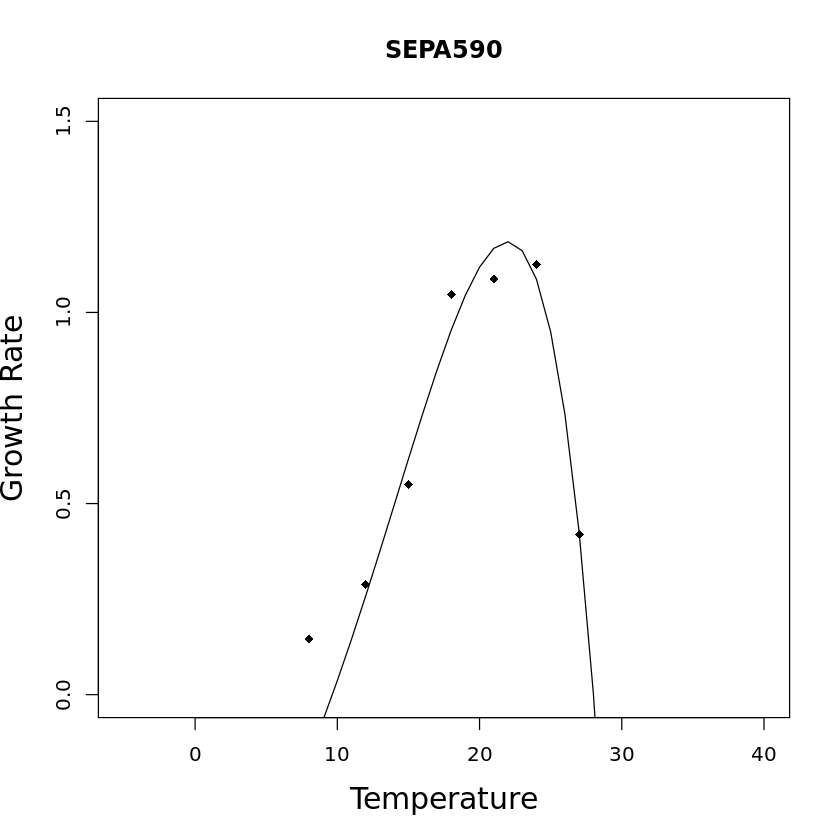

 [1] -2.599072e-02 -2.746359e-02 -2.868403e-02 -2.953374e-02 -2.986595e-02
 [6] -2.950059e-02 -2.821902e-02 -2.575853e-02 -2.180665e-02 -1.599572e-02
[11] -7.898044e-03  2.977694e-03  1.718783e-02  3.535168e-02  5.814433e-02
[16]  8.628191e-02  1.204962e-01  1.614941e-01  2.098971e-01  2.661522e-01
[21]  3.304057e-01  4.023268e-01  4.808641e-01  5.639148e-01  6.478783e-01
[26]  7.270592e-01  7.928741e-01  8.328040e-01  8.290193e-01  7.565797e-01
[31]  5.810924e-01  2.556714e-01 -2.829934e-01 -1.119705e+00 -2.367276e+00
[36] -4.174892e+00 -6.738804e+00 -1.031599e+01 -1.524157e+01 -2.195092e+01
[41] -3.100786e+01 -4.314023e+01 -5.928507e+01 -8.064567e+01 -1.087636e+02
[46] -1.456095e+02
[1] "^y"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


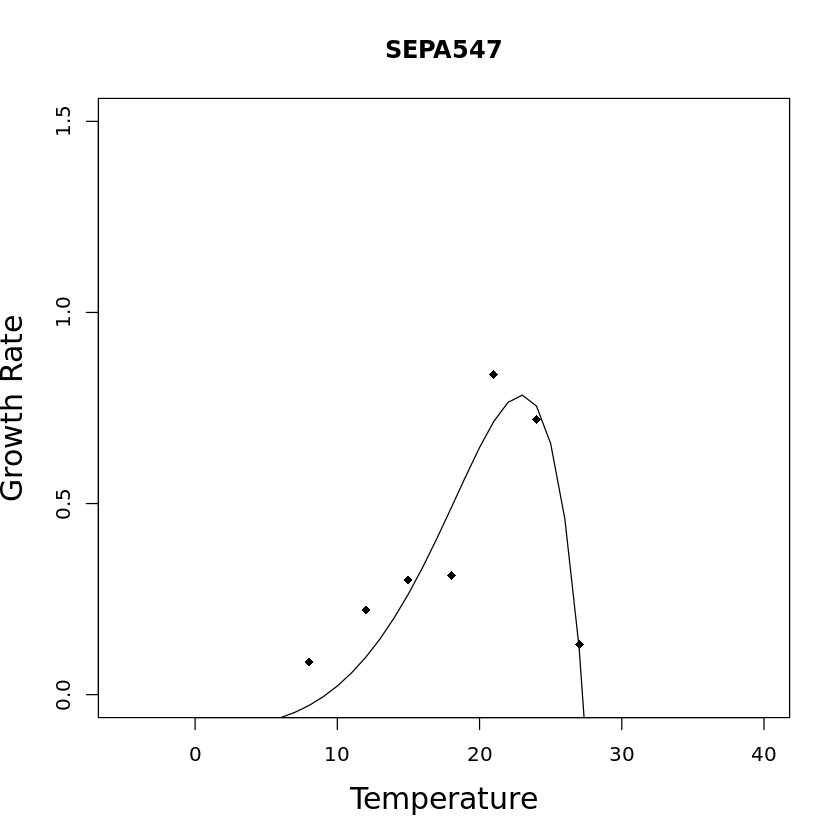

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA563 E. hux… Ib         Grow… Rate            8 deg        0.177
2          2 SEPA563 E. hux… Ib         Grow… Rate           12 deg        0.412
3          2 SEPA563 E. hux… Ib         Grow… Rate           15 deg        0.479
4          2 SEPA563 E. hux… Ib         Grow… Rate           18 deg        0.518
5          2 SEPA563 E. hux… Ib         Grow… Rate           21 deg        0.675
6          2 SEPA563 E. hux… Ib         Grow… Rate           24 deg        0.58 
7          2 SEPA563 E. hux… Ib         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.1019608
[1] "^b"
 [1]  -0.10001081  -0.09298076  -0.08430872  -0.07383261  -0.06138622
 [6]  -0.04680149  -0.02991134  -0.01055344   0.01142518   0.03616232
[11]   0.06377354   0.09434341   0.1279150

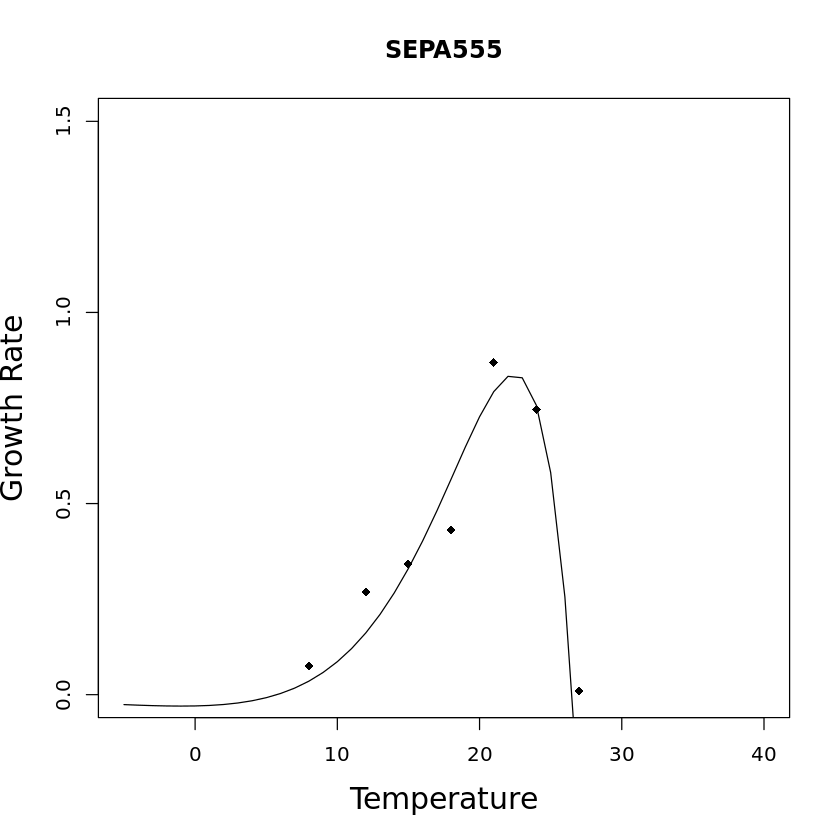

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA566 E. hux… Ib         Grow… Rate            8 deg        0.089
2          2 SEPA566 E. hux… Ib         Grow… Rate           12 deg        0.258
3          2 SEPA566 E. hux… Ib         Grow… Rate           15 deg        0.322
4          2 SEPA566 E. hux… Ib         Grow… Rate           18 deg        0.416
5          2 SEPA566 E. hux… Ib         Grow… Rate           21 deg        0.586
6          2 SEPA566 E. hux… Ib         Grow… Rate           24 deg        0.783
7          2 SEPA566 E. hux… Ib         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.1678504
[1] "^b"
 [1] -4.577068e-02 -4.841265e-02 -5.079881e-02 -5.280355e-02 -5.427418e-02
 [6] -5.502709e-02 -5.484371e-02 -5.346659e-02 -5.059549e-02 -4.588407e-02
[11] -3.893740e-02 -2.931089e-02

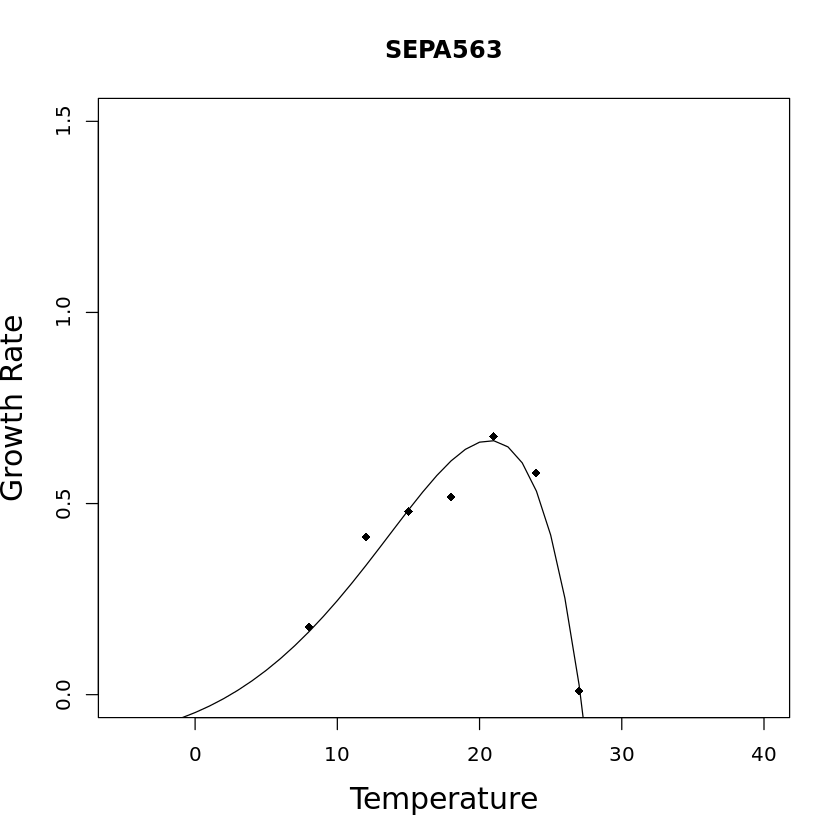

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA567 E. hux… Ib         Grow… Rate            8 deg        0.107
2          2 SEPA567 E. hux… Ib         Grow… Rate           12 deg        0.355
3          2 SEPA567 E. hux… Ib         Grow… Rate           15 deg        0.266
4          2 SEPA567 E. hux… Ib         Grow… Rate           18 deg        0.476
5          2 SEPA567 E. hux… Ib         Grow… Rate           21 deg        0.606
6          2 SEPA567 E. hux… Ib         Grow… Rate           24 deg        0.442
7          2 SEPA567 E. hux… Ib         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.08062223
[1] "^b"
 [1] -3.653181e-01 -3.541269e-01 -3.405411e-01 -3.244108e-01 -3.055918e-01
 [6] -2.839497e-01 -2.593632e-01 -2.317294e-01 -2.009687e-01 -1.670314e-01
[11] -1.299052e-01 -8.962334e-0

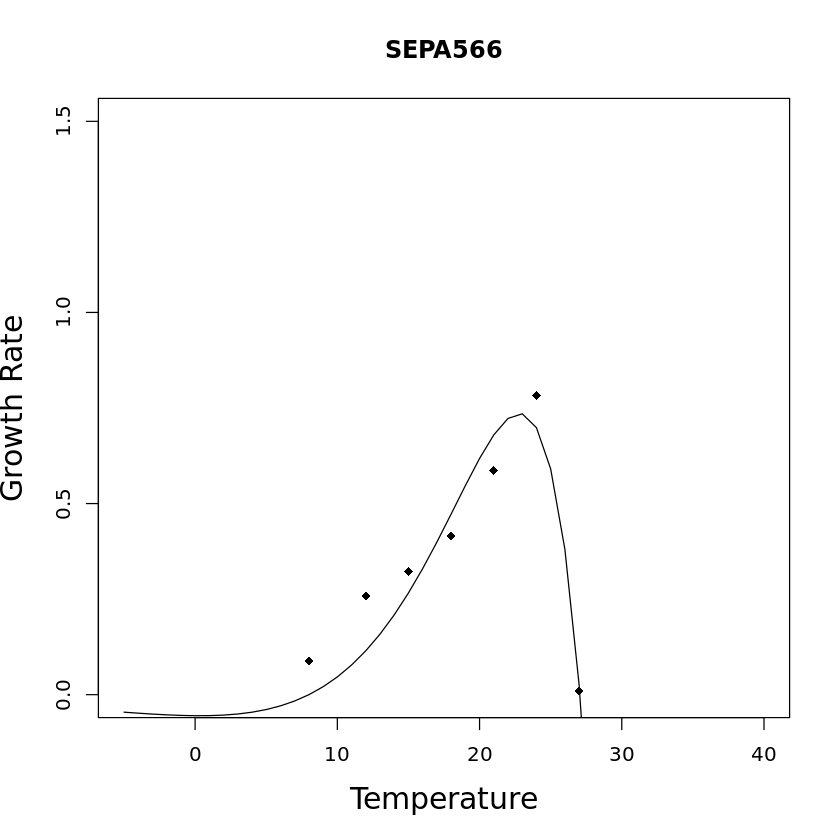

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA568 E. hux… Ib         Grow… Rate            8 deg        0.206
2          2 SEPA568 E. hux… Ib         Grow… Rate           12 deg        0.233
3          2 SEPA568 E. hux… Ib         Grow… Rate           15 deg        0.212
4          2 SEPA568 E. hux… Ib         Grow… Rate           18 deg        0.304
5          2 SEPA568 E. hux… Ib         Grow… Rate           21 deg        0.595
6          2 SEPA568 E. hux… Ib         Grow… Rate           24 deg        0.517
7          2 SEPA568 E. hux… Ib         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.1638506
[1] "^b"
 [1]  -0.016484541  -0.016342549  -0.015814954  -0.014802333  -0.013188021
 [6]  -0.010836192  -0.007589970  -0.003269716   0.002328382   0.009433181
[11]   0.018298640   0.029202679

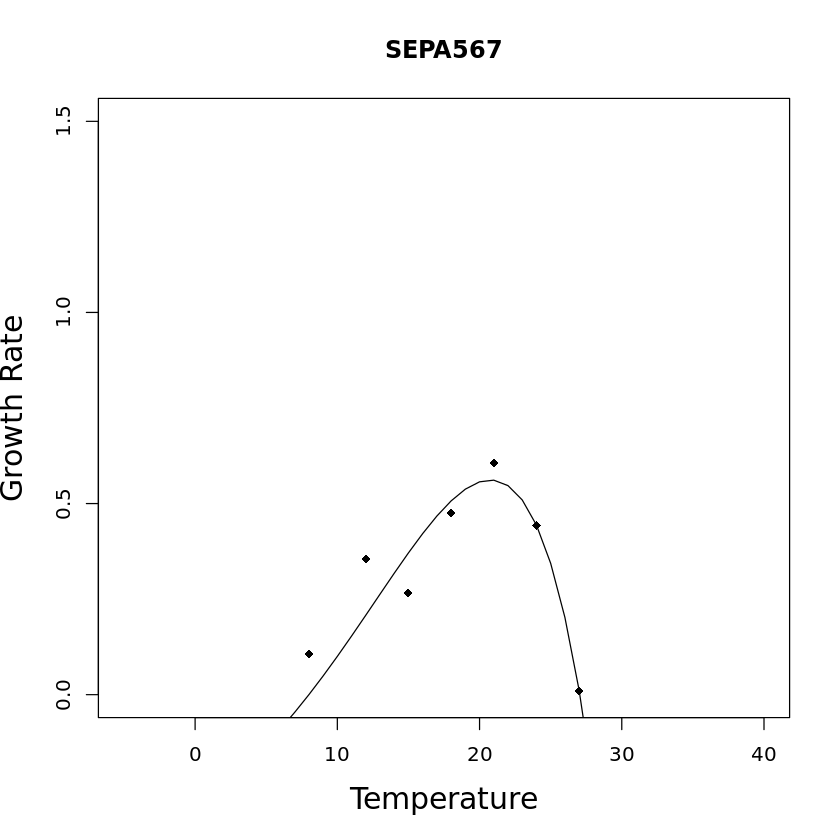

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA569 E. hux… Ib         Grow… Rate            8 deg        0.115
2          2 SEPA569 E. hux… Ib         Grow… Rate           12 deg        0.189
3          2 SEPA569 E. hux… Ib         Grow… Rate           15 deg        0.318
4          2 SEPA569 E. hux… Ib         Grow… Rate           18 deg        0.345
5          2 SEPA569 E. hux… Ib         Grow… Rate           21 deg        0.606
6          2 SEPA569 E. hux… Ib         Grow… Rate           24 deg        0.494
7          2 SEPA569 E. hux… Ib         Grow… Rate           27 deg        0.069
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.1166527
[1] "^b"
 [1] -1.362242e-01 -1.369265e-01 -1.365370e-01 -1.348763e-01 -1.317498e-01
 [6] -1.269481e-01 -1.202487e-01 -1.114171e-01 -1.002101e-01 -8.637929e-02
[11] -6.967655e-02 -4.986084e-02

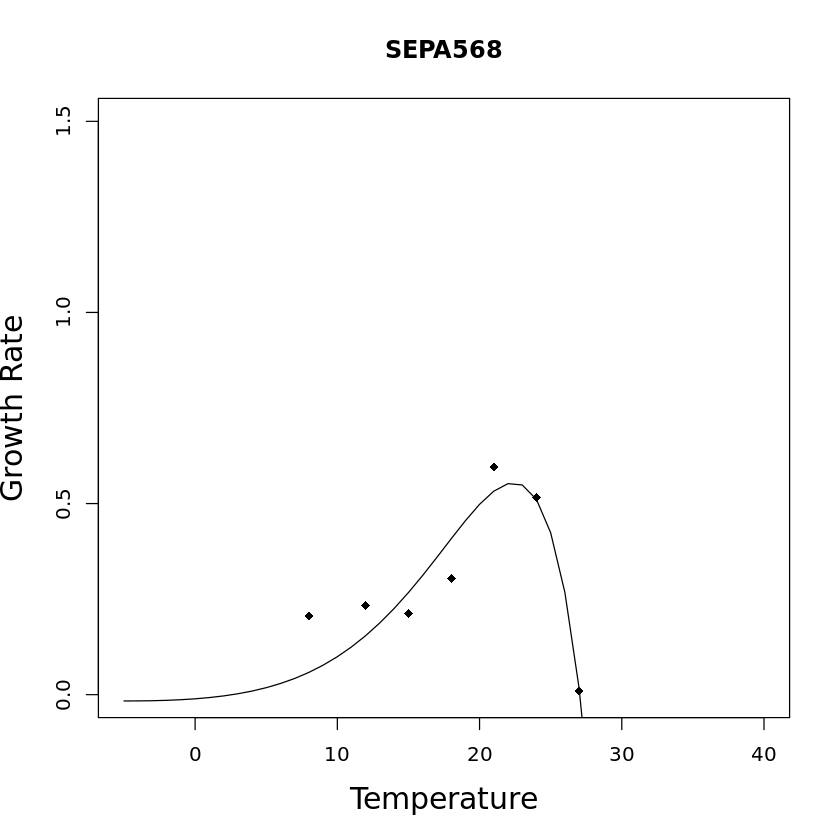

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA570 E. hux… Ib         Grow… Rate            8 deg        0.158
2          2 SEPA570 E. hux… Ib         Grow… Rate           12 deg        0.346
3          2 SEPA570 E. hux… Ib         Grow… Rate           15 deg        0.242
4          2 SEPA570 E. hux… Ib         Grow… Rate           18 deg        0.353
5          2 SEPA570 E. hux… Ib         Grow… Rate           21 deg        0.701
6          2 SEPA570 E. hux… Ib         Grow… Rate           24 deg        0.605
7          2 SEPA570 E. hux… Ib         Grow… Rate           27 deg        0.023
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.1461081
[1] "^b"
 [1]  -0.05246407  -0.05337443  -0.05367841  -0.05322652  -0.05184728
 [6]  -0.04934555  -0.04550123  -0.04006829  -0.03277455  -0.02332232
[11]  -0.01139046   0.00336188   0.0212891

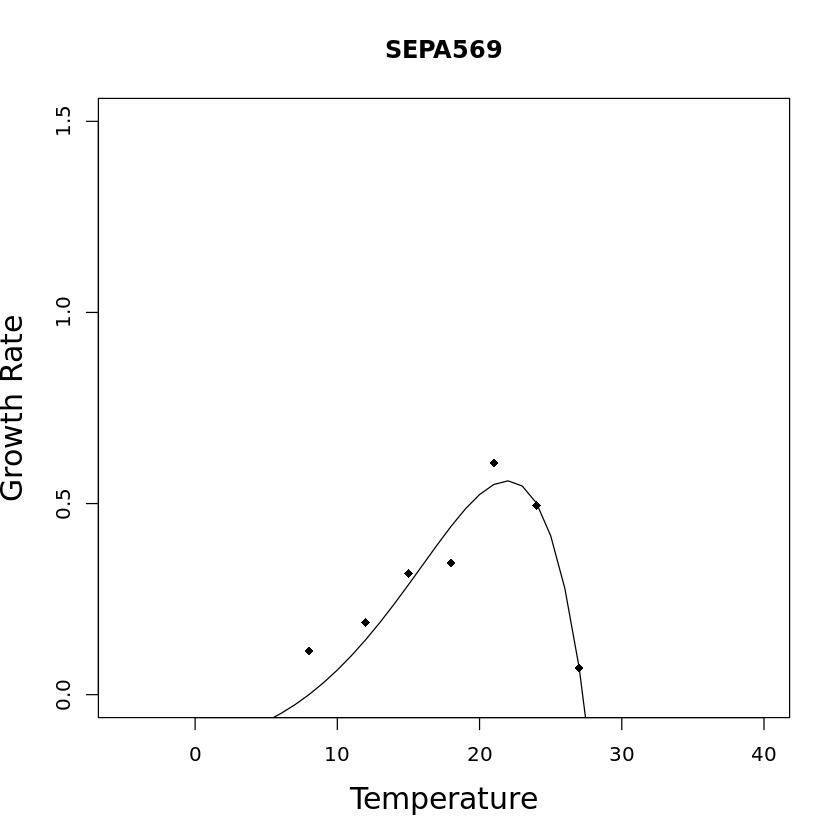

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA572 E. hux… Ib         Grow… Rate            8 deg        0.176
2          2 SEPA572 E. hux… Ib         Grow… Rate           12 deg        0.276
3          2 SEPA572 E. hux… Ib         Grow… Rate           15 deg        0.273
4          2 SEPA572 E. hux… Ib         Grow… Rate           18 deg        0.501
5          2 SEPA572 E. hux… Ib         Grow… Rate           21 deg        0.674
6          2 SEPA572 E. hux… Ib         Grow… Rate           24 deg        0.709
7          2 SEPA572 E. hux… Ib         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.1178163
[1] "^b"
 [1] -3.348428e-01 -3.434829e-01 -3.506053e-01 -3.558900e-01 -3.589849e-01
 [6] -3.595063e-01 -3.570393e-01 -3.511402e-01 -3.413402e-01 -3.271506e-01
[11] -3.080710e-01 -2.835997e-01

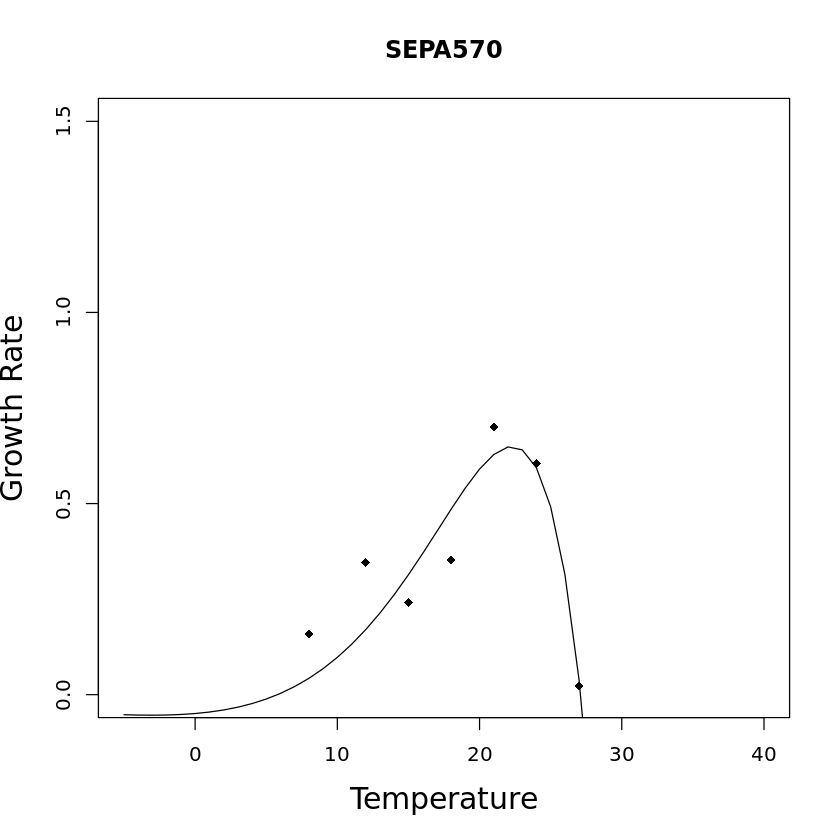

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA583 E. hux… Ib         Grow… Rate            8 deg        0.164
2          2 SEPA583 E. hux… Ib         Grow… Rate           12 deg        0.22 
3          2 SEPA583 E. hux… Ib         Grow… Rate           15 deg        0.307
4          2 SEPA583 E. hux… Ib         Grow… Rate           18 deg        0.312
5          2 SEPA583 E. hux… Ib         Grow… Rate           21 deg        0.777
6          2 SEPA583 E. hux… Ib         Grow… Rate           24 deg        0.648
7          2 SEPA583 E. hux… Ib         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.184137
[1] "^b"
 [1] -3.296382e-02 -3.541789e-02 -3.774972e-02 -3.985663e-02 -4.160896e-02
 [6] -4.284526e-02 -4.336704e-02 -4.293318e-02 -4.125416e-02 -3.798635e-02
[11] -3.272680e-02 -2.500912e-02 

Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.09558914
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


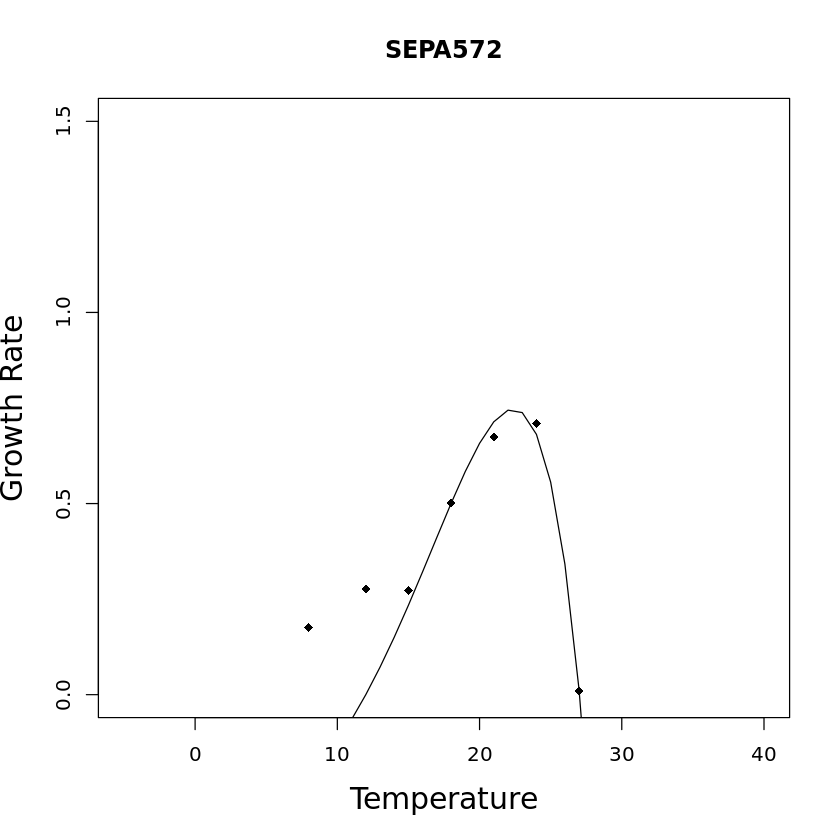

 [1]  -0.488241284  -0.481210644  -0.470640461  -0.456170580  -0.437432211
 [6]  -0.414052629  -0.385661189  -0.351896888  -0.312417779  -0.266912535
[11]  -0.215114570  -0.156819124  -0.091903843  -0.020353394   0.057711182
[16]   0.141997660   0.232001463   0.326957159   0.425781470   0.527006505
[21]   0.628701710   0.728382867   0.822906167   0.908345195   0.979848282
[26]   1.031473395   1.055997293   1.044695282   0.987087365   0.870646030
[31]   0.680460287   0.398849837   0.004922423  -0.525933460  -1.222629418
[36]  -2.119041619  -3.254770239  -4.676006780  -6.436523785  -8.598803396
[41] -11.235323299 -14.430021021 -18.279960211 -22.897225568 -28.411076518
[46] -34.970393518
[1] "^y"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


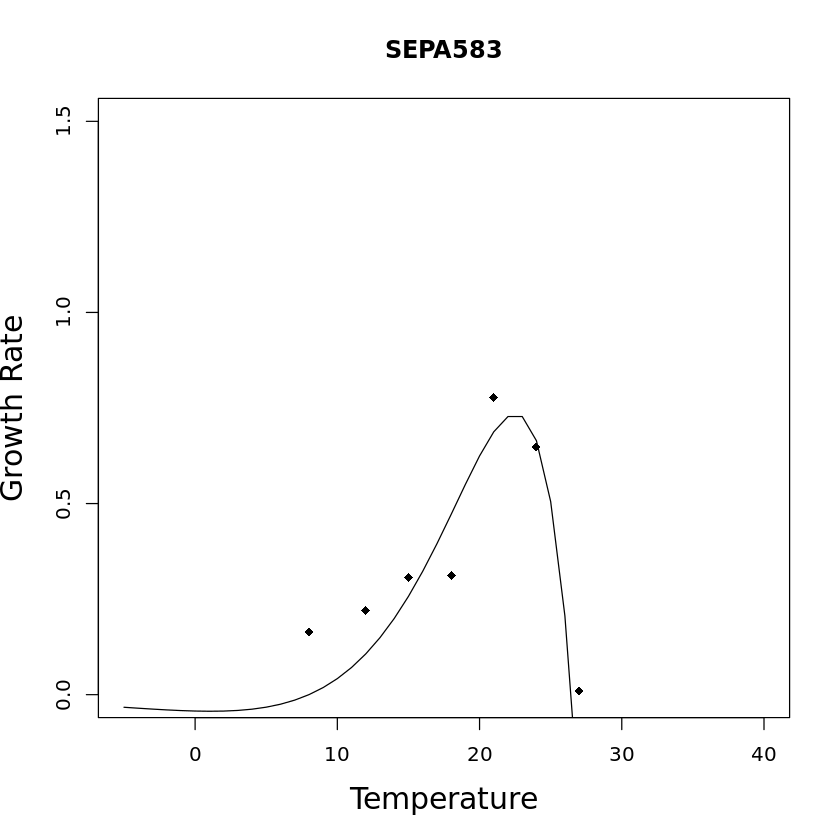

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA539 E. hux… II         Grow… Rate            8 deg        0.072
2          2 SEPA539 E. hux… II         Grow… Rate           12 deg        0.273
3          2 SEPA539 E. hux… II         Grow… Rate           15 deg        0.292
4          2 SEPA539 E. hux… II         Grow… Rate           18 deg        0.459
5          2 SEPA539 E. hux… II         Grow… Rate           21 deg        0.57 
6          2 SEPA539 E. hux… II         Grow… Rate           24 deg        0.515
7          2 SEPA539 E. hux… II         Grow… Rate           27 deg        0.372
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.07339519
[1] "^b"
 [1] -0.240967717 -0.229356781 -0.216015552 -0.200857164 -0.183799884
 [6] -0.164769030 -0.143699199 -0.120536855 -0.095243295 -0.067798081
[11] -0.038202954 -0.006486317  0.0272916

Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


[1] 0.136101
[1] "^b"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


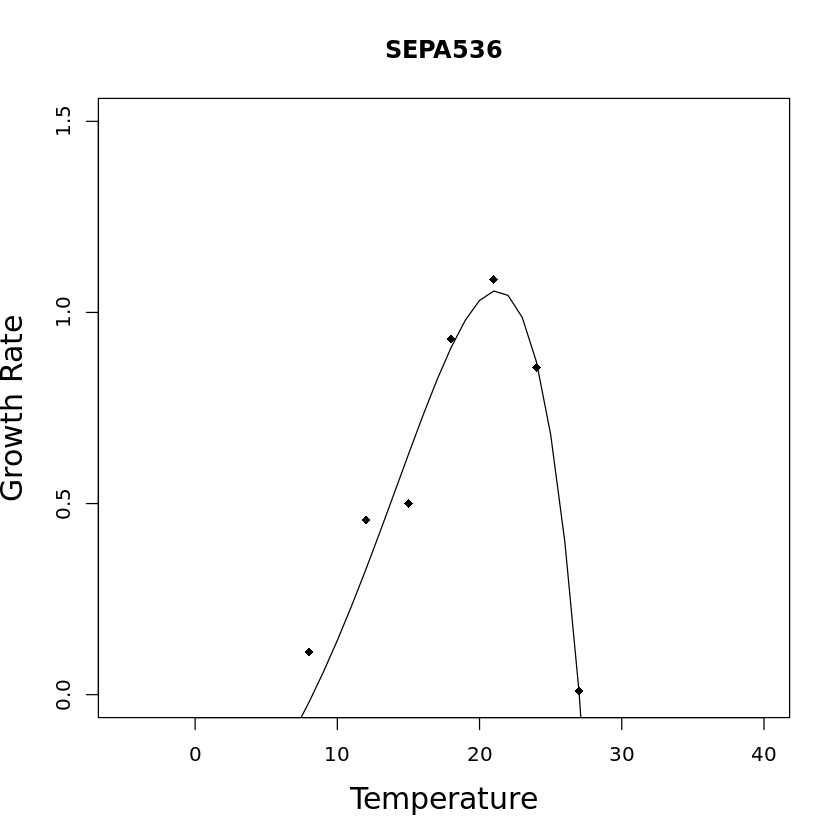

 [1]  -0.068568562  -0.066710904  -0.063551626  -0.058852385  -0.052347832
 [6]  -0.043744971  -0.032723212  -0.018935398  -0.002010115   0.018444265
[11]   0.042833320   0.071567428   0.105048934   0.143654669   0.187712594
[16]   0.237471106   0.293059208   0.354435339   0.421322216   0.493124447
[21]   0.568825011   0.646855890   0.724937157   0.799877666   0.867329111
[26]   0.921483543   0.954702501   0.957063523   0.915807043   0.814663339
[31]   0.633035274   0.345007865  -0.081849812  -0.687931458  -1.523338032
[36]  -2.649977950  -4.144092058  -6.099285315  -8.630162375 -11.876682323
[41] -16.009369068 -21.235539034 -27.806737424 -36.027609245 -46.266472472
[46] -58.967909212
[1] "^y"


Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”
Warning message in sqrt(diag(object@vcov)):
“NaNs produced”


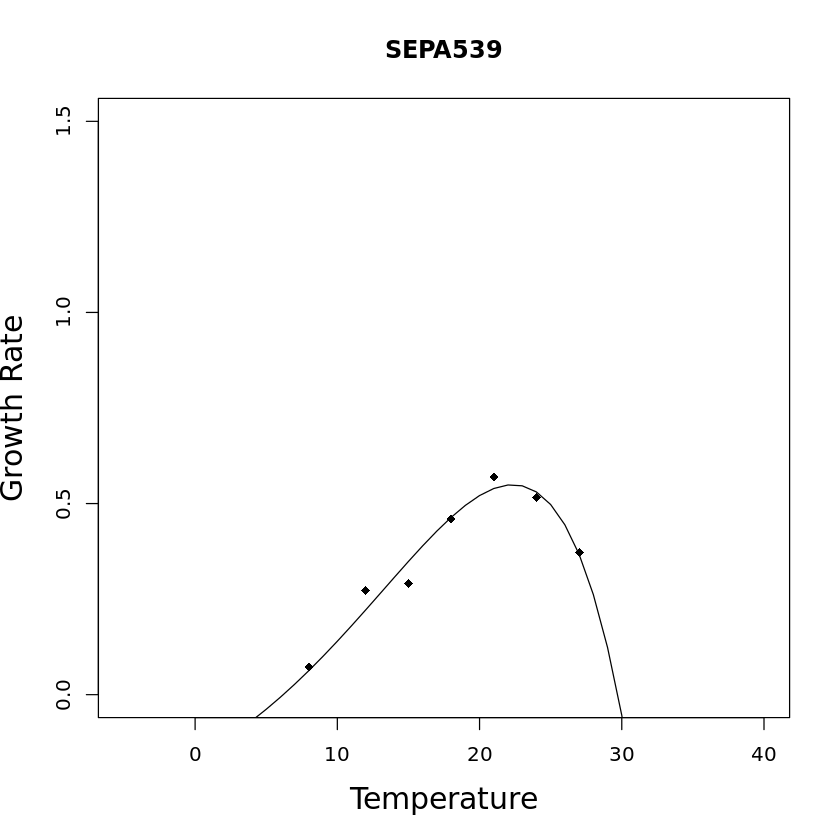

# A tibble: 6 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA545 E. hux… II         Grow… Rate            8 deg        0.168
2          2 SEPA545 E. hux… II         Grow… Rate           12 deg        0.393
3          2 SEPA545 E. hux… II         Grow… Rate           15 deg        0.533
4          2 SEPA545 E. hux… II         Grow… Rate           18 deg        0.787
5          2 SEPA545 E. hux… II         Grow… Rate           21 deg        1.10 
6          2 SEPA545 E. hux… II         Grow… Rate           24 deg        0.636
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 16

[1] 0.1367147
[1] "^b"
 [1] -1.976973e-01 -2.023774e-01 -2.054943e-01 -2.066812e-01 -2.055254e-01
 [6] -2.015670e-01 -1.942987e-01 -1.831666e-01 -1.675746e-01 -1.468901e-01
[11] -1.204549e-01 -8.760026e-02 -4.766868e-02 -4.406731e-05  5.580815e-02
[16]  1.202877e-01  1.935900e-01  2.75

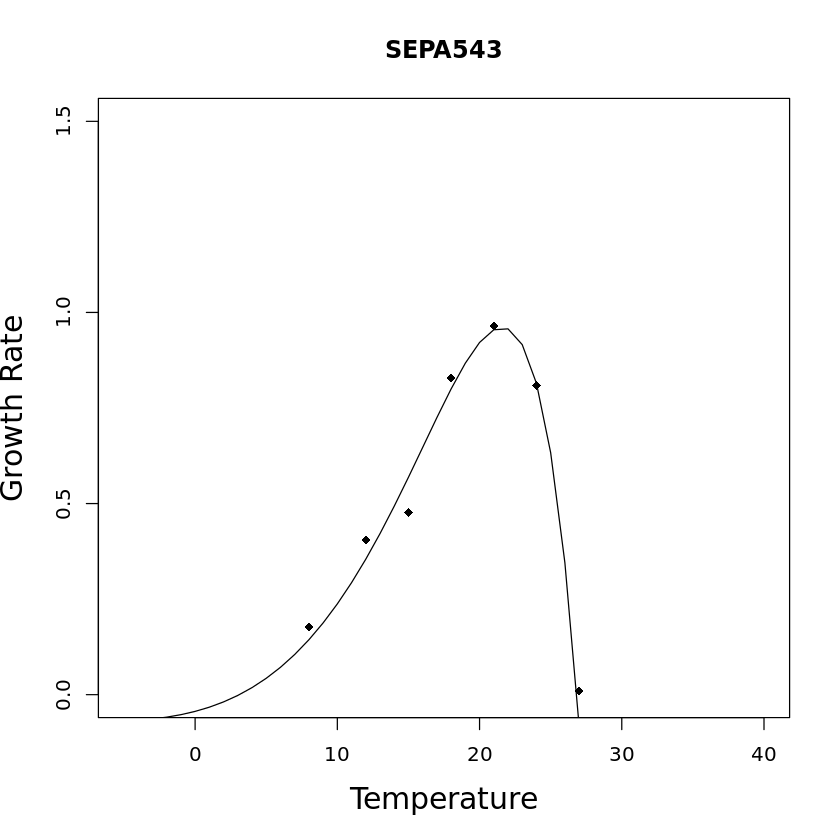

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA546 E. hux… II         Grow… Rate            8 deg        0.102
2          2 SEPA546 E. hux… II         Grow… Rate           12 deg        0.38 
3          2 SEPA546 E. hux… II         Grow… Rate           15 deg        0.438
4          2 SEPA546 E. hux… II         Grow… Rate           18 deg        0.727
5          2 SEPA546 E. hux… II         Grow… Rate           21 deg        0.923
6          2 SEPA546 E. hux… II         Grow… Rate           24 deg        0.77 
7          2 SEPA546 E. hux… II         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.1043957
[1] "^b"
 [1] -3.136482e-01 -3.113673e-01 -3.066399e-01 -2.991590e-01 -2.886023e-01
 [6] -2.746349e-01 -2.569127e-01 -2.350882e-01 -2.088169e-01 -1.777660e-01
[11] -1.416251e-01 -1.001202e-01

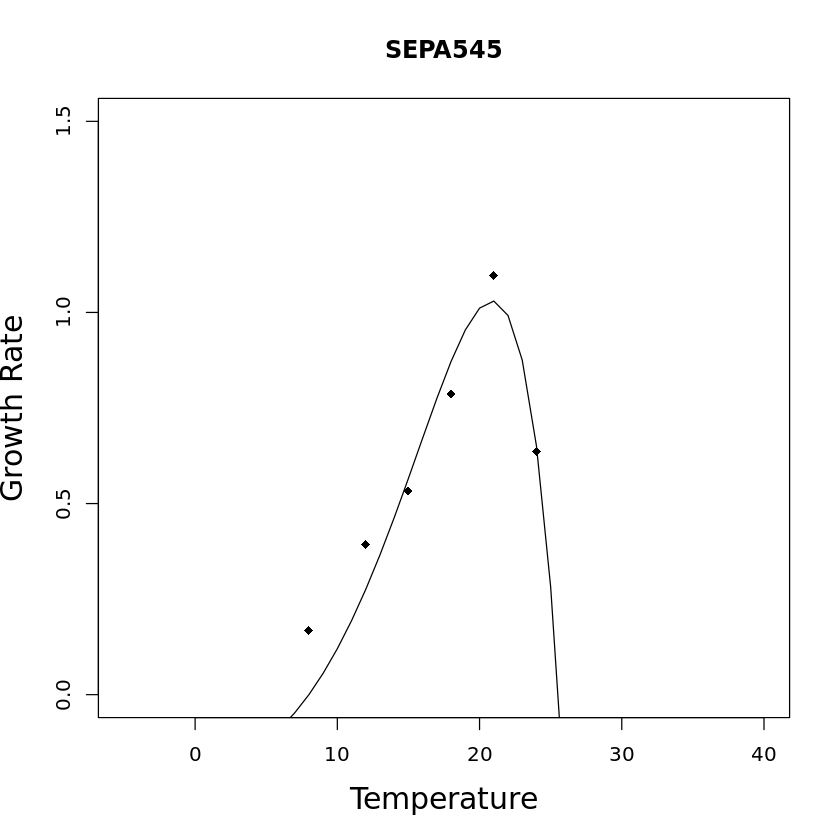

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA560 E. hux… II         Grow… Rate            8 deg        0.058
2          2 SEPA560 E. hux… II         Grow… Rate           12 deg        0.141
3          2 SEPA560 E. hux… II         Grow… Rate           15 deg        0.267
4          2 SEPA560 E. hux… II         Grow… Rate           18 deg        0.454
5          2 SEPA560 E. hux… II         Grow… Rate           21 deg        0.639
6          2 SEPA560 E. hux… II         Grow… Rate           24 deg        0.427
7          2 SEPA560 E. hux… II         Grow… Rate           27 deg        0.079
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 19

[1] 0.0837752
[1] "^b"
 [1]  -0.436974314  -0.429494991  -0.419522547  -0.406866317  -0.391337779
 [6]  -0.372753812  -0.350940646  -0.325738587  -0.297007652  -0.264634239
[11]  -0.228538987  -0.188686002

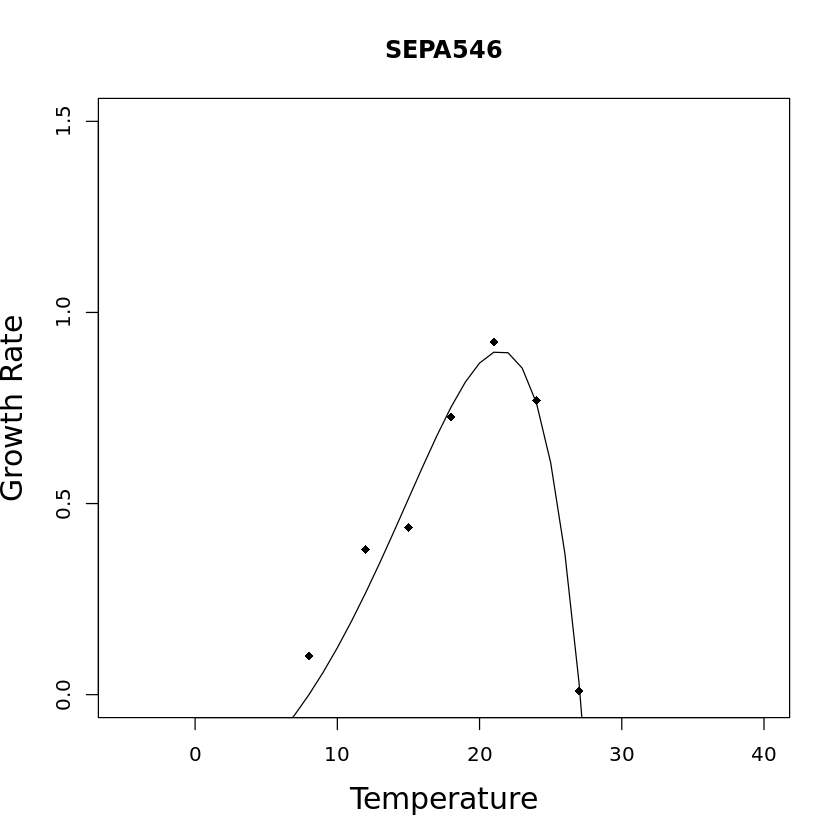

# A tibble: 7 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA574 E. hux… II         Grow… Rate            8 deg        0.059
2          2 SEPA574 E. hux… II         Grow… Rate           12 deg        0.369
3          2 SEPA574 E. hux… II         Grow… Rate           15 deg        0.28 
4          2 SEPA574 E. hux… II         Grow… Rate           18 deg        0.651
5          2 SEPA574 E. hux… II         Grow… Rate           21 deg        0.486
6          2 SEPA574 E. hux… II         Grow… Rate           24 deg        0.685
7          2 SEPA574 E. hux… II         Grow… Rate           27 deg        0.01 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 24

$w
[1] 19

[1] 0.1405015
[1] "^b"
 [1] -3.245757e-02 -3.098641e-02 -2.871797e-02 -2.550331e-02 -2.117543e-02
 [6] -1.554859e-02 -8.417940e-03  4.402519e-04  1.126762e-02  2.432169e-02
[11]  3.987251e-02  5.819749e-02

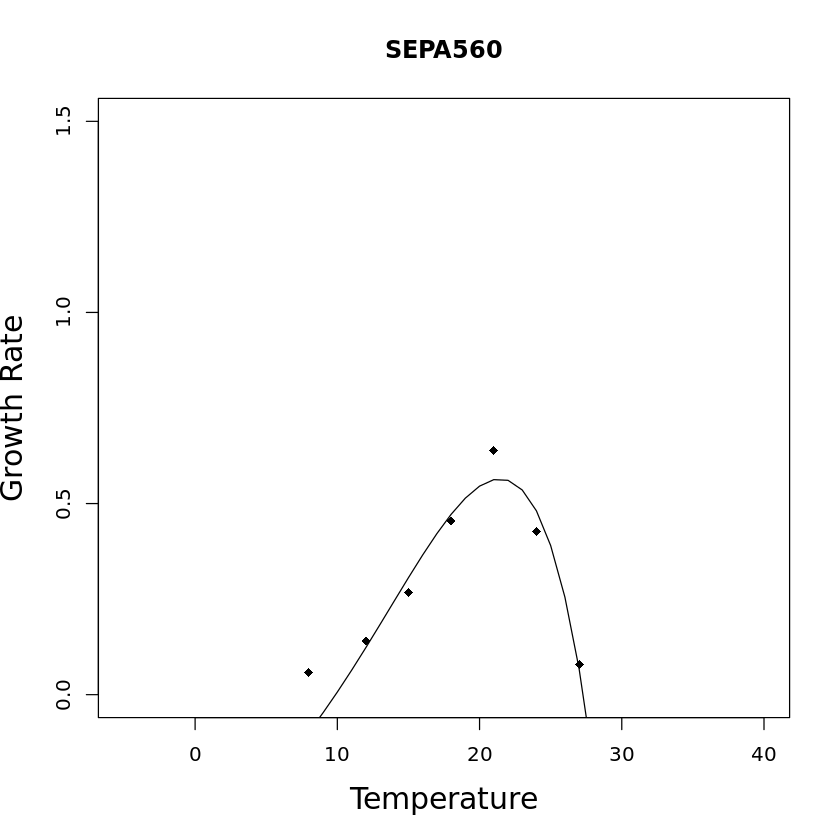

# A tibble: 6 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA607 E. hux… II         Grow… Rate            8 deg        0.093
2          2 SEPA607 E. hux… II         Grow… Rate           12 deg        0.517
3          2 SEPA607 E. hux… II         Grow… Rate           15 deg        0.439
4          2 SEPA607 E. hux… II         Grow… Rate           18 deg        0.983
5          2 SEPA607 E. hux… II         Grow… Rate           21 deg        0.983
6          2 SEPA607 E. hux… II         Grow… Rate           24 deg        0.465
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 16

[1] 0.1204024
[1] "^b"
 [1] -3.151383e-01 -3.172378e-01 -3.167625e-01 -3.132811e-01 -3.063275e-01
 [6] -2.954035e-01 -2.799827e-01 -2.595172e-01 -2.334469e-01 -2.012118e-01
[11] -1.622697e-01 -1.161183e-01 -6.232444e-02 -5.610218e-04  6.934575e-02
[16]  1.473577e-01  2.331515e-01  3.26

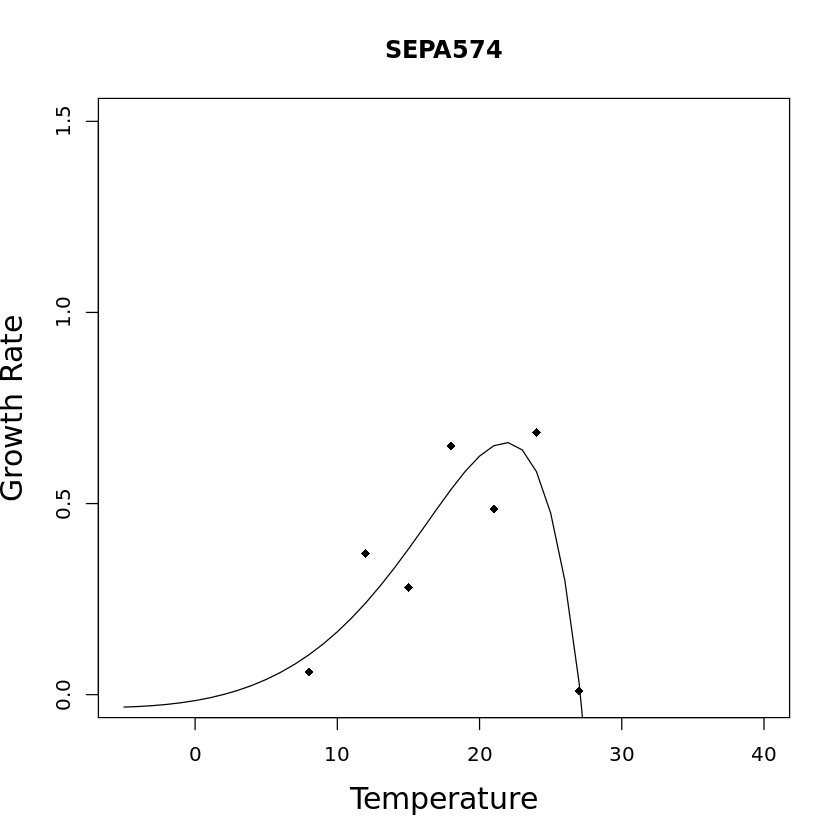

# A tibble: 6 × 9
  Experiment Strain  Species Haplogroup Sep1  Sep2  Temperature deg   GrowthRate
       <int> <chr>   <chr>   <chr>      <chr> <chr>       <dbl> <chr>      <dbl>
1          2 SEPA609 E. hux… II         Grow… Rate            8 deg        0.116
2          2 SEPA609 E. hux… II         Grow… Rate           12 deg        0.289
3          2 SEPA609 E. hux… II         Grow… Rate           15 deg        0.447
4          2 SEPA609 E. hux… II         Grow… Rate           18 deg        0.633
5          2 SEPA609 E. hux… II         Grow… Rate           21 deg        1.03 
6          2 SEPA609 E. hux… II         Grow… Rate           24 deg        0.53 
$a
[1] 0.05

$b
[1] 0.01

$o
[1] 21

$w
[1] 16

[1] 0.195521
[1] "^b"
 [1] -3.728689e-02 -4.011297e-02 -4.273222e-02 -4.499078e-02 -4.669250e-02
 [6] -4.759097e-02 -4.738082e-02 -4.568835e-02 -4.206188e-02 -3.596241e-02
[11] -2.675525e-02 -1.370398e-02  4.031549e-03  2.739072e-02  5.739760e-02
[16]  9.513152e-02  1.416763e-01  1.980

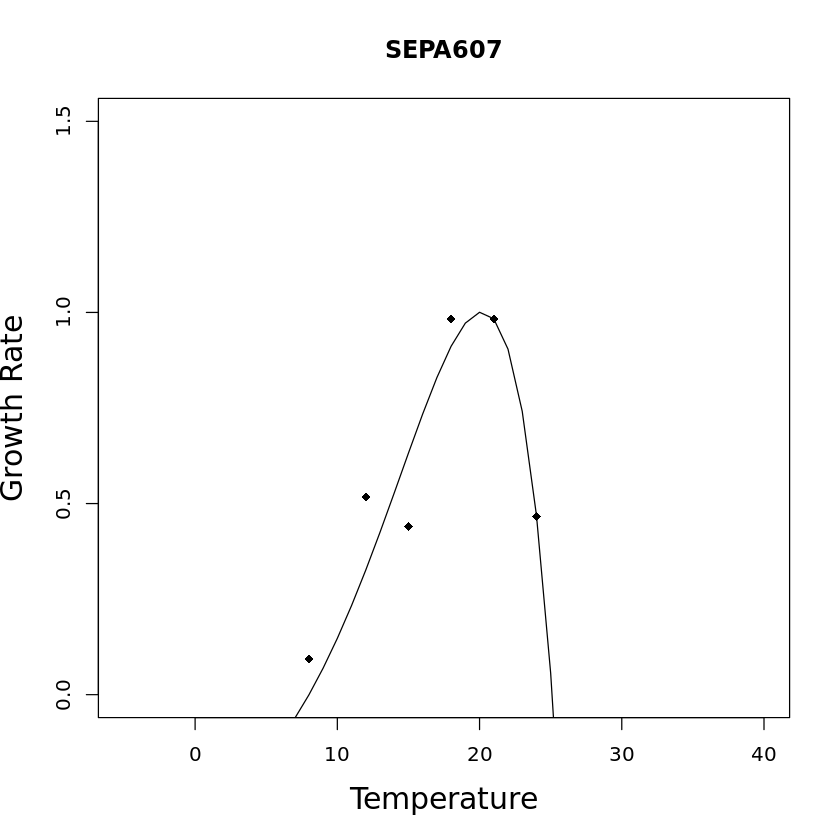

[1] "0.812272924618199; window-100 to -100; strain:SEPA92"
[1] "0.992443270074243; window-100 to -100; strain:SEPA100"
[1] "0.89617319680679; window-100 to -100; strain:SEPA127"
[1] "0.773649210801474; window-100 to -100; strain:SEPA340"
[1] "0.589818025651069; window-100 to -100; strain:SEPA342"
[1] "0.688570016243083; window-100 to -100; strain:SEPA350"
[1] "0.965788858095603; window-100 to -100; strain:SEPA118"
[1] "0.75507737361456; window-100 to -100; strain:SEPA81"
[1] "0.767308664629186; window-100 to -100; strain:SEPA341"
[1] "0.808778948359158; window-100 to -100; strain:SEPA365"
[1] "0.683683613138435; window-100 to -100; strain:SEPA373"
[1] "0.656551656941914; window-100 to -100; strain:SEPA527"
[1] "0.78000136945478; window-100 to -100; strain:SEPA528"
[1] "0.66320168318049; window-100 to -100; strain:SEPA529"
[1] "0.821604349363048; window-100 to -100; strain:SEPA530"
[1] "0.490966645833615; window-100 to -100; strain:SEPA516"
[1] "0.698337120045617; window-100 to -100; st

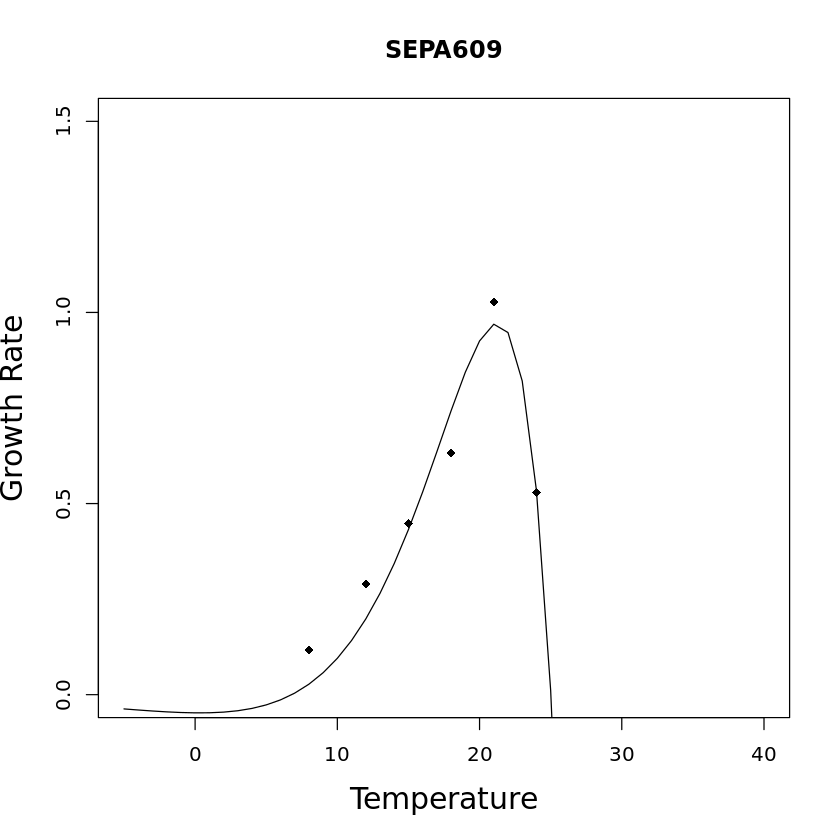

In [8]:
## recalculate van Dassow parameters


LL1 <- function (y, x, a, b, w, o){
    N = nbcurve(x=x,a=a,b=b,w=w,opt=o)
    N[N<=0]=0.01
    N=N
    y=y
    return(-sum(dnorm(y,N,log = TRUE))) # the negative log likelihoods: the order of N and y don't matter)
}

nbcurve <- function(x,opt,w,a,b){
  res<-a*exp(b*x)*(1-((x-opt)/(w/2))^2)
  res
}

LL1 <- function (y, x, a, b, w, o){
    N = nbcurve(x=x,a=a,b=b,w=w,opt=o)
    N[N<=0]=0.01
    N=N
    y=y
    return(-sum(dnorm(y,N,log = TRUE))) # the negative log likelihoods: the order of N and y don't matter)
}

vandassowparam <- function(vandassow,strain) {
    a = 0.05
    b = 0.01
    x=seq(-5,40,1)
    bootstrapped_points=vandassow%>%dplyr::filter(Strain==strain) %>%
        dplyr::mutate(GrowthRate=case_when(GrowthRate==0~0.01,
                                           TRUE~GrowthRate)) %>%
        dplyr::filter(!is.na(GrowthRate))
    
    print(bootstrapped_points)
    guess_opt = max(as.numeric(unique((bootstrapped_points %>% 
                            dplyr::filter(GrowthRate==max(GrowthRate,na.rm=T)))$Temperature)))
    
    guess_wid = max(as.numeric(unique((bootstrapped_points %>% dplyr::filter(GrowthRate>0.0) %>%
                            dplyr::filter(Temperature==max(Temperature,na.rm=T)))$Temperature) - 
                           unique((bootstrapped_points %>% dplyr::filter(GrowthRate>0.0) %>%
                            dplyr::filter(Temperature==min(Temperature,na.rm=T)))$Temperature)))
    o_guess = guess_opt # optimum temperature
    w_guess=15
    if (guess_wid!=0) {
        w_guess = guess_wid # thermal niche width
    }
    
    print(list(a = a, b = b,
                                            o = o_guess,w = w_guess))
    m1 = bbmle::mle2(minuslogl = LL1, start = list(a = a, b = b,
                                                   w = w_guess,
                                                   o = o_guess),
              data = list(y=as.numeric(bootstrapped_points$GrowthRate),
                          x=as.numeric(bootstrapped_points$Temperature)),
              control=list(maxit=1000000,abstol=1e-20))
    print(summary(m1)@coef["b","Estimate"])
    print("^b")

    y = nbcurve(x=x,
            a=summary(m1)@coef["a","Estimate"],
            b=summary(m1)@coef["b","Estimate"],
            w=summary(m1)@coef["w","Estimate"],
            opt=summary(m1)@coef["o","Estimate"])
    plot_frame=data.frame(x=x,
                          y=y,
                          type="Modeled") %>% 
            dplyr::bind_rows(data.frame(x=bootstrapped_points$Temperature,
                             y=bootstrapped_points$GrowthRate,
                             type="Measured")) %>%
            dplyr::mutate(x=as.numeric(x)) %>%
            dplyr::arrange(x)
    print(y)
    print("^y")
    plot(x,y, typ='l', col="black", cex.lab = 1.5, cex = 1.5,
    xlab="Temperature", ylab="Growth Rate",
    ylim=c(0,1.5))
    points(bootstrapped_points$Temperature,bootstrapped_points$GrowthRate,col="black",pch=18)
    title(as.character(strain))
    coef_list = data.frame("a"=summary(m1)@coef["a","Estimate"],
            "b"=summary(m1)@coef["b","Estimate"],
            "w"=summary(m1)@coef["w","Estimate"],
            "opt"=summary(m1)@coef["o","Estimate"],
            "a_err"=summary(m1)@coef["a","Std. Error"],
            "b_err"=b,
            "w_err"=summary(m1)@coef["w","Std. Error"],
            "opt_err"=summary(m1)@coef["o","Std. Error"],"Strain"=strain)
    return(coef_list)
    return(list(data.frame("Temperature"=x,
                      "ModeledPoints"=y,"Type"="Model",
                      "Strain"=strain) %>% 
           dplyr::bind_rows(data.frame("MeasuredPoints"=bootstrapped_points$GrowthRate,
                                       "Temperature"=as.numeric(bootstrapped_points$Temperature),"Type"="Measure",
                                       "Strain"=strain)),coef_list))
}
all_strains=data.frame()
for (strain in unique(vandassow$Strain)) {
    all_strains=all_strains %>% dplyr::bind_rows(vandassowparam(vandassow,strain))
}

recalculate=FALSE
all_strains=all_strains%>%dplyr::filter(!is.na(opt))
revised_df_vanDassow=data.frame()
for (curr in c(1:nrow(all_strains))) {
  strain_curr=all_strains$Strain[curr]
  group_curr="coccolithophores"
  if (length(group_curr)==0) {
    group_curr="unknown"
  }
  a=all_strains[curr,"a"]
  b=all_strains[curr,"b"]
  w=all_strains[curr,"w"]
  opt=all_strains[curr,"opt"]
  opt_val = optimize(nbcurve,interval=c(-20,40),maximum=TRUE,
                     a=a,
                     b=b,
                     w=w,
                     opt=opt)$maximum
  if (abs(opt_val) > 100) {
    next # these original parameterizations were bad.
  }
  wid_eq_1 = all_strains[curr,"w"]/2+
    opt
  wid_eq_2 = -all_strains[curr,"w"]/2+
    opt
  tol_gr=0.01 ## we don't want to say the width is valid when GR<this
  test_temp=wid_eq_1
  while ((nbcurve(test_temp,opt,w,a,b) < tol_gr)) {
    test_temp=test_temp+sign(test_temp)*-0.001
  }
  wid_eq_1=test_temp
  test_temp=wid_eq_2
  while ((nbcurve(test_temp,opt,w,a,b) < tol_gr)) {
    test_temp=test_temp+sign(test_temp-wid_eq_1)*-0.001
  }
  wid_eq_2=test_temp
  
  if (recalculate) {
    wid_eq_1 = (all_strains[curr,"w"])/2+
      opt_val
    wid_eq_2 = -(all_strains[curr,"w"])/2+
      opt_val
  }
  tolerance_val=nbcurve(opt_val,opt,w,a,b)*0.8
  temps_test=seq(from = wid_eq_2+sign(wid_eq_2)*wid_eq_2*0.5, 
                 to = wid_eq_1+sign(wid_eq_2)*wid_eq_2*0.5, by = 0.01)
  window_1 = -100
  window_2 = -100
  print(paste0(tolerance_val,"; window",window_1," to ",window_2,"; strain:",strain_curr))
  for (temp in temps_test) {
    if ((window_1<0)&(window_2<0)&(nbcurve(temp,opt,w,a,b) >= tolerance_val)) {
      window_1 = temp
    }else if ((window_2<0)&(window_1>0)&(nbcurve(temp,opt,w,a,b) <= tolerance_val)){
      window_2=temp
    }
  }
  if ((window_1==-100)|(window_2==-100)){
    print("broken")
    break
  }
  if (abs(wid_eq_2-wid_eq_1) > 50) {
    print("broken")
    #break
  }
  revised_df_vanDassow = rbind(revised_df_vanDassow,
                     data.frame(Strain=strain_curr,Revised_opt=opt_val,
                                Group=group_curr,
                                Revised_wid=abs(wid_eq_2-wid_eq_1),
                                Revised_plateau=abs(window_1-window_2),
                                low_temp=window_1,high_temp=window_2,
                                max_GR=nbcurve(opt_val,opt,w,a,b),
                                t_opt=opt_val,a=a,b=b,w=w))
}
revised_df_vanDassow$left_plateau=revised_df_vanDassow$t_opt-revised_df_vanDassow$low_temp
revised_df_vanDassow$right_plateau=revised_df_vanDassow$high_temp-revised_df_vanDassow$t_opt

In [9]:
nbcurve(x = opt_val,a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a,
         b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b,
         w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)

numeric(0)

In [10]:
revised_df_2 =data.frame()
for (strain_curr in all_params_coef$Strain) {
    opt_val = optimize(nbcurve,interval=c(0,40),maximum=TRUE,
         a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a,
         b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b,
         w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)$maximum
    gr_at_opt=nbcurve(x = opt_val,a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a,
         b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b,
         w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)
    revised_df_2 = revised_df_2 %>%
        dplyr::bind_rows(data.frame(Strain=strain_curr,Revised_opt=opt_val,
                                    Revised_gr_at_opt = gr_at_opt))
}

In [11]:
revised_df_2

Strain,Revised_opt,Revised_gr_at_opt
<dbl>,<dbl>,<dbl>
374,20.80583,0.5119661
3963,19.36241,0.8437714
3492,26.09844,0.9353981
1516,23.78410,1.0710528
874,18.72846,0.4896115
375,24.73246,0.9274210
2090,21.36411,0.9082177
379,20.57834,0.3590959
1212,22.25527,0.9475015


Joining with `by =
join_by(Strain)`
Joining with `by =
join_by(Strain)`


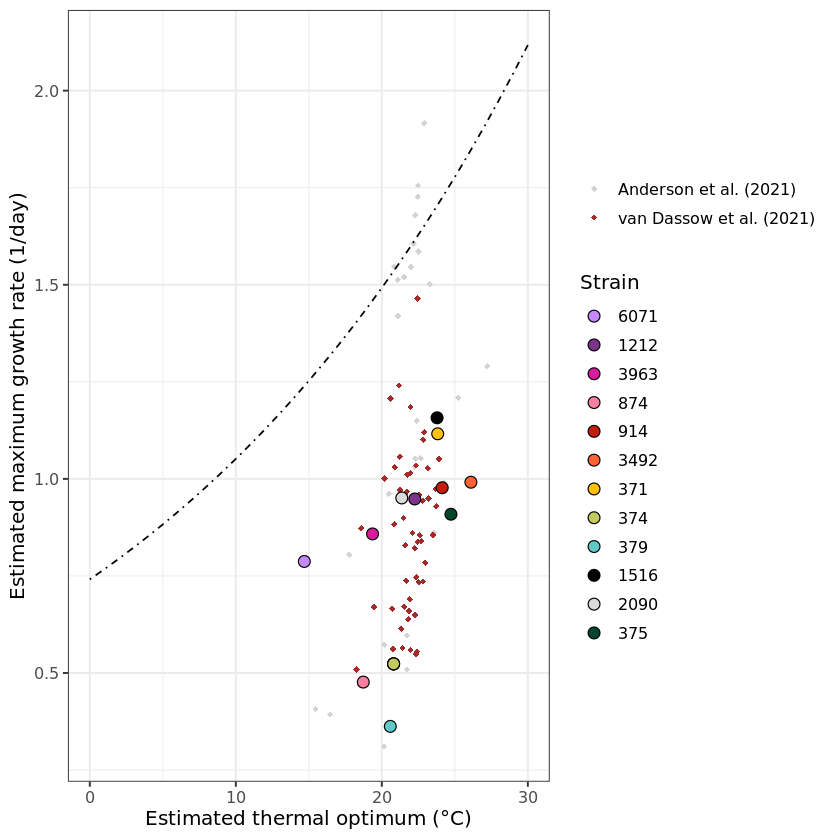

In [66]:
eppley_comp = ggplot(all_params_coef%>%dplyr::left_join(revised_df_2 %>% 
                                                        dplyr::mutate(Strain=as.numeric(as.character(Strain)))) %>%
          dplyr::left_join(all_params %>% dplyr::group_by(Strain) %>% 
                           dplyr::filter(MeasuredPoints==max(MeasuredPoints,na.rm=T))) %>%
          dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))))+ 
    geom_point(data=revised_df%>%dplyr::filter(Group=="coccolithophores"),
               aes(x=t_opt,y=max_GR,col="Anderson et al. (2021)"),pch=18)+
    geom_point(data=revised_df_vanDassow,
               aes(x=t_opt,y=max_GR,col="van Dassow et al. (2021)"),pch=18)+
    geom_point(aes(x = Revised_opt, y =MeasuredPoints,fill=Strain),size=3,color="black",
               pch=21) +
    geom_line(data=data.frame(x=c(0:30),y=0.741*exp(0.035*c(0:30))),
              mapping=aes(x=x,y=y),linetype="dotdash") + 
    theme_bw(base_size=12) + 
    ylab("Estimated maximum growth rate (1/day)") + xlab("Estimated thermal optimum (°C)") + 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors) +
    scale_color_manual(values=c("light gray","brown"),name="") +
    scale_size(name="Thermal width")
eppley_comp

In [13]:
revised_df_plateau =data.frame() ## range of temperatures within 10% of max GR. 
# we set res to be 10% of opt on either side.
recalculate=TRUE # if this is true, we use optimized Topt rather than the one the eqn spits out.

nbcurve <- function(x,opt,w,a,b){
  res<-a*exp(b*x)*(1-((x-opt)/(w/2))^2)
  res
}

for (strain_curr in all_params_coef$Strain) {
    a=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$a
    b=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$b
    w=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$w
    opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt
    opt_val = optimize(nbcurve,interval=c(0,40),maximum=TRUE,
         a=a,
         b=b,
         w=w,
         opt=(all_params_coef%>%dplyr::filter(Strain==strain_curr))$opt)$maximum
    wid_eq_1 = ((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        opt_val
    wid_eq_2 = -((all_params_coef%>%dplyr::filter(Strain==strain_curr))$w)/2+
        opt_val
    tolerance_val=nbcurve(opt_val,opt,w,a,b)*0.8
    temps_test=seq(from = wid_eq_2+sign(wid_eq_2)*wid_eq_2*0.5, 
                   to = wid_eq_1+sign(wid_eq_2)*wid_eq_2*0.5, by = 0.01)
    window_1 = -100
    window_2 = -100
    print(paste0(tolerance_val,"; window",window_1," to ",window_2,"; strain:",strain_curr))
    for (temp in temps_test) {
        if ((window_1<0)&(window_2<0)&(nbcurve(temp,opt,w,a,b) >= tolerance_val)) {
            window_1 = temp
        }else if ((window_2<0)&(window_1>0)&(nbcurve(temp,opt,w,a,b) <= tolerance_val)){
            window_2=temp
        }
    }
    revised_df_plateau = revised_df_plateau %>%
        dplyr::bind_rows(data.frame(Strain=strain_curr,Revised_plateau=abs(window_1-window_2),
                                    low_temp=window_1,high_temp=window_2,topt=opt_val,
                                    gr_opt=nbcurve(opt_val,opt,w,a,b)))
}
revised_df_plateau$left_plateau=revised_df_plateau$topt-revised_df_plateau$low_temp
revised_df_plateau$right_plateau=revised_df_plateau$high_temp-revised_df_plateau$topt



[1] "0.409572848058269; window-100 to -100; strain:374"
[1] "0.675017150307624; window-100 to -100; strain:3963"
[1] "0.748318492271454; window-100 to -100; strain:3492"
[1] "0.856842238027728; window-100 to -100; strain:1516"
[1] "0.391689229612213; window-100 to -100; strain:874"
[1] "0.74193683217584; window-100 to -100; strain:375"
[1] "0.726574135195631; window-100 to -100; strain:2090"
[1] "0.287276755881694; window-100 to -100; strain:379"
[1] "0.758001188255754; window-100 to -100; strain:1212"
[1] "0.836193902211334; window-100 to -100; strain:371"
[1] "0.504658356956675; window-100 to -100; strain:6071"
[1] "0.815101260342873; window-100 to -100; strain:914"


In [14]:
max(revised_df_plateau$Revised_plateau)-min(revised_df_plateau$Revised_plateau)

[1] 6.48

Saving 6.67 x 6.67 in
image


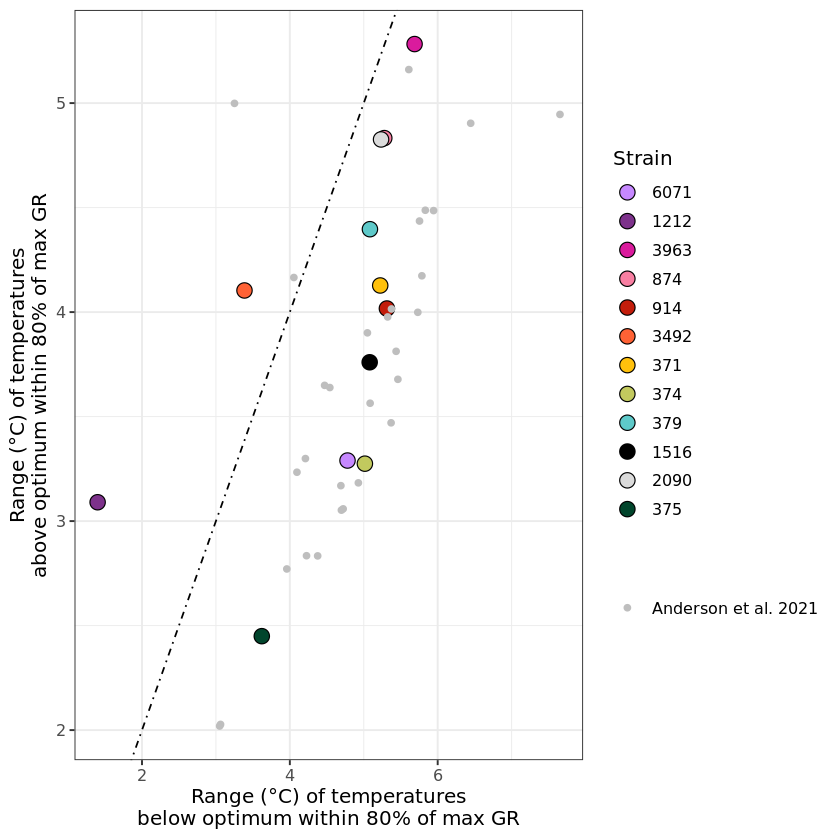

In [15]:
ggplot(revised_df_plateau) + geom_point(aes(x=left_plateau,y=right_plateau,fill=factor(Strain)),pch=21,size=4) + 
    geom_abline(aes(intercept=0,slope=1),linetype="dotdash")+ theme_bw(base_size=12)+ 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") +
    geom_point(data=revised_df%>%dplyr::filter(Group=="coccolithophores"),
               aes(x=left_plateau,y=right_plateau,color="Anderson et al. 2021")) + 
    scale_color_manual(limits=c("Anderson et al. 2021"),values="gray",name="") + 
    xlab("Range (°C) of temperatures\nbelow optimum within 80% of max GR")+ 
    ylab("Range (°C) of temperatures\nabove optimum within 80% of max GR")

ggsave("../../figures/supplemental/plateau_plot.png")

Warning message:
“Removed 12265 rows
containing missing values
(`geom_line()`).”


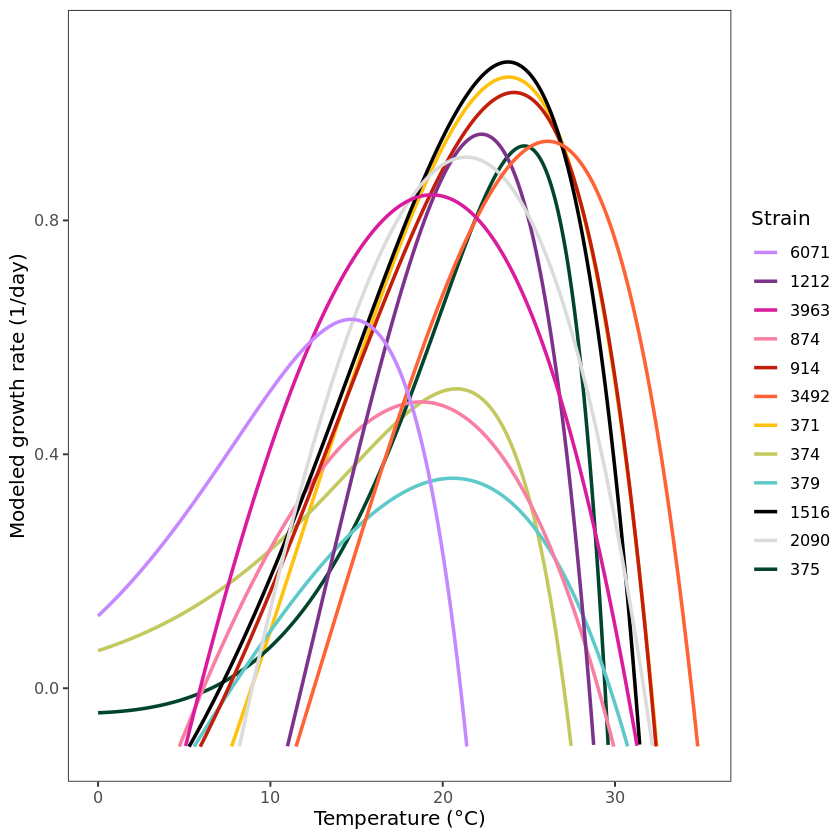

In [65]:
built_gr_df = data.frame()
for (curr in 1:nrow(all_params_coef)) {
    built_gr_df=built_gr_df %>% dplyr::bind_rows(data.frame(Strain=all_params_coef$Strain[curr],
                                                            Temperature = seq(0,35,by=0.01),
                                                            ModeledPoints = nbcurve(seq(0,35,by=0.01),
                                                                                    opt=all_params_coef$opt[curr],
                                                                         a=all_params_coef$a[curr],
                                                                         w=all_params_coef$w[curr],
                                                                         b=all_params_coef$b[curr])))
}

growth_curves_fig = ggplot(built_gr_df %>% dplyr::filter(!is.na(ModeledPoints)))+geom_line(aes(x = Temperature,y=ModeledPoints,group=Strain,
                                  color=factor(Strain)),lwd=1)+ 
    ylim(c(-0.1,1.1)) + scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                                           name="Strain")+
    theme_test(base_size=12) + xlab("Temperature (°C)") + ylab("Modeled growth rate (1/day)")
growth_curves_fig

In [17]:
strain_color_frame_harriet

Strains_full,Strains,Colors
<chr>,<chr>,<chr>
RCC6856,6856,#4443c6
RCC6071,6071,#c688ff
RCC1212,1212,#7d328b
RCC3963,3963,#da1b9d
RCC874,874,#f87fa2
CCMP1280,1280,#b90033
RCC4567,4567,#ff5755
RCC914,914,#c31d0b
RCC3492,3492,#ff6235


In [18]:
norberg_intercept<-function(a,b,width,opt,order) {
    if (order=="one") {
        return(width/2+opt)
        #return((0.75**0.5)*width/2+opt)
    } else {
        return(-width/2+opt)
        #return(-(0.75**0.5)*width/2+opt)
    }
}

In [19]:
revised_df_width = all_params_coef %>%
    rowwise() %>%
    dplyr::mutate(intercept1=norberg_intercept(a,b,w,opt,"one"),
                  intercept2=norberg_intercept(a,b,w,opt,"two")) %>%
    dplyr::mutate(low_intercept=case_when(Strain=="374" ~ 7,
                                          Strain=="6071" ~ 1,
                                          intercept1>intercept2 ~ intercept2,
                                          TRUE ~ intercept1))%>%
    dplyr::mutate(high_intercept=case_when(intercept1<intercept2 ~ intercept2,
                                          TRUE ~ intercept1)) %>%
    dplyr::mutate(Width=high_intercept-low_intercept)
    

In [20]:
revised_df_width %>% dplyr::arrange(Width)

a,b,w,opt,a_err,b_err,w_err,opt_err,Strain,intercept1,intercept2,low_intercept,high_intercept,Width
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.24089778,0.06448590,16.70321,20.149342,1.11642098,0.01,5.278316,3.182994,1212,28.50095,11.797739,11.797739,28.50095,16.70321
0.06562784,0.13606098,46.96904,3.547755,0.03519599,0.01,NaN,NaN,374,27.03228,-19.936766,7.000000,27.03228,20.03228
0.17620292,0.10961674,27.20660,7.433221,0.42723788,0.01,NaN,NaN,6071,21.03652,-6.170076,1.000000,21.03652,20.03652
0.29684290,0.04622866,21.91422,23.481648,1.20793999,0.01,10.800079,6.112007,3492,34.43876,12.524536,12.524536,34.43876,21.91422
0.19273662,0.03164356,21.96335,18.724645,1.66197034,0.01,12.178114,6.769767,379,29.70632,7.742970,7.742970,29.70632,21.96335
0.64336070,0.01654659,22.72790,20.304963,NaN,0.01,NaN,NaN,2090,31.66891,8.941014,8.941014,31.66891,22.72790
0.02839779,0.15822338,22.84897,17.996478,0.09599847,0.01,NaN,NaN,375,29.42097,6.571991,6.571991,29.42097,22.84897
0.35372160,0.01791198,22.90887,17.565502,2.10984881,0.01,12.842676,9.458257,874,29.01994,6.111066,6.111066,29.01994,22.90887
0.31607415,0.05379428,23.20696,20.501087,0.62093579,0.01,4.175940,2.465159,371,32.10457,8.897609,8.897609,32.10457,23.20696


In [21]:
revised_df_2

Strain,Revised_opt,Revised_gr_at_opt
<dbl>,<dbl>,<dbl>
374,20.80583,0.5119661
3963,19.36241,0.8437714
3492,26.09844,0.9353981
1516,23.78410,1.0710528
874,18.72846,0.4896115
375,24.73246,0.9274210
2090,21.36411,0.9082177
379,20.57834,0.3590959
1212,22.25527,0.9475015


Joining with `by =
join_by(a, b, w, opt,
a_err, b_err, w_err,
opt_err, Strain)`
Joining with `by =
join_by(Strain)`
Warning message:
“Using `size` aesthetic for
lines was deprecated in
ggplot2 3.4.0.
ℹ Please use `linewidth`
  instead.”
Warning message in geom_segment(aes(x = 12, xend = Revised_opt, y = Width, yend = Width, :
“Ignoring unknown
parameters: `shape`”
Warning message in geom_segment(aes(y = 12, yend = Width, x = Revised_opt, xend = Revised_opt, :
“Ignoring unknown
parameters: `shape`”


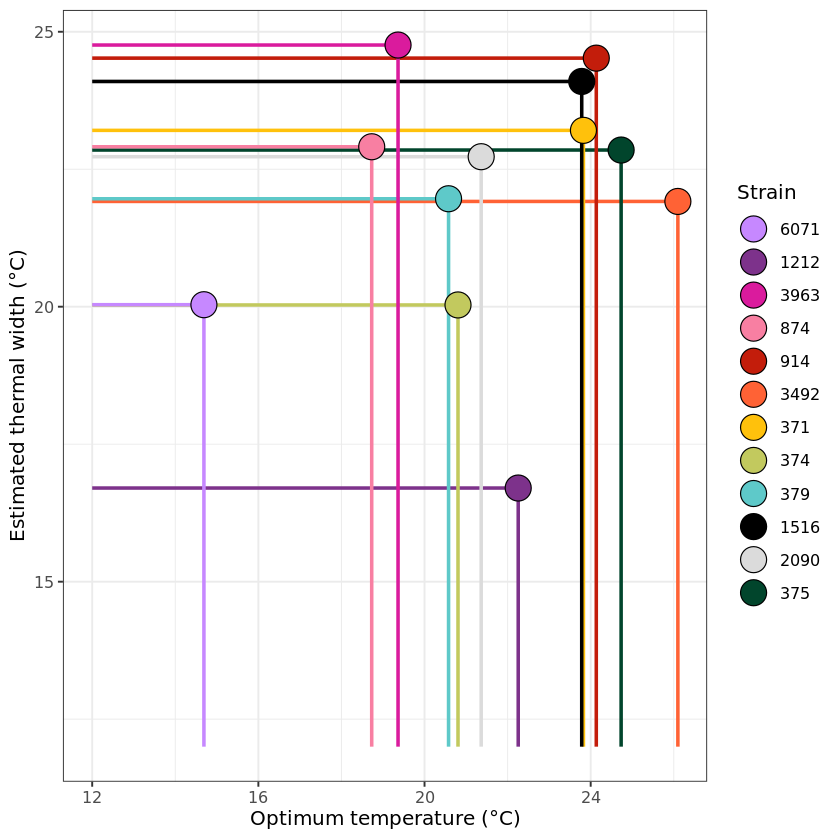

In [22]:
width_matrix = ggplot(all_params_coef%>%
                      dplyr::left_join(revised_df_width) %>%
                      dplyr::left_join(revised_df_2) %>%
       dplyr::arrange(desc(Revised_opt)) %>%
       dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))))+ 
    geom_segment(aes(x = 12, xend =Revised_opt,y=Width,
                     yend=Width,color=Strain),pch=21,size=1)+
    geom_segment(aes(y = 12, yend =Width,x=Revised_opt,
                     xend=Revised_opt,color=Strain),pch=21,size=1)+
    geom_point(aes(x = Revised_opt, y =Width,fill=Strain),pch=21,size=7)+theme_bw(base_size=12) + 
    ylab("Estimated thermal width (°C)")+ 
    xlab("Optimum temperature (°C)") + 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") + 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") 
width_matrix

Joining with `by =
join_by(a, b, w, opt,
a_err, b_err, w_err,
opt_err, Strain)`
Joining with `by =
join_by(Strain)`


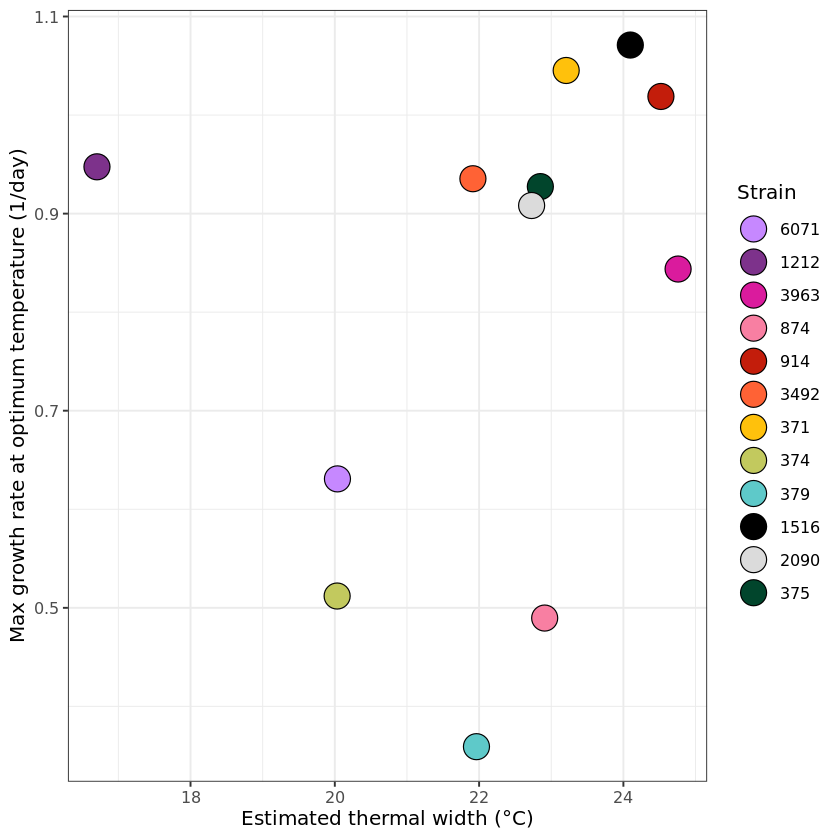

In [23]:
gr_opt_mat = ggplot(all_params_coef%>%
                      dplyr::left_join(revised_df_width) %>%
                      dplyr::left_join(revised_df_2) %>%
       dplyr::arrange(desc(Revised_opt)) %>%
       dplyr::mutate(Strain=factor(Strain,levels=unique(Strain))))+ 
    #geom_segment(aes(x = 12, xend =Revised_opt,y=Width,
    #                 yend=Width,color=Strain),pch=21,size=1)+
    #geom_segment(aes(y = 12, yend =Width,x=Revised_opt,
    #                 xend=Revised_opt,color=Strain),pch=21,size=1)+
    geom_point(aes(y = Revised_gr_at_opt, x =Width,fill=Strain),pch=21,size=7)+theme_bw(base_size=12) + 
    xlab("Estimated thermal width (°C)")+ 
    ylab("Max growth rate at optimum temperature (1/day)") + 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") + 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") 
gr_opt_mat

In [24]:
all_params_coef

a,b,w,opt,a_err,b_err,w_err,opt_err,Strain
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.06562784,0.13606098,46.96904,3.547755,0.03519599,0.01,NaN,NaN,374
0.64977969,0.01386898,24.75824,18.307480,2.61140110,0.01,14.882124,8.998253,3963
0.29684290,0.04622866,21.91422,23.481648,1.20793999,0.01,10.800079,6.112007,3492
0.20924106,0.07546327,24.09606,19.125906,0.38672823,0.01,4.360507,2.510743,1516
0.35372160,0.01791198,22.90887,17.565502,2.10984881,0.01,12.842676,9.458257,874
0.02839779,0.15822338,22.84897,17.996478,0.09599847,0.01,NaN,NaN,375
0.64336070,0.01654659,22.72790,20.304963,NaN,0.01,NaN,NaN,2090
0.19273662,0.03164356,21.96335,18.724645,1.66197034,0.01,12.178114,6.769767,379
0.24089778,0.06448590,16.70321,20.149342,1.11642098,0.01,5.278316,3.182994,1212


In [25]:
write.csv(all_params_coef,"/vortexfs1/omics/alexander/akrinos/2023-Krinos-Ghux-Darwin/code/darwin-processing-scripts/num_coexisting_widths/all_params_experiments_15Dec_fromfinal-code-notebooks.csv")


In [26]:
max(revised_df_2$Revised_opt)-min(revised_df_2$Revised_opt)

[1] 11.40888

In [27]:
revised_df_plateau

Strain,Revised_plateau,low_temp,high_temp,topt,gr_opt,left_plateau,right_plateau
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
374,8.29,15.790656,24.08066,20.80583,0.5119661,5.015178,3.274822
3963,10.97,13.674935,24.64494,19.36241,0.8437714,5.687474,5.282526
3492,7.49,22.711994,30.20199,26.09844,0.9353981,3.386447,4.103553
1516,8.84,18.704101,27.54410,23.78410,1.0710528,5.079996,3.760004
874,10.11,13.451032,23.56103,18.72846,0.4896115,5.277425,4.832575
375,6.07,21.111963,27.18196,24.73246,0.9274210,3.620499,2.449501
2090,10.06,16.130237,26.19024,21.36411,0.9082177,5.233871,4.826129
379,9.48,15.494995,24.97499,20.57834,0.3590959,5.083344,4.396656
1212,4.49,20.855501,25.34550,22.25527,0.9475015,1.399769,3.090231


Warning message:
“Duplicated aesthetics
after name
standardisation: colour”
Warning message:
“Duplicated aesthetics
after name
standardisation: colour”


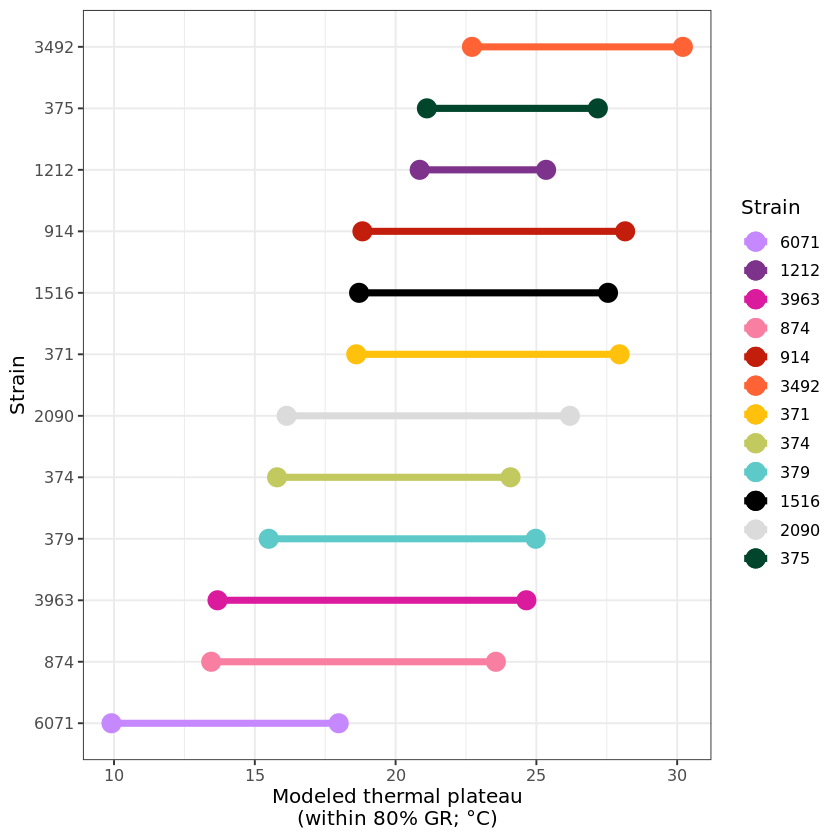

In [28]:
plateau_plot = ggplot(revised_df_plateau)+
    geom_segment(aes(x=low_temp,xend=high_temp,y=factor(Strain,
                                                        levels=(revised_df_plateau %>% dplyr::arrange(low_temp))$Strain),
                     yend=factor(Strain,levels=(revised_df_plateau %>% dplyr::arrange(low_temp))$Strain),color=factor(Strain)),lwd=2) + 
    geom_point(aes(x=low_temp,y=factor(Strain,levels=(revised_df_plateau %>% 
                                                      dplyr::arrange(low_temp))$Strain),
                   color=factor(Strain)),size=5) + 
    geom_point(aes(x=high_temp,y=factor(Strain,levels=(revised_df_plateau %>% 
                                                       dplyr::arrange(low_temp))$Strain),
                   color=factor(Strain),color=factor(Strain)),size=5) + 
    xlab("Modeled thermal plateau\n(within 80% GR; °C)")+ 
    ylab("Strain") + theme_bw(base_size=12)+ 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") 
plateau_plot

Warning message:
“Duplicated aesthetics
after name
standardisation: colour”
Warning message:
“Duplicated aesthetics
after name
standardisation: colour”


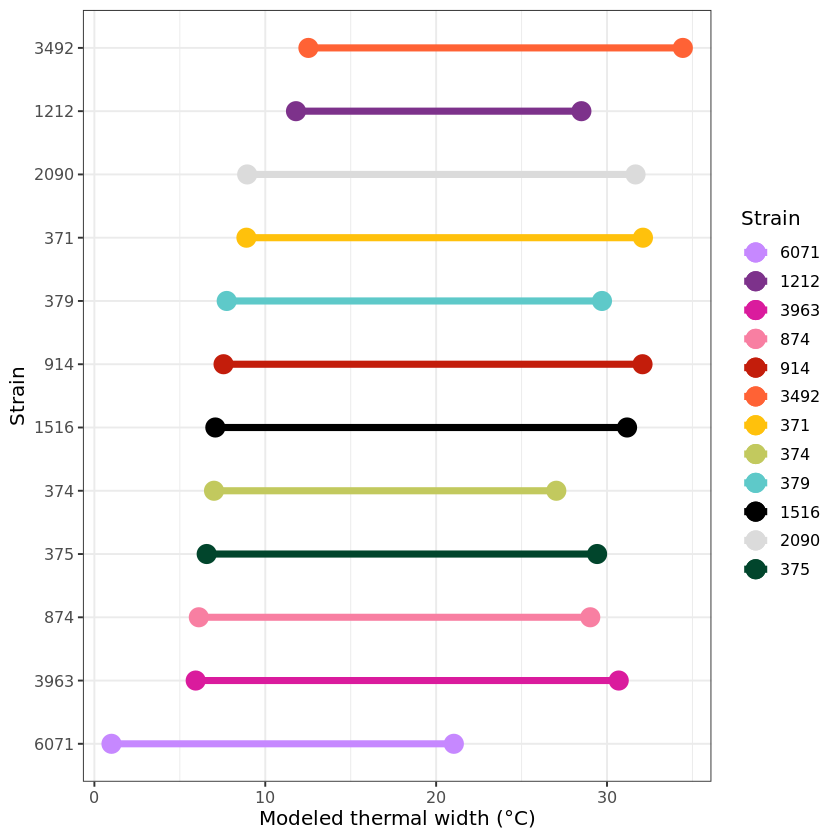

In [29]:
width_plot = ggplot(revised_df_width)+
    geom_segment(aes(x=low_intercept,xend=high_intercept,y=factor(Strain,
                                                        levels=(revised_df_width %>% dplyr::arrange(low_intercept))$Strain),
                     yend=factor(Strain,levels=(revised_df_width %>% dplyr::arrange(low_intercept))$Strain),color=factor(Strain)),lwd=2) + 
    geom_point(aes(x=low_intercept,y=factor(Strain,levels=(revised_df_width %>% 
                                                      dplyr::arrange(low_intercept))$Strain),
                   color=factor(Strain)),size=5) + 
    geom_point(aes(x=high_intercept,y=factor(Strain,levels=(revised_df_width %>% 
                                                       dplyr::arrange(low_intercept))$Strain),
                   color=factor(Strain),color=factor(Strain)),size=5) + 
    xlab("Modeled thermal width (°C)")+ 
    ylab("Strain") + theme_bw(base_size=12)+ 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Strains),
                                        values=(strain_color_frame_harriet%>%
                                            dplyr::filter(Strains%in%all_params_coef$Strain))$Colors,
                       name="Strain") 
width_plot

Warning message:
“Duplicated aesthetics
after name
standardisation: colour”
Warning message:
“Duplicated aesthetics
after name
standardisation: colour”
Warning message:
“Duplicated aesthetics
after name
standardisation: colour”
Warning message:
“Duplicated aesthetics
after name
standardisation: colour”


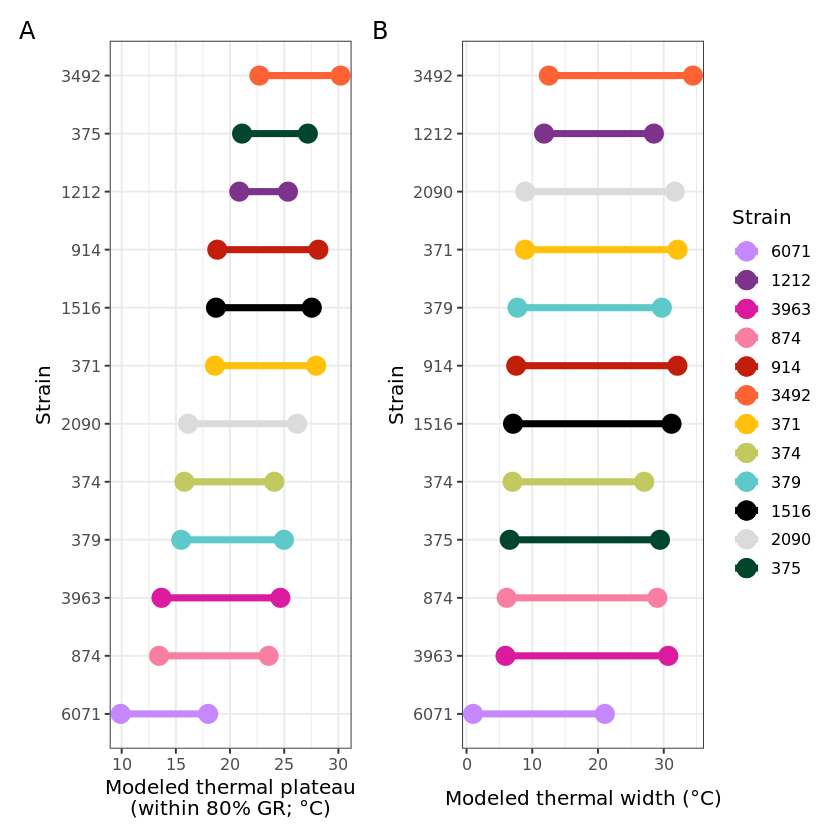

In [30]:
(plateau_plot|width_plot) +plot_layout(guides = "collect") & plot_annotation(tag_levels="A")
ggsave("../../figures/supplemental/widths_v_plateau.png",width=10,height=6,units="in")

In [31]:
revised_df_width %>% dplyr::arrange(Width)

a,b,w,opt,a_err,b_err,w_err,opt_err,Strain,intercept1,intercept2,low_intercept,high_intercept,Width
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.24089778,0.06448590,16.70321,20.149342,1.11642098,0.01,5.278316,3.182994,1212,28.50095,11.797739,11.797739,28.50095,16.70321
0.06562784,0.13606098,46.96904,3.547755,0.03519599,0.01,NaN,NaN,374,27.03228,-19.936766,7.000000,27.03228,20.03228
0.17620292,0.10961674,27.20660,7.433221,0.42723788,0.01,NaN,NaN,6071,21.03652,-6.170076,1.000000,21.03652,20.03652
0.29684290,0.04622866,21.91422,23.481648,1.20793999,0.01,10.800079,6.112007,3492,34.43876,12.524536,12.524536,34.43876,21.91422
0.19273662,0.03164356,21.96335,18.724645,1.66197034,0.01,12.178114,6.769767,379,29.70632,7.742970,7.742970,29.70632,21.96335
0.64336070,0.01654659,22.72790,20.304963,NaN,0.01,NaN,NaN,2090,31.66891,8.941014,8.941014,31.66891,22.72790
0.02839779,0.15822338,22.84897,17.996478,0.09599847,0.01,NaN,NaN,375,29.42097,6.571991,6.571991,29.42097,22.84897
0.35372160,0.01791198,22.90887,17.565502,2.10984881,0.01,12.842676,9.458257,874,29.01994,6.111066,6.111066,29.01994,22.90887
0.31607415,0.05379428,23.20696,20.501087,0.62093579,0.01,4.175940,2.465159,371,32.10457,8.897609,8.897609,32.10457,23.20696


In [32]:
max(revised_df_width$Width)-min(revised_df_width$Width)

[1] 8.055032

In [33]:
ALL_EHUX = read.csv('/vortexfs1/omics/alexander/halexander/2020-Ehux/RCC-parsing/EHUX_all_strains.csv')

ALL_EHUX %>% dplyr::select(X,RCC.temperature,Latitude,Longitude)%>%
    dplyr::filter(X %in% c("RCC6856","RCC6071","RCC1212","RCC3963",
                           "RCC874","CCMP1280","RCC4567","RCC914","RCC3492",
                           "CCMP371","RCC1215","CCMP377","RCC1239",
                           "RCC1222","RCC1256","CCMP74","CCMP379","CCMP1516",
                           "CCMP2090","CCMP375"))%>%
    dplyr::bind_rows(data.frame("X"=c("CCMP371","CCMP1280","CCMP375","CCMP377","CCMP1516/2090","CCMP379"),
                                "Latitude"=c(32,-12,32,43,-2.67,50.17),
                                "Longitude"=c(-62,-35,-62,-68,-82.72,-4.25), # deposit date is used if sampling unavailable
                                "SamplingYear"=c(1987,1990,1967,1988,1992,NA),
                                "SamplingMonth"=c(6,10,2,9,9,NA)))

other_isolation_dates = data.frame("X"=c("RCC874","RCC914","RCC1212","RCC1215","RCC1222",
                                         "RCC1239","RCC1256","RCC3492","RCC3963","RCC6071"),
                                   "SamplingYear"=c(2004,2004,2000,2001,1998,2002,1999,2011,
                                                    2011,2018),
                                   "SamplingMonth"=c(11,10,9,2,7,4,7,12,10,3),
                                   "SamplingDepth"=c(5,10,3,NA,20,NA,NA,0,NA,10),
                                   "SamplingTemp"=c(NA,27.78,NA,NA,NA,NA,NA,NA,NA,NA))

sample_t_frame = ALL_EHUX %>% dplyr::select(X,RCC.temperature,Latitude,Longitude)%>%
    dplyr::filter(X %in% c("RCC6856","RCC6071","RCC1212","RCC3963",
                                                   "RCC874","CCMP1280","RCC4567","RCC914","RCC3492",
                                                   "CCMP371","RCC1215","CCMP377","RCC1239",
                                                   "RCC1222","RCC1256","CCMP74","CCMP379","CCMP1516",
                                                   "CCMP2090","CCMP375"))%>%
    dplyr::left_join(other_isolation_dates,by=c("X"))%>%
    dplyr::bind_rows(data.frame("X"=c("CCMP371","CCMP1280","CCMP375","CCMP377","CCMP1516","CCMP2090","CCMP379"),
                                "Latitude"=c(32,-12,32,43,-2.67,-2.67,50.17),
                                "Longitude"=c(-62,-35,-62,-68,-82.72,-82.72,-4.25), # deposit date is used if sampling unavailable
                                "SamplingYear"=c(1987,1990,1967,1988,1992,1992,NA),
                                "SamplingMonth"=c(6,10,2,9,9,9,NA),
                                "SamplingTemp"=c(NA,NA,NA,NA,NA,NA,NA)))

final_merge_df=sample_t_frame %>% separate(X,into=c("RCC","StrainRCC"),sep="RCC") %>%
    tidyr::separate(RCC,into=c("CCMP","StrainCCMP"),sep="CCMP") %>%
    dplyr::mutate(Strain=as.numeric(case_when(is.na(StrainCCMP)~StrainRCC,
                                   StrainCCMP=="1516/2090"~"1516",
                                   TRUE ~ StrainCCMP))) %>%
    dplyr::bind_rows(data.frame("Strain"=as.numeric(c("371","1280","375","377",
                       "1516","2090","379","4567","371","374")),
                "Latitude"=c(32,-12,32,43,-2.67,-2.67,50.1669,-11.48,32,42.5),
                "Longitude"=c(-62,-35,-62,-68,-82.72,-82.72,-4.2504,-25.05,-62,-69)))

X,RCC.temperature,Latitude,Longitude,SamplingYear,SamplingMonth
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
RCC874,17,-31.82,-91.47,NA,NA
RCC914,17,-8.33,-141.25,NA,NA
RCC1212,17,-34.47,17.30,NA,NA
RCC1215,17,41.67,2.80,NA,NA
RCC1222,17,59.77,20.64,NA,NA
RCC1239,17,43.22,141.02,NA,NA
RCC1256,17,63.45,-20.23,NA,NA
RCC3492,22,26.61,127.87,NA,NA
RCC3963,15,-33.63,-78.82,NA,NA


Warning message:
“Expected 2 pieces. Missing
pieces filled with `NA` in
7 rows [11, 12, 13, 14,
15, 16, 17].”
Warning message:
“Expected 2 pieces. Missing
pieces filled with `NA` in
10 rows [1, 2, 3, 4, 5, 6,
7, 8, 9, 10].”


In [34]:
print_summaries <- function(dataframe_in,column) {
    curr_data=dataframe_in[column]
    print(paste("Min of column",column,"is",round(min(curr_data),2),sep=" "))
    print(paste("Max of column",column,"is",round(max(curr_data),2),sep=" "))
    print(paste("Range of column",column,"is",round(max(curr_data)-min(curr_data),2),sep=" "))
}
print_summaries(all_params_coef,"opt")
print_summaries(all_params_coef,"w")

[1] "Min of column opt is 3.55"
[1] "Max of column opt is 23.48"
[1] "Range of column opt is 19.93"
[1] "Min of column w is 16.7"
[1] "Max of column w is 46.97"
[1] "Range of column w is 30.27"


Joining with `by =
join_by(a, b, w, opt,
a_err, b_err, w_err,
opt_err, Strain)`
Joining with `by =
join_by(Strain)`
Joining with `by =
join_by(Strain)`
Joining with `by =
join_by(a, b, w, opt,
a_err, b_err, w_err,
opt_err, Strain)`
Joining with `by =
join_by(Strain)`
Joining with `by =
join_by(Strain)`


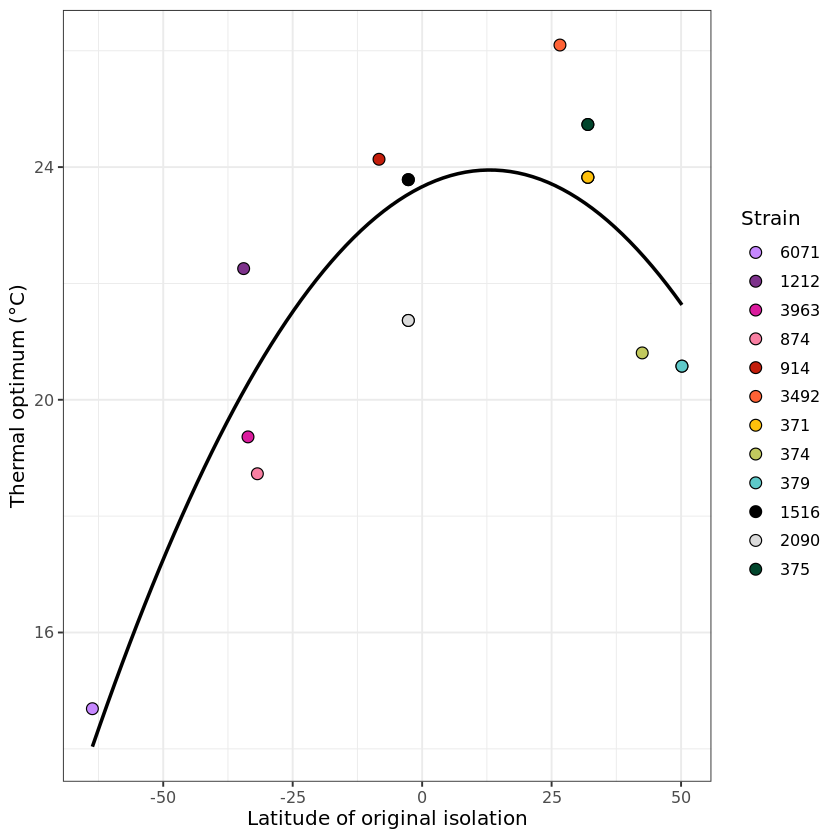

In [68]:
latitude_opt=ggplot(all_params_coef%>%
                      dplyr::left_join(revised_df_width) %>%
                      dplyr::left_join(revised_df_2)%>% dplyr::left_join(final_merge_df)) + geom_point(aes(y=Revised_opt,x=Latitude,fill=factor(Strain)),pch=21,color="black",
                                                                                                       size=3)+ 
    scale_fill_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                      name="Strain")+
    theme_bw(base_size=12) + ylab("Thermal optimum (°C)") + xlab("Latitude of original isolation")+
   geom_smooth(data=all_params_coef%>%
                      dplyr::left_join(revised_df_width) %>%
                      dplyr::left_join(revised_df_2) %>% dplyr::left_join(final_merge_df),
               method="lm", aes(x=Latitude,y=Revised_opt,color="Exp Model"), color="black",
               formula= (y ~  x + I(x^2)), 
               se=FALSE, linetype = 1)
latitude_opt

Joining with `by =
join_by(Strain)`
Joining with `by =
join_by(a, b, w, opt,
a_err, b_err, w_err,
opt_err, Strain)`


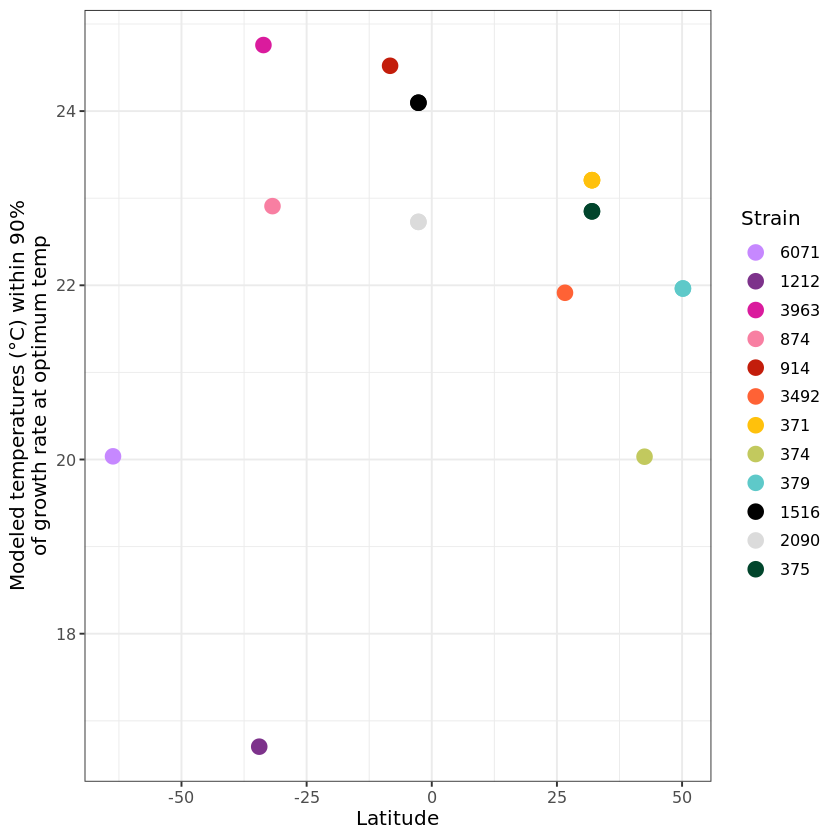

In [36]:
ggplot(all_params_coef %>% dplyr::left_join(final_merge_df) %>% dplyr::left_join(revised_df_width)) + 
    geom_point(aes(x=Latitude,y=Width,color=factor(Strain)),size=4)+ 
    scale_color_manual(breaks=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        limits=as.character((strain_color_frame_harriet %>% dplyr::filter(Strains %in% all_params$Strain))$Strains),
                                        values=(strain_color_frame_harriet %>% 
                                                dplyr::filter(Strains %in% all_params$Strain))$Colors,
                      name="Strain")+
    theme_bw(base_size=12) + xlab("Latitude") +ylab("Modeled temperatures (°C) within 90%\nof growth rate at optimum temp") 


In [37]:
best_gr_frame=data.frame()
for (curr in 1:nrow(all_params_coef)) {
    best_gr_frame=best_gr_frame %>% dplyr::bind_rows(data.frame(Strain=all_params_coef$Strain[curr],
                                                            Temperature = all_params_coef$opt[curr],
                                                            ModeledPoints = nbcurve(all_params_coef$opt[curr],
                                                                                    opt=all_params_coef$opt[curr],
                                                                         a=all_params_coef$a[curr],
                                                                         w=all_params_coef$w[curr],
                                                                         b=all_params_coef$b[curr]),
                                                            w = all_params_coef$w[curr],
                                                            opt = all_params_coef$opt[curr]))
}
best_gr_frame=best_gr_frame%>%dplyr::left_join(revised_df_width) %>%
    dplyr::left_join(revised_df_plateau)

Joining with `by =
join_by(Strain, w, opt)`
Joining with `by =
join_by(Strain)`


In [38]:
colnames(best_gr_frame)

[1] "Strain"          "Temperature"     "ModeledPoints"   "w"              
 [5] "opt"             "a"               "b"               "a_err"          
 [9] "b_err"           "w_err"           "opt_err"         "intercept1"     
[13] "intercept2"      "low_intercept"   "high_intercept"  "Width"          
[17] "Revised_plateau" "low_temp"        "high_temp"       "topt"           
[21] "gr_opt"          "left_plateau"    "right_plateau"

In [39]:
cor.test(best_gr_frame$topt,best_gr_frame$Revised_plateau, method="kendall")


	Kendall's rank correlation tau

data:  best_gr_frame$topt and best_gr_frame$Revised_plateau
T = 22, p-value = 0.1526
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.3333333 


In [40]:
cor.test(best_gr_frame$gr_opt,best_gr_frame$Revised_plateau, method="kendall")


	Kendall's rank correlation tau

data:  best_gr_frame$gr_opt and best_gr_frame$Revised_plateau
T = 25, p-value = 0.3108
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.2424242 


In [41]:
cor.test(best_gr_frame$Revised_plateau,best_gr_frame$Width, method="kendall")


	Kendall's rank correlation tau

data:  best_gr_frame$Revised_plateau and best_gr_frame$Width
T = 47, p-value = 0.06287
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.4242424 


In [42]:
cor.test(best_gr_frame$ModeledPoints,best_gr_frame$w, method="kendall")


	Kendall's rank correlation tau

data:  best_gr_frame$ModeledPoints and best_gr_frame$w
T = 23, p-value = 0.1969
alternative hypothesis: true tau is not equal to 0
sample estimates:
       tau 
-0.3030303 


In [43]:
cor.test(best_gr_frame$ModeledPoints,best_gr_frame$opt, method="kendall")


	Kendall's rank correlation tau

data:  best_gr_frame$ModeledPoints and best_gr_frame$opt
T = 56, p-value = 0.0009745
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.6969697 


In [44]:
all_params_coef%>%
                      dplyr::left_join(revised_df_width) %>%
                      dplyr::left_join(revised_df_2)

Joining with `by =
join_by(a, b, w, opt,
a_err, b_err, w_err,
opt_err, Strain)`
Joining with `by =
join_by(Strain)`


a,b,w,opt,a_err,b_err,w_err,opt_err,Strain,intercept1,intercept2,low_intercept,high_intercept,Width,Revised_opt,Revised_gr_at_opt
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.06562784,0.13606098,46.96904,3.547755,0.03519599,0.01,NaN,NaN,374,27.03228,-19.936766,7.000000,27.03228,20.03228,20.80583,0.5119661
0.64977969,0.01386898,24.75824,18.307480,2.61140110,0.01,14.882124,8.998253,3963,30.68660,5.928361,5.928361,30.68660,24.75824,19.36241,0.8437714
0.29684290,0.04622866,21.91422,23.481648,1.20793999,0.01,10.800079,6.112007,3492,34.43876,12.524536,12.524536,34.43876,21.91422,26.09844,0.9353981
0.20924106,0.07546327,24.09606,19.125906,0.38672823,0.01,4.360507,2.510743,1516,31.17394,7.077876,7.077876,31.17394,24.09606,23.78410,1.0710528
0.35372160,0.01791198,22.90887,17.565502,2.10984881,0.01,12.842676,9.458257,874,29.01994,6.111066,6.111066,29.01994,22.90887,18.72846,0.4896115
0.02839779,0.15822338,22.84897,17.996478,0.09599847,0.01,NaN,NaN,375,29.42097,6.571991,6.571991,29.42097,22.84897,24.73246,0.9274210
0.64336070,0.01654659,22.72790,20.304963,NaN,0.01,NaN,NaN,2090,31.66891,8.941014,8.941014,31.66891,22.72790,21.36411,0.9082177
0.19273662,0.03164356,21.96335,18.724645,1.66197034,0.01,12.178114,6.769767,379,29.70632,7.742970,7.742970,29.70632,21.96335,20.57834,0.3590959
0.24089778,0.06448590,16.70321,20.149342,1.11642098,0.01,5.278316,3.182994,1212,28.50095,11.797739,11.797739,28.50095,16.70321,22.25527,0.9475015


In [45]:
summary(lm(formula= (Revised_opt ~  Latitude + I(Latitude^2)),data=all_params_coef%>%
                      dplyr::left_join(revised_df_width) %>%
                      dplyr::left_join(revised_df_2)%>% dplyr::left_join(final_merge_df)))

Joining with `by =
join_by(a, b, w, opt,
a_err, b_err, w_err,
opt_err, Strain)`
Joining with `by =
join_by(Strain)`
Joining with `by =
join_by(Strain)`



Call:
lm(formula = (Revised_opt ~ Latitude + I(Latitude^2)), data = all_params_coef %>% 
    dplyr::left_join(revised_df_width) %>% dplyr::left_join(revised_df_2) %>% 
    dplyr::left_join(final_merge_df))

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1698 -1.0536  0.3646  0.8790  2.4573 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   23.6633103  0.5418657  43.670  < 2e-16 ***
Latitude       0.0439650  0.0111260   3.952 0.001279 ** 
I(Latitude^2) -0.0016835  0.0003489  -4.825 0.000222 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.531 on 15 degrees of freedom
Multiple R-squared:  0.7291,	Adjusted R-squared:  0.693 
F-statistic: 20.19 on 2 and 15 DF,  p-value: 5.569e-05


In [46]:
summary(lm(formula= (Width ~  Latitude + I(Latitude^2)),data=all_params_coef %>% 
           dplyr::left_join(final_merge_df) %>%
           dplyr::left_join(revised_df_width)))

Joining with `by =
join_by(Strain)`
Joining with `by =
join_by(a, b, w, opt,
a_err, b_err, w_err,
opt_err, Strain)`



Call:
lm(formula = (Width ~ Latitude + I(Latitude^2)), data = all_params_coef %>% 
    dplyr::left_join(final_merge_df) %>% dplyr::left_join(revised_df_width))

Residuals:
    Min      1Q  Median      3Q     Max 
-5.3367 -0.4078  0.4673  0.7236  2.6617 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)   23.3480567  0.6243492  37.396 3.18e-16 ***
Latitude       0.0077770  0.0128196   0.607   0.5532    
I(Latitude^2) -0.0008753  0.0004020  -2.178   0.0458 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.764 on 15 degrees of freedom
Multiple R-squared:  0.258,	Adjusted R-squared:  0.1591 
F-statistic: 2.608 on 2 and 15 DF,  p-value: 0.1067


Warning message:
“Removed 12265 rows
containing missing values
(`geom_line()`).”
Warning message:
“Removed 12265 rows
containing missing values
(`geom_line()`).”


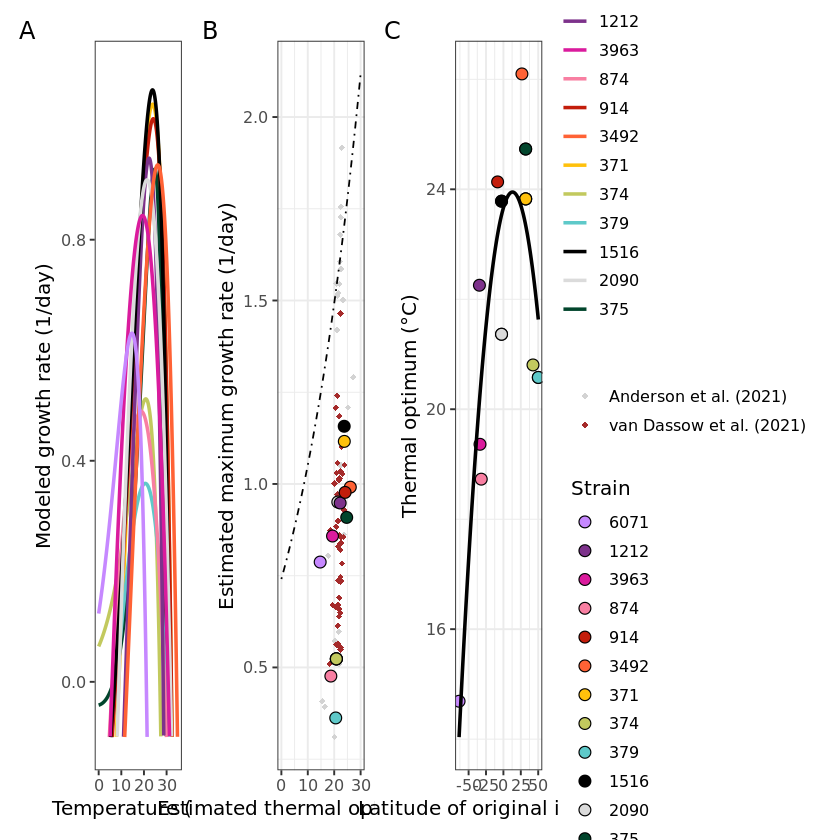

In [69]:
(growth_curves_fig|eppley_comp|latitude_opt)+ plot_layout(guides = "collect") & plot_annotation(tag_levels = 'A')
ggsave("/vortexfs1/omics/alexander/akrinos/2023-Krinos-Ghux-Darwin/figures/main/Figure2_10Feb24.pdf",
      width=12,height=4,units="in")

Warning message:
“Removed 12265 rows
containing missing values
(`geom_line()`).”
Warning message:
“Removed 12265 rows
containing missing values
(`geom_line()`).”


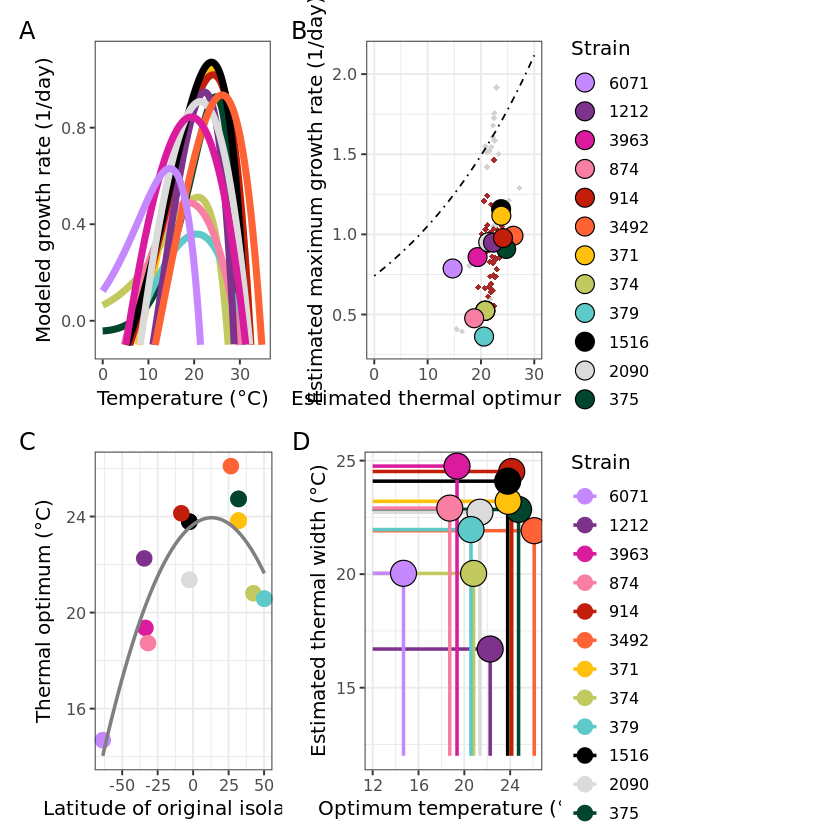

In [49]:
(growth_curves_fig|eppley_comp)/(latitude_opt|width_matrix)+ plot_layout(guides = "collect") & plot_annotation(tag_levels = 'A')
ggsave("/vortexfs1/omics/alexander/akrinos/2023-Krinos-Ghux-Darwin/figures/main/Figure2_25Nov23.pdf",
      width=12,height=9,units="in")

Warning message:
“Removed 12265 rows
containing missing
values
(`geom_line()`).”
Warning message:
“Removed 12265 rows
containing missing
values
(`geom_line()`).”


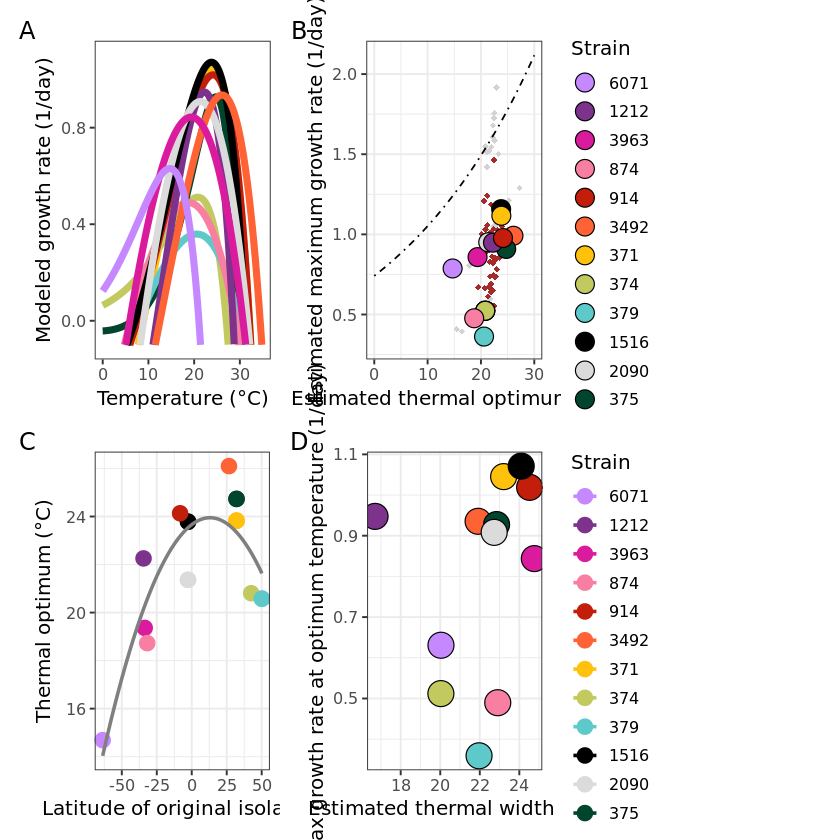

In [42]:
(growth_curves_fig|eppley_comp)/(latitude_opt|gr_opt_mat)+ plot_layout(guides = "collect") & plot_annotation(tag_levels = 'A')
ggsave("/vortexfs1/omics/alexander/akrinos/2023-Krinos-Ghux-Darwin/figures/main/Figure2_15Dec23.pdf",
      width=10,height=9,units="in")

In [ ]:
width_matrix
ggsave("/vortexfs1/omics/alexander/akrinos/2023-Krinos-Ghux-Darwin/figures/supplemental/Figure2_width_supp_15Dec23.pdf",
      width=5,height=4.5,units="in")
ggsave("/vortexfs1/omics/alexander/akrinos/2023-Krinos-Ghux-Darwin/figures/supplemental/Figure2_width_supp_15Dec23.png",
      width=5,height=4.5,units="in")